#### Amol Kaushik
#### kaushikamol@gmail.com

# Capstone - Spam Review Detection
## Amazon Review Dataset for Cell Phones and Accessories

# Notebook 2 - Setup and Modelling
### Notebook: 2/3

# Table Of Contents

1. [Introduction](#Introduction)
    * Objectives of Project
    * What value does this project bring?
2. [Data Dictionary](#DataDictionary)
3. [Data Setup](#DataSetup)
    * Load Data
    * Sample Dataset
    * Data Exploration
    * Data Transformation
    * Data Split (X and y)
4. [Modelling](#DataModelling)
    * Vectorization (Bag-of-Words Model)
    * Logistic Regression (BoW Vectorized Data)
    * Model Evaluation
    * Vectorization (TF-IDF Model)
    * Logistic Regression (TF-IDF Vectorized Data)
    * Model Evaluation
    * PCA Model (Dimension Reduction)
    * Logistic Regression (PCA Data)
    * Model Evaluation
    * Clustering (K-means)
    * Model Hyperparameter Optimization
    * Save Vectorized X and y data
    * Load/Check saved X and y data

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() #setting the theme for the plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import time

# 1 - Introduction<a id = 'Introduction'></a>

### Objective of Capstone Project:
I aim to build an accurate and effective ML model to identify Spam Reviews posted on Amazon for purchased products.

### What value does this project bring:
This project aims to reduce the sale of sub-par products that get highly recommended on the basis of fake/spam reviews and ratings.

# 2 - Data Dictionary:
- helpful: Votes for the extent of Helpfulness of the review [Positive, Negative]
- reviewText: The review posted by the reviewer/customer
- summary: Provides a brief summary of the Product Review
- class: Spam identifier (0 = not spam, 1 = spam)

# 3 - Data Setup

### Loading the Data
Loading the cleaned dataset from the previous notebook:

In [2]:
#Loading data from local drive
data_sample_clean = pd.read_csv('Data/Cell_data_sampled_clean.csv')

In [3]:
data_sample_clean.shape

(158660, 4)

### Sampled Dataset
Creating a sampled dataset consisting of 50% of the original dataframe. This is done to help reduce the run times for all calculations due to the limitations in time and computing power.

In [4]:
#Sampling 50% of data
#Complete dataset not running
data_sample_clean = data_sample_clean.sample(frac=0.5, ignore_index=True, random_state=1)

### Data Exploration
Lets explore and check the data was any issues

In [5]:
data_sample_clean.shape

(79330, 4)

In [6]:
data_sample_clean.isna().sum()

helpful       0
reviewText    0
summary       0
class         0
dtype: int64

In [9]:
#Lets take a look at the data
data_sample_clean.head()


helpful                                         reviewText  \
0  [0, 0]  Very weak charger but does its job being able ...   
1  [1, 1]  The case was nice when I first used it to cove...   
2  [0, 0]  These are very good, especially for the price....   
3  [0, 0]  The screen got to me faster then I expected it...   
4  [0, 0]  This thing is awesome! If you're outside and l...   

                                             summary  class  
0  Very weak charger but does its job being able ...      0  
1                                     Shaped Changed      0  
2                                          Very good      1  
3                                   best screen ever      1  
4                                   This is great!!!      1

In [10]:
data_sample_clean.tail()

helpful                                         reviewText  \
79325  [0, 0]  Perfect for my Iphone 4s and exactly what I or...   
79326  [1, 2]  Great value.  If your looking to protect your ...   
79327  [2, 2]  I put this beautiful case on my phone over 9 m...   
79328  [0, 1]  excellent accessory for iphone 5,shines in the...   
79329  [0, 0]  I Love this Pink Plaid Design Snap-On Cover Ha...   

                                                 summary  class  
79325                              Perfect for Iphone 4s      1  
79326                                          Good fit.      1  
79327                            Beautiful and Well Made      1  
79328                                       nice product      1  
79329  Premium Pink Plaid Design Snap-On Cover Hard C...      1

In [11]:
data_sample_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   helpful     79330 non-null  object
 1   reviewText  79330 non-null  object
 2   summary     79330 non-null  object
 3   class       79330 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


The `helpful` column needs to be split into two columns for each of the positive and negative helpful scores, and converted into an integer datatype. The `reviewText`, and `summary` columns need to be vectorized for the modelling.

In [12]:
data_sample_clean.describe()

class
count  79330.000000
mean       0.704009
std        0.456490
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000

The median for the `class` column is 1, which is not surprised since we have an imbalanced dataset with 70% spam reviews.

The dataset looks to have loaded properly.

Lets check if there are any duplicated or missing data:

In [13]:
data_sample_clean.duplicated().sum()

0

In [14]:
data_sample_clean.isna().sum()

helpful       0
reviewText    0
summary       0
class         0
dtype: int64

Great, there is no dulpicated or missing data.

Lets continue with some data transformation prior to modelling:

### Data Transformation

The `helpful` column will be split first:

In [15]:
len(data_sample_clean['helpful']) == data_sample_clean.shape[0]

True

In [16]:
type(data_sample_clean['helpful'])

pandas.core.series.Series

In [17]:
#Creating a temporary dataframe for only the data from the helpful column
#https://stackoverflow.com/questions/35491274/split-a-pandas-column-of-lists-into-multiple-columns (source for method used)
df1 = pd.DataFrame(data_sample_clean['helpful'].str.split().values.tolist())
df1

0   1
0      [0,  0]
1      [1,  1]
2      [0,  0]
3      [0,  0]
4      [0,  0]
...    ...  ..
79325  [0,  0]
79326  [1,  2]
79327  [2,  2]
79328  [0,  1]
79329  [0,  0]

[79330 rows x 2 columns]

In [18]:
#Renaming the columns
df1 = df1.rename({0: 'help_pos', 1: 'help_neg'}, axis='columns')
df1

help_pos help_neg
0          [0,       0]
1          [1,       1]
2          [0,       0]
3          [0,       0]
4          [0,       0]
...        ...      ...
79325      [0,       0]
79326      [1,       2]
79327      [2,       2]
79328      [0,       1]
79329      [0,       0]

[79330 rows x 2 columns]

The columns have been renamed properly.

Now, moving onto extracting only the numeric values from the columns:

In [19]:
#https://stackoverflow.com/questions/60295698/extract-only-numbers-and-only-string-from-pandas-dataframe (source for method used)
df1 = df1.assign(help_pos=df1['help_pos'].str.extract(r'(\d)'))

In [20]:
#https://stackoverflow.com/questions/60295698/extract-only-numbers-and-only-string-from-pandas-dataframe (source for method used)
df1 = df1.assign(help_neg=df1['help_neg'].str.extract(r'(\d)'))

In [21]:
#Checking to ensure only the numeric values have been extracted
df1

help_pos help_neg
0            0        0
1            1        1
2            0        0
3            0        0
4            0        0
...        ...      ...
79325        0        0
79326        1        2
79327        2        2
79328        0        1
79329        0        0

[79330 rows x 2 columns]

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   help_pos  79330 non-null  object
 1   help_neg  79330 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [23]:
#Converting the columns to integers from object type
df1 = df1[['help_neg', 'help_pos']].astype(int)

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   help_neg  79330 non-null  int64
 1   help_pos  79330 non-null  int64
dtypes: int64(2)
memory usage: 1.2 MB


Great, the columns have been converted into integers.

Lets join the original dataset and df1, after which the original `helpful` column will be dropped:

In [25]:
#Joining the two dataframes
data_sample_clean = pd.concat([data_sample_clean, df1], axis=1)
data_sample_clean

helpful                                         reviewText  \
0      [0, 0]  Very weak charger but does its job being able ...   
1      [1, 1]  The case was nice when I first used it to cove...   
2      [0, 0]  These are very good, especially for the price....   
3      [0, 0]  The screen got to me faster then I expected it...   
4      [0, 0]  This thing is awesome! If you're outside and l...   
...       ...                                                ...   
79325  [0, 0]  Perfect for my Iphone 4s and exactly what I or...   
79326  [1, 2]  Great value.  If your looking to protect your ...   
79327  [2, 2]  I put this beautiful case on my phone over 9 m...   
79328  [0, 1]  excellent accessory for iphone 5,shines in the...   
79329  [0, 0]  I Love this Pink Plaid Design Snap-On Cover Ha...   

                                                 summary  class  help_neg  \
0      Very weak charger but does its job being able ...      0         0   
1                                         Shaped Changed      0         1   
2                                              Very good      1         0   
3                                       best screen ever      1         0   
4                                       This is great!!!      1         0   
...                                                  ...    ...       ...   
79325                              Perfect for Iphone 4s      1         0   
79326                                          Good fit.      1         2   
79327                            Beautiful and Well Made      1         2   
79328                                       nice product      1         1   
79329  Premium Pink Plaid Design Snap-On Cover Hard C...      1         0   

       help_pos  
0             0  
1             1  
2             0  
3             0  
4             0  
...         ...  
79325         0  
79326         1  
79327         2  
79328         0  
79329         0  

[79330 rows x 6 columns]

In [26]:
#Checking for any missing data after combining with df1
data_sample_clean.isna().sum()

helpful       0
reviewText    0
summary       0
class         0
help_neg      0
help_pos      0
dtype: int64

In [27]:
#Dropping the original helpful columns
data_sample_clean.drop(columns = ['helpful'], inplace=True)
data_sample_clean

reviewText  \
0      Very weak charger but does its job being able ...   
1      The case was nice when I first used it to cove...   
2      These are very good, especially for the price....   
3      The screen got to me faster then I expected it...   
4      This thing is awesome! If you're outside and l...   
...                                                  ...   
79325  Perfect for my Iphone 4s and exactly what I or...   
79326  Great value.  If your looking to protect your ...   
79327  I put this beautiful case on my phone over 9 m...   
79328  excellent accessory for iphone 5,shines in the...   
79329  I Love this Pink Plaid Design Snap-On Cover Ha...   

                                                 summary  class  help_neg  \
0      Very weak charger but does its job being able ...      0         0   
1                                         Shaped Changed      0         1   
2                                              Very good      1         0   
3                                       best screen ever      1         0   
4                                       This is great!!!      1         0   
...                                                  ...    ...       ...   
79325                              Perfect for Iphone 4s      1         0   
79326                                          Good fit.      1         2   
79327                            Beautiful and Well Made      1         2   
79328                                       nice product      1         1   
79329  Premium Pink Plaid Design Snap-On Cover Hard C...      1         0   

       help_pos  
0             0  
1             1  
2             0  
3             0  
4             0  
...         ...  
79325         0  
79326         1  
79327         2  
79328         0  
79329         0  

[79330 rows x 5 columns]

In [28]:
#Checking for any missing data after dropping the column
data_sample_clean.isna().sum()

reviewText    0
summary       0
class         0
help_neg      0
help_pos      0
dtype: int64

Great, the new columns extracted from the `helpful` column have been added into the dataset as columns; `help_neg` - for negative helpful votes, and `help_pos` - for positive helpful votes.

The original `helpful` columns has been dropped.

### Data Split

Splitting the X and y datasets:

Since the aim of this project is to detect spam vs real reviews, our target/dependent variable is the `class` column.

Lets continue on and split the dataset into a remainder, and test set:

In [29]:
#Import the train test split library
from sklearn.model_selection import train_test_split

In [30]:
#Splitting the X and y variables
X = data_sample_clean.drop(columns=['class']) #Independent variables
y = data_sample_clean['class'] #Dependent Variable

In [31]:
X.isna().sum()

reviewText    0
summary       0
help_neg      0
help_pos      0
dtype: int64

In [32]:
X

reviewText  \
0      Very weak charger but does its job being able ...   
1      The case was nice when I first used it to cove...   
2      These are very good, especially for the price....   
3      The screen got to me faster then I expected it...   
4      This thing is awesome! If you're outside and l...   
...                                                  ...   
79325  Perfect for my Iphone 4s and exactly what I or...   
79326  Great value.  If your looking to protect your ...   
79327  I put this beautiful case on my phone over 9 m...   
79328  excellent accessory for iphone 5,shines in the...   
79329  I Love this Pink Plaid Design Snap-On Cover Ha...   

                                                 summary  help_neg  help_pos  
0      Very weak charger but does its job being able ...         0         0  
1                                         Shaped Changed         1         1  
2                                              Very good         0         0  
3                                       best screen ever         0         0  
4                                       This is great!!!         0         0  
...                                                  ...       ...       ...  
79325                              Perfect for Iphone 4s         0         0  
79326                                          Good fit.         2         1  
79327                            Beautiful and Well Made         2         2  
79328                                       nice product         1         0  
79329  Premium Pink Plaid Design Snap-On Cover Hard C...         0         0  

[79330 rows x 4 columns]

In [33]:
y

0        0
1        0
2        1
3        1
4        1
        ..
79325    1
79326    1
79327    1
79328    1
79329    1
Name: class, Length: 79330, dtype: int64

In [34]:
#Splitting the data into remainder and test sets
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify= y)

In [35]:
#Size of remainder data
X_remainder.shape

(55531, 4)

In [36]:
#Size of test data
X_test.shape

(23799, 4)

In [37]:
#Size of y data
y_remainder.shape, y_test.shape

((55531,), (23799,))

In [38]:
#Sanity check for number of rows
X_remainder.shape[0] + X_test.shape[0] == X.shape[0]

True

In [39]:
#Sanity check for number of columns
X_remainder.shape[1] == X_test.shape[1] == X.shape[1]

True

In [40]:
#Sanity check for number of rows
y_remainder.shape[0] + y_test.shape[0] == y.shape[0]

True

The X, and y remainder/test sets have been split properly, and their shapes are matching.

Now lets vectorise the `summary` column:

# 4 - Modelling

The `reviewText`, and `summary` columns will need to be vectorized prior to any modelling. For the vectorization I shall only be removing the stop words. The punctuation will not be dropped as this could have some indication towards the classification of the summary or review text, and no stemming and lemmatization will done, as the misspelt words could be indicative of the classification. These conditions will apply for all methods of vectorization.

### Vectorization using Bag-of-Words model

In [41]:
#Lets check the number of unique words/phrases used in the summary column
#Need to import the SKLearn CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

### Vectorising Summary Column

For the baseline model I shall be using a bagofwords method for vectorising and remove the stop_words used in the `summary` column from the X_remainder set:

I shall create a temporary dataset of only the `summary` column from the `X_remainder` set.

This temp dataset will be vectorised and combined back with the `X_remainder` set.

In [42]:
#Creating temp dataset for remainder summary column
summ_words_rem = pd.DataFrame(X_remainder['summary'], index=X_remainder.index)
summ_words_rem

summary
10246                                          cute case
74664                                         Four Stars
11343                               Protective but Bulky
71940                                        Fell Apart!
21699                                          Adorable!
...                                                  ...
31233                                         Good Price
11620                                              Great
37006  Shipped battery not the same as the one pictured.
41060                                          Way cool!
76895                               Cadillac of chargers

[55531 rows x 1 columns]

In [43]:
#Creating temp dataset for test summary column
summ_words_test = pd.DataFrame(X_test['summary'], index=X_test.index)
summ_words_test

summary
73697                                       doesn't work
39485                                       Works great!
38104        Looks cute. Smelled horrible. I trashed it.
26576                             Terrible ~ do NOT buy!
18562                                     The best case!
...                                                  ...
78017                                              loved
2525                     makes it more secure in my hand
3169                          Very unhappy. Poor quality
35991  Great! VIZIO S3820w-C0 38-Inch 2.0 Home Theate...
33848                                        Ipod cables

[23799 rows x 1 columns]

In [44]:
# 1. Instantiate 
summary_rem_bagofwords = CountVectorizer(stop_words='english')

# 2. Fit 
summary_rem_bagofwords.fit(summ_words_rem['summary'])

# 3. Transform
summary_rem_transformed = summary_rem_bagofwords.transform(summ_words_rem['summary'])
summary_test_transformed = summary_rem_bagofwords.transform(summ_words_test['summary'])

In [45]:
summary_rem_transformed

<55531x8961 sparse matrix of type '<class 'numpy.int64'>'
	with 134999 stored elements in Compressed Sparse Row format>

In [46]:

summary_test_transformed

<23799x8961 sparse matrix of type '<class 'numpy.int64'>'
	with 56114 stored elements in Compressed Sparse Row format>

In [47]:
#Checking the total number of unique words present in the summary column
len(summary_rem_bagofwords.get_feature_names())

8961

There are a total of 8961 unique words that have been used in the `X_remainder summary` column.

8961 is too many unique words, this will create too many features for the model to run smoothly.

I shall set a min_df for the CountVectorizer which is equal to the mean of the counts for the summary words. The max_features hyperparameter will be set to 1000, this will only allow the 1000 most used words to be part of the vectorized results.

Lets check the mean count for the vectorized summary words:

In [48]:
np.mean(summary_rem_transformed.toarray().sum(axis=0))

15.210355987055015

The mean count for the vectorized summary words is ~15.21. Based on this value I shall set a min_df of 15, just below the mean value.

Lets re-vectorize the summary column, now with a min_df hyperparameter of 15:

In [49]:
# 1. Instantiate 
summary_rem_bagofwords = CountVectorizer(stop_words='english', min_df=15, max_features=1000)

# 2. Fit 
summary_rem_bagofwords.fit(summ_words_rem['summary'])

# 3. Transform
summary_rem_transformed = summary_rem_bagofwords.transform(summ_words_rem['summary'])
summary_test_transformed = summary_rem_bagofwords.transform(summ_words_test['summary'])

Sanity check for matching number of columns in the transformed data:

In [50]:
summary_rem_transformed

<55531x890 sparse matrix of type '<class 'numpy.int64'>'
	with 115920 stored elements in Compressed Sparse Row format>

In [51]:
summary_test_transformed

<23799x890 sparse matrix of type '<class 'numpy.int64'>'
	with 49805 stored elements in Compressed Sparse Row format>

In [52]:
#Checking the total number of unique words present in the summary column
len(summary_rem_bagofwords.get_feature_names())

890

After setting the min_df parameter of 15, the total number of unique words has gone down from 8961 to 890 for the `summary` column taken from the `X_remainder` and `X_test` set.

890 is still quite a lot of unique words, but this should work fine for our baseline model.

In [53]:
#Summary column from X_remainder set
summary_rem_df = pd.DataFrame(summary_rem_transformed.toarray(), columns= summary_rem_bagofwords.get_feature_names(), index=X_remainder.index)
summary_rem_df

10  100  2nd  30  3d  3g  3gs  4g  4s  50  ...  wrong  yay  year  \
10246   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
74664   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
11343   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
71940   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
21699   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
...    ..  ...  ...  ..  ..  ..  ...  ..  ..  ..  ...    ...  ...   ...   
31233   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
11620   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
37006   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
41060   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
76895   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   

       years  yellow  yes  zagg  zebra  zero  zte  
10246      0       0    0     0      0     0    0  
74664      0       0    0     0      0     0    0  
11343      0       0    0     0      0     0    0  
71940      0       0    0     0      0     0    0  
21699      0       0    0     0      0     0    0  
...      ...     ...  ...   ...    ...   ...  ...  
31233      0       0    0     0      0     0    0  
11620      0       0    0     0      0     0    0  
37006      0       0    0     0      0     0    0  
41060      0       0    0     0      0     0    0  
76895      0       0    0     0      0     0    0  

[55531 rows x 890 columns]

Sanity checks:

In [54]:
#Checking the shape of the summary dataframe
print(f'There are {summary_rem_df.shape[0]} rows, and {summary_rem_df.shape[1]} columns in the X_remainder summary dataframe')

There are 55531 rows, and 890 columns in the X_remainder summary dataframe


In [55]:
#Checking the number of rows is matching between the summary df and the X_remainder
summary_rem_df.shape[0] == X_remainder.shape[0]

True

In [56]:
#Checking for any missing data
summary_rem_df.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

In [57]:
#Summary column from X_test set
summary_test_df = pd.DataFrame(summary_test_transformed.toarray(), columns= summary_rem_bagofwords.get_feature_names(), index=X_test.index)
summary_test_df

10  100  2nd  30  3d  3g  3gs  4g  4s  50  ...  wrong  yay  year  \
73697   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
39485   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
38104   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
26576   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
18562   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
...    ..  ...  ...  ..  ..  ..  ...  ..  ..  ..  ...    ...  ...   ...   
78017   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
2525    0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
3169    0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
35991   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   
33848   0    0    0   0   0   0    0   0   0   0  ...      0    0     0   

       years  yellow  yes  zagg  zebra  zero  zte  
73697      0       0    0     0      0     0    0  
39485      0       0    0     0      0     0    0  
38104      0       0    0     0      0     0    0  
26576      0       0    0     0      0     0    0  
18562      0       0    0     0      0     0    0  
...      ...     ...  ...   ...    ...   ...  ...  
78017      0       0    0     0      0     0    0  
2525       0       0    0     0      0     0    0  
3169       0       0    0     0      0     0    0  
35991      0       0    0     0      0     0    0  
33848      0       0    0     0      0     0    0  

[23799 rows x 890 columns]

Sanity checks:

In [58]:
#Checking the shape of the summary dataframe
print(f'There are {summary_test_df.shape[0]} rows, and {summary_test_df.shape[1]} columns in the X_test summary dataframe')

There are 23799 rows, and 890 columns in the X_test summary dataframe


In [59]:
#Checking the number of rows is matching between the summary df and the X_remainder
summary_test_df.shape[0] == X_test.shape[0]

True

In [60]:
#Checking for any missing data
summary_test_df.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

Now, a prefix of `s_` will be added to the columns for both summary dataframes. This will help with identifying the words vectorised from the summary columns versus the review column, which will be done after this:

In [61]:
#Adding prefix to remainder summary DF
summary_rem_df = summary_rem_df.add_prefix('s_')
summary_rem_df

s_10  s_100  s_2nd  s_30  s_3d  s_3g  s_3gs  s_4g  s_4s  s_50  ...  \
10246     0      0      0     0     0     0      0     0     0     0  ...   
74664     0      0      0     0     0     0      0     0     0     0  ...   
11343     0      0      0     0     0     0      0     0     0     0  ...   
71940     0      0      0     0     0     0      0     0     0     0  ...   
21699     0      0      0     0     0     0      0     0     0     0  ...   
...     ...    ...    ...   ...   ...   ...    ...   ...   ...   ...  ...   
31233     0      0      0     0     0     0      0     0     0     0  ...   
11620     0      0      0     0     0     0      0     0     0     0  ...   
37006     0      0      0     0     0     0      0     0     0     0  ...   
41060     0      0      0     0     0     0      0     0     0     0  ...   
76895     0      0      0     0     0     0      0     0     0     0  ...   

       s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
10246        0      0       0        0         0      0       0        0   
74664        0      0       0        0         0      0       0        0   
11343        0      0       0        0         0      0       0        0   
71940        0      0       0        0         0      0       0        0   
21699        0      0       0        0         0      0       0        0   
...        ...    ...     ...      ...       ...    ...     ...      ...   
31233        0      0       0        0         0      0       0        0   
11620        0      0       0        0         0      0       0        0   
37006        0      0       0        0         0      0       0        0   
41060        0      0       0        0         0      0       0        0   
76895        0      0       0        0         0      0       0        0   

       s_zero  s_zte  
10246       0      0  
74664       0      0  
11343       0      0  
71940       0      0  
21699       0      0  
...       ...    ...  
31233       0      0  
11620       0      0  
37006       0      0  
41060       0      0  
76895       0      0  

[55531 rows x 890 columns]

In [62]:
#Adding prefix to test summary DF
summary_test_df = summary_test_df.add_prefix('s_')
summary_test_df

s_10  s_100  s_2nd  s_30  s_3d  s_3g  s_3gs  s_4g  s_4s  s_50  ...  \
73697     0      0      0     0     0     0      0     0     0     0  ...   
39485     0      0      0     0     0     0      0     0     0     0  ...   
38104     0      0      0     0     0     0      0     0     0     0  ...   
26576     0      0      0     0     0     0      0     0     0     0  ...   
18562     0      0      0     0     0     0      0     0     0     0  ...   
...     ...    ...    ...   ...   ...   ...    ...   ...   ...   ...  ...   
78017     0      0      0     0     0     0      0     0     0     0  ...   
2525      0      0      0     0     0     0      0     0     0     0  ...   
3169      0      0      0     0     0     0      0     0     0     0  ...   
35991     0      0      0     0     0     0      0     0     0     0  ...   
33848     0      0      0     0     0     0      0     0     0     0  ...   

       s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
73697        0      0       0        0         0      0       0        0   
39485        0      0       0        0         0      0       0        0   
38104        0      0       0        0         0      0       0        0   
26576        0      0       0        0         0      0       0        0   
18562        0      0       0        0         0      0       0        0   
...        ...    ...     ...      ...       ...    ...     ...      ...   
78017        0      0       0        0         0      0       0        0   
2525         0      0       0        0         0      0       0        0   
3169         0      0       0        0         0      0       0        0   
35991        0      0       0        0         0      0       0        0   
33848        0      0       0        0         0      0       0        0   

       s_zero  s_zte  
73697       0      0  
39485       0      0  
38104       0      0  
26576       0      0  
18562       0      0  
...       ...    ...  
78017       0      0  
2525        0      0  
3169        0      0  
35991       0      0  
33848       0      0  

[23799 rows x 890 columns]

The summary dataframes have been updated with a column prefix of `s_` for all columns.

### Vectorising reviewText column


Lets start vectorising the `reviewText` columns from the `X_remainder` and `X_test` sets.

First the count vectoriser will be performed on the `X_remainder reviewText` column, the mean count for the unique word will be checked, and accordingly a min_df based on the mean of the word counts will be set, and the `X_remainder reviewText` column will be re-vectorised in order to reduce the dimensionality of the `reviewText` dataframe which will be creater after.

Vectorising the `reviewText` from the `X_remainder` set:

For the baseline model I shall be using a bagofwords method for vectorising and remove the stop_words used in the `reviewText` column:

In [63]:
#Creating temp dataset for the remainder review column
rev_words_rem = pd.DataFrame(X_remainder['reviewText'], index=X_remainder.index)
rev_words_rem

reviewText
10246  The case isn't quite as durable as I thought b...
74664  A nice product that is well-designed and meets...
11343  I really like the protection that this case of...
71940  The adapter charged my phone on the first day ...
21699  Does anyone know if they work with the otterbo...
...                                                  ...
31233  Bought this for my daughters new iphone she lo...
11620  This is a really nice one! I do love it! It is...
37006  The battery I received is not made by Samsung,...
41060  Way cool!!!!!  This is more of a paintbrush th...
76895  This charging unit is the nicest I've seen. It...

[55531 rows x 1 columns]

In [64]:
#Creating temp dataset for the test review column
rev_words_test = pd.DataFrame(X_test['reviewText'], index=X_test.index)
rev_words_test

reviewText
73697  This charger does NOT charge the Droid Eris HT...
39485  These are fantastic batteries. I was a little ...
38104  Its smells really bad. I couldn't use it,  I t...
26576  We bought 3 of these cords and not one single ...
18562  I just ordered another one of these because I ...
...                                                  ...
78017  Product was great. My little sister loved it. ...
2525   Easy to put on, easy to work the side buttons ...
3169   I wouldn&#34;t recommend this case to anyone. ...
35991  It works like it should right out of the box! ...
33848  I really wasn't expecting these to work on my ...

[23799 rows x 1 columns]

In [65]:
# 1. Instantiate 
review_rem_bagofwords = CountVectorizer(stop_words='english')

# 2. Fit 
review_rem_bagofwords.fit(rev_words_rem['reviewText'])

# 3. Transform
review_rem_transformed = review_rem_bagofwords.transform(rev_words_rem['reviewText'])
review_test_transformed = review_rem_bagofwords.transform(rev_words_test['reviewText'])

In [66]:
#Checking the total number of unique words present in the summary column
len(review_rem_bagofwords.get_feature_names())

35719

There are a total of 35719 unique words that have been used in the `X_remainder reviewText` column.

35719 is too many unique words, this will create too many features for the model to run smoothly.

I shall set a min_df for the CountVectorizer which is equal to the mean of the counts for the review words. The max_features hyperparameter will be set to 1000, this will only allow the 1000 most used words to be part of the vectorized results.

Lets check the mean count for the vectorised review words:

In [67]:
review_rem_array = review_rem_transformed.toarray()

In [68]:
review_rem_arraycounts = review_rem_array.sum(axis=0)

In [69]:
np.mean(review_rem_array.sum(axis=0))

41.13471821719533

The mean count for the vectorized review words is ~41.14. Based on this value I shall set a min_df of 40, just below the mean value.

Lets re-vectorize the review column, now with a min_df hyperparameter of 40:

In [70]:
# 1. Instantiate 
review_rem_bagofwords = CountVectorizer(stop_words='english', min_df=40, max_features=1000)

# 2. Fit 
review_rem_bagofwords.fit(rev_words_rem['reviewText'])

# 3. Transform
review_rem_transformed = review_rem_bagofwords.transform(rev_words_rem['reviewText'])
review_test_transformed = review_rem_bagofwords.transform(rev_words_test['reviewText'])

Sanity check for matching number of columns in the transformed data:

In [71]:
review_rem_transformed

<55531x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 944301 stored elements in Compressed Sparse Row format>

In [72]:
review_test_transformed

<23799x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 406485 stored elements in Compressed Sparse Row format>

In [73]:
#Checking the total number of unique words present in the summary column
len(review_rem_bagofwords.get_feature_names())

1000

After setting the min_df parameter of 40, the total number of unique words has gone down from 35719 to 1000(this was the max_feature parameter meaning there were more than 1000 words, but the results were limited to the max_features setting) from the `X_remainder` and `X_test` `reviewText` column.

1000 is still quite a lot of unique words, but this should work fine for our baseline model.

With the same CountVectorizer parameters, a total of 1000(limited by the max_features parameter) unique words have been vectorized from the `reviewText` column present in the `X_test` set.

A new DataFrame for the vectorized review columns from the remainder, and test will be created:

In [74]:
#Review column from X_remainder set
review_rem_df = pd.DataFrame(review_rem_transformed.toarray(), columns= review_rem_bagofwords.get_feature_names(), index=X_remainder.index)
review_rem_df

00  10  100  12  15  20  30  34  3g  3gs  ...  worse  worst  worth  \
10246   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
74664   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
11343   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
71940   0   0    0   0   0   0   1   0   0    0  ...      0      0      0   
21699   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
...    ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ...    ...    ...    ...   
31233   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
11620   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
37006   0   0    0   0   0   2   0   0   0    0  ...      0      0      0   
41060   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
76895   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   

       wouldn  write  wrong  year  years  yes  youtube  
10246       0      0      0     0      0    0        0  
74664       0      0      0     0      0    0        0  
11343       0      0      0     0      0    0        0  
71940       0      0      1     0      0    0        0  
21699       0      0      0     0      0    0        0  
...       ...    ...    ...   ...    ...  ...      ...  
31233       0      0      0     0      0    0        0  
11620       0      0      0     0      0    0        0  
37006       0      0      0     0      0    0        0  
41060       0      0      0     0      0    0        0  
76895       0      0      0     0      0    0        0  

[55531 rows x 1000 columns]

Sanity checks:

In [75]:
#Checking the shape of the summary dataframe
print(f'There are {review_rem_df.shape[0]} rows, and {review_rem_df.shape[1]} columns in the X_test summary dataframe')

There are 55531 rows, and 1000 columns in the X_test summary dataframe


In [76]:
#Checking the number of rows is matching between the summary df and the X_remainder
review_rem_df.shape[0] == X_remainder.shape[0]

True

In [77]:
#Checking for any missing data
review_rem_df.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

In [78]:
#Summary column from X_test set
review_test_df = pd.DataFrame(review_test_transformed.toarray(), columns= review_rem_bagofwords.get_feature_names(), index=X_test.index)
review_test_df

00  10  100  12  15  20  30  34  3g  3gs  ...  worse  worst  worth  \
73697   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
39485   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
38104   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
26576   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
18562   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
...    ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ...    ...    ...    ...   
78017   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
2525    0   0    0   0   0   1   0   0   0    0  ...      0      0      0   
3169    0   0    0   0   0   0   0   1   0    0  ...      0      0      0   
35991   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   
33848   0   0    0   0   0   0   0   0   0    0  ...      0      0      0   

       wouldn  write  wrong  year  years  yes  youtube  
73697       0      0      0     0      0    0        0  
39485       0      0      0     0      0    0        0  
38104       0      0      0     0      0    0        0  
26576       0      0      0     0      0    0        0  
18562       0      0      0     0      0    0        0  
...       ...    ...    ...   ...    ...  ...      ...  
78017       0      0      0     0      0    0        0  
2525        0      0      0     0      0    0        0  
3169        1      0      0     0      0    0        0  
35991       0      0      0     0      0    0        0  
33848       0      0      0     0      0    0        0  

[23799 rows x 1000 columns]

Sanity checks:

In [79]:
#Checking the shape of the summary dataframe
print(f'There are {review_test_df.shape[0]} rows, and {review_test_df.shape[1]} columns in the X_test summary dataframe')

There are 23799 rows, and 1000 columns in the X_test summary dataframe


In [80]:
#Checking the number of rows is matching between the summary df and the X_remainder
review_test_df.shape[0] == X_test.shape[0]

True

In [81]:
#Checking for any missing data
summary_test_df.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

Now, a prefix of `r_` will be added to the columns for both reviewText dataframes. This will help with identifying the words vectorised from the reviewText columns versus the summary column, which was done prior to this:

In [82]:
#Adding prefix to remainder summary DF
review_rem_df = review_rem_df.add_prefix('r_')
review_rem_df

r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34  r_3g  r_3gs  ...  \
10246     0     0      0     0     0     0     0     0     0      0  ...   
74664     0     0      0     0     0     0     0     0     0      0  ...   
11343     0     0      0     0     0     0     0     0     0      0  ...   
71940     0     0      0     0     0     0     1     0     0      0  ...   
21699     0     0      0     0     0     0     0     0     0      0  ...   
...     ...   ...    ...   ...   ...   ...   ...   ...   ...    ...  ...   
31233     0     0      0     0     0     0     0     0     0      0  ...   
11620     0     0      0     0     0     0     0     0     0      0  ...   
37006     0     0      0     0     0     2     0     0     0      0  ...   
41060     0     0      0     0     0     0     0     0     0      0  ...   
76895     0     0      0     0     0     0     0     0     0      0  ...   

       r_worse  r_worst  r_worth  r_wouldn  r_write  r_wrong  r_year  r_years  \
10246        0        0        0         0        0        0       0        0   
74664        0        0        0         0        0        0       0        0   
11343        0        0        0         0        0        0       0        0   
71940        0        0        0         0        0        1       0        0   
21699        0        0        0         0        0        0       0        0   
...        ...      ...      ...       ...      ...      ...     ...      ...   
31233        0        0        0         0        0        0       0        0   
11620        0        0        0         0        0        0       0        0   
37006        0        0        0         0        0        0       0        0   
41060        0        0        0         0        0        0       0        0   
76895        0        0        0         0        0        0       0        0   

       r_yes  r_youtube  
10246      0          0  
74664      0          0  
11343      0          0  
71940      0          0  
21699      0          0  
...      ...        ...  
31233      0          0  
11620      0          0  
37006      0          0  
41060      0          0  
76895      0          0  

[55531 rows x 1000 columns]

In [83]:
#Adding prefix to test summary DF
review_test_df = review_test_df.add_prefix('r_')
review_test_df

r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34  r_3g  r_3gs  ...  \
73697     0     0      0     0     0     0     0     0     0      0  ...   
39485     0     0      0     0     0     0     0     0     0      0  ...   
38104     0     0      0     0     0     0     0     0     0      0  ...   
26576     0     0      0     0     0     0     0     0     0      0  ...   
18562     0     0      0     0     0     0     0     0     0      0  ...   
...     ...   ...    ...   ...   ...   ...   ...   ...   ...    ...  ...   
78017     0     0      0     0     0     0     0     0     0      0  ...   
2525      0     0      0     0     0     1     0     0     0      0  ...   
3169      0     0      0     0     0     0     0     1     0      0  ...   
35991     0     0      0     0     0     0     0     0     0      0  ...   
33848     0     0      0     0     0     0     0     0     0      0  ...   

       r_worse  r_worst  r_worth  r_wouldn  r_write  r_wrong  r_year  r_years  \
73697        0        0        0         0        0        0       0        0   
39485        0        0        0         0        0        0       0        0   
38104        0        0        0         0        0        0       0        0   
26576        0        0        0         0        0        0       0        0   
18562        0        0        0         0        0        0       0        0   
...        ...      ...      ...       ...      ...      ...     ...      ...   
78017        0        0        0         0        0        0       0        0   
2525         0        0        0         0        0        0       0        0   
3169         0        0        0         1        0        0       0        0   
35991        0        0        0         0        0        0       0        0   
33848        0        0        0         0        0        0       0        0   

       r_yes  r_youtube  
73697      0          0  
39485      0          0  
38104      0          0  
26576      0          0  
18562      0          0  
...      ...        ...  
78017      0          0  
2525       0          0  
3169       0          0  
35991      0          0  
33848      0          0  

[23799 rows x 1000 columns]

The reviewText dataframes have been updated with a column prefix of `r_` for all columns.

Now, the summary and review dataframes from the remainder and test sets will be joined with the original `X_remainder` and `X_test` sets.

After these dataframes have been combined, the original `summary` and `reviewText` columns from the `X_remainder` and `X_test` sets will be dropped before running a LogisticRegression to determine the baseline model accuracy.

Lets combine the `summary` and `reviewText` dataframes from the remainder set first:

### Combining vectorized summary column with vectorized reviewText column

In [84]:
#Joining the two dataframes
rev_sum_rem_df = pd.concat([review_rem_df, summary_rem_df], axis=1)
rev_sum_rem_df

r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34  r_3g  r_3gs  ...  \
10246     0     0      0     0     0     0     0     0     0      0  ...   
74664     0     0      0     0     0     0     0     0     0      0  ...   
11343     0     0      0     0     0     0     0     0     0      0  ...   
71940     0     0      0     0     0     0     1     0     0      0  ...   
21699     0     0      0     0     0     0     0     0     0      0  ...   
...     ...   ...    ...   ...   ...   ...   ...   ...   ...    ...  ...   
31233     0     0      0     0     0     0     0     0     0      0  ...   
11620     0     0      0     0     0     0     0     0     0      0  ...   
37006     0     0      0     0     0     2     0     0     0      0  ...   
41060     0     0      0     0     0     0     0     0     0      0  ...   
76895     0     0      0     0     0     0     0     0     0      0  ...   

       s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
10246        0      0       0        0         0      0       0        0   
74664        0      0       0        0         0      0       0        0   
11343        0      0       0        0         0      0       0        0   
71940        0      0       0        0         0      0       0        0   
21699        0      0       0        0         0      0       0        0   
...        ...    ...     ...      ...       ...    ...     ...      ...   
31233        0      0       0        0         0      0       0        0   
11620        0      0       0        0         0      0       0        0   
37006        0      0       0        0         0      0       0        0   
41060        0      0       0        0         0      0       0        0   
76895        0      0       0        0         0      0       0        0   

       s_zero  s_zte  
10246       0      0  
74664       0      0  
11343       0      0  
71940       0      0  
21699       0      0  
...       ...    ...  
31233       0      0  
11620       0      0  
37006       0      0  
41060       0      0  
76895       0      0  

[55531 rows x 1890 columns]

Sanity Checks:

In [85]:
len(rev_sum_rem_df)

55531

In [86]:
len(X_remainder)

55531

### Combining vectorised columns with original X_remainder and X_test datasets

In [87]:
#Joining the combined dataframe with the original remainder dataset
X_remainder_vect = pd.concat([X_remainder, rev_sum_rem_df], axis=1)
X_remainder_vect

reviewText  \
10246  The case isn't quite as durable as I thought b...   
74664  A nice product that is well-designed and meets...   
11343  I really like the protection that this case of...   
71940  The adapter charged my phone on the first day ...   
21699  Does anyone know if they work with the otterbo...   
...                                                  ...   
31233  Bought this for my daughters new iphone she lo...   
11620  This is a really nice one! I do love it! It is...   
37006  The battery I received is not made by Samsung,...   
41060  Way cool!!!!!  This is more of a paintbrush th...   
76895  This charging unit is the nicest I've seen. It...   

                                                 summary  help_neg  help_pos  \
10246                                          cute case         0         0   
74664                                         Four Stars         0         0   
11343                               Protective but Bulky         2         1   
71940                                        Fell Apart!         0         0   
21699                                          Adorable!         0         0   
...                                                  ...       ...       ...   
31233                                         Good Price         0         0   
11620                                              Great         0         0   
37006  Shipped battery not the same as the one pictured.         2         1   
41060                                          Way cool!         0         0   
76895                               Cadillac of chargers         1         1   

       r_00  r_10  r_100  r_12  r_15  r_20  ...  s_wrong  s_yay  s_year  \
10246     0     0      0     0     0     0  ...        0      0       0   
74664     0     0      0     0     0     0  ...        0      0       0   
11343     0     0      0     0     0     0  ...        0      0       0   
71940     0     0      0     0     0     0  ...        0      0       0   
21699     0     0      0     0     0     0  ...        0      0       0   
...     ...   ...    ...   ...   ...   ...  ...      ...    ...     ...   
31233     0     0      0     0     0     0  ...        0      0       0   
11620     0     0      0     0     0     0  ...        0      0       0   
37006     0     0      0     0     0     2  ...        0      0       0   
41060     0     0      0     0     0     0  ...        0      0       0   
76895     0     0      0     0     0     0  ...        0      0       0   

       s_years  s_yellow  s_yes  s_zagg  s_zebra  s_zero  s_zte  
10246        0         0      0       0        0       0      0  
74664        0         0      0       0        0       0      0  
11343        0         0      0       0        0       0      0  
71940        0         0      0       0        0       0      0  
21699        0         0      0       0        0       0      0  
...        ...       ...    ...     ...      ...     ...    ...  
31233        0         0      0       0        0       0      0  
11620        0         0      0       0        0       0      0  
37006        0         0      0       0        0       0      0  
41060        0         0      0       0        0       0      0  
76895        0         0      0       0        0       0      0  

[55531 rows x 1894 columns]

Sanity check to ensure the combined dataframe joined properly, and there was no loss in data:

In [90]:
#Checking number of rows are matching
print(X_remainder.shape[0])
print(summary_rem_df.shape[0])
print(review_rem_df.shape[0])

55531
55531
55531


In [91]:
X_remainder.shape[0] == summary_rem_df.shape[0] == review_rem_df.shape[0]

True

In [92]:
X_remainder.shape[1] + summary_rem_df.shape[1] + review_rem_df.shape[1]

1894

In [93]:
X_remainder_vect.shape

(55531, 1894)

Now that the summary and review vectorized dataframes have been joined with the X_remainder set, the original `summary` and `reviewText` columns can be dropped:

In [94]:
X_remainder_vect.drop(columns=['summary', 'reviewText'], inplace= True)
X_remainder_vect

help_neg  help_pos  r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34  \
10246         0         0     0     0      0     0     0     0     0     0   
74664         0         0     0     0      0     0     0     0     0     0   
11343         2         1     0     0      0     0     0     0     0     0   
71940         0         0     0     0      0     0     0     0     1     0   
21699         0         0     0     0      0     0     0     0     0     0   
...         ...       ...   ...   ...    ...   ...   ...   ...   ...   ...   
31233         0         0     0     0      0     0     0     0     0     0   
11620         0         0     0     0      0     0     0     0     0     0   
37006         2         1     0     0      0     0     0     2     0     0   
41060         0         0     0     0      0     0     0     0     0     0   
76895         1         1     0     0      0     0     0     0     0     0   

       ...  s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
10246  ...        0      0       0        0         0      0       0        0   
74664  ...        0      0       0        0         0      0       0        0   
11343  ...        0      0       0        0         0      0       0        0   
71940  ...        0      0       0        0         0      0       0        0   
21699  ...        0      0       0        0         0      0       0        0   
...    ...      ...    ...     ...      ...       ...    ...     ...      ...   
31233  ...        0      0       0        0         0      0       0        0   
11620  ...        0      0       0        0         0      0       0        0   
37006  ...        0      0       0        0         0      0       0        0   
41060  ...        0      0       0        0         0      0       0        0   
76895  ...        0      0       0        0         0      0       0        0   

       s_zero  s_zte  
10246       0      0  
74664       0      0  
11343       0      0  
71940       0      0  
21699       0      0  
...       ...    ...  
31233       0      0  
11620       0      0  
37006       0      0  
41060       0      0  
76895       0      0  

[55531 rows x 1892 columns]

Great, the original `summary` and `reviewText` columns have been dropped.

Now lets combine the `summary` and `reviewText` dataframes from the test set first:

In [95]:
#Joining the two dataframes
rev_sum_test_df = pd.concat([review_test_df, summary_test_df], axis=1)
rev_sum_test_df

r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34  r_3g  r_3gs  ...  \
73697     0     0      0     0     0     0     0     0     0      0  ...   
39485     0     0      0     0     0     0     0     0     0      0  ...   
38104     0     0      0     0     0     0     0     0     0      0  ...   
26576     0     0      0     0     0     0     0     0     0      0  ...   
18562     0     0      0     0     0     0     0     0     0      0  ...   
...     ...   ...    ...   ...   ...   ...   ...   ...   ...    ...  ...   
78017     0     0      0     0     0     0     0     0     0      0  ...   
2525      0     0      0     0     0     1     0     0     0      0  ...   
3169      0     0      0     0     0     0     0     1     0      0  ...   
35991     0     0      0     0     0     0     0     0     0      0  ...   
33848     0     0      0     0     0     0     0     0     0      0  ...   

       s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
73697        0      0       0        0         0      0       0        0   
39485        0      0       0        0         0      0       0        0   
38104        0      0       0        0         0      0       0        0   
26576        0      0       0        0         0      0       0        0   
18562        0      0       0        0         0      0       0        0   
...        ...    ...     ...      ...       ...    ...     ...      ...   
78017        0      0       0        0         0      0       0        0   
2525         0      0       0        0         0      0       0        0   
3169         0      0       0        0         0      0       0        0   
35991        0      0       0        0         0      0       0        0   
33848        0      0       0        0         0      0       0        0   

       s_zero  s_zte  
73697       0      0  
39485       0      0  
38104       0      0  
26576       0      0  
18562       0      0  
...       ...    ...  
78017       0      0  
2525        0      0  
3169        0      0  
35991       0      0  
33848       0      0  

[23799 rows x 1890 columns]

In [96]:
#Joining the combined dataframe with the original remainder dataset
X_test_vect = pd.concat([X_test, rev_sum_test_df], axis=1)
X_test_vect

reviewText  \
73697  This charger does NOT charge the Droid Eris HT...   
39485  These are fantastic batteries. I was a little ...   
38104  Its smells really bad. I couldn't use it,  I t...   
26576  We bought 3 of these cords and not one single ...   
18562  I just ordered another one of these because I ...   
...                                                  ...   
78017  Product was great. My little sister loved it. ...   
2525   Easy to put on, easy to work the side buttons ...   
3169   I wouldn&#34;t recommend this case to anyone. ...   
35991  It works like it should right out of the box! ...   
33848  I really wasn't expecting these to work on my ...   

                                                 summary  help_neg  help_pos  \
73697                                       doesn't work         2         2   
39485                                       Works great!         0         0   
38104        Looks cute. Smelled horrible. I trashed it.         0         0   
26576                             Terrible ~ do NOT buy!         0         0   
18562                                     The best case!         0         0   
...                                                  ...       ...       ...   
78017                                              loved         0         0   
2525                     makes it more secure in my hand         0         0   
3169                          Very unhappy. Poor quality         1         1   
35991  Great! VIZIO S3820w-C0 38-Inch 2.0 Home Theate...         1         1   
33848                                        Ipod cables         0         0   

       r_00  r_10  r_100  r_12  r_15  r_20  ...  s_wrong  s_yay  s_year  \
73697     0     0      0     0     0     0  ...        0      0       0   
39485     0     0      0     0     0     0  ...        0      0       0   
38104     0     0      0     0     0     0  ...        0      0       0   
26576     0     0      0     0     0     0  ...        0      0       0   
18562     0     0      0     0     0     0  ...        0      0       0   
...     ...   ...    ...   ...   ...   ...  ...      ...    ...     ...   
78017     0     0      0     0     0     0  ...        0      0       0   
2525      0     0      0     0     0     1  ...        0      0       0   
3169      0     0      0     0     0     0  ...        0      0       0   
35991     0     0      0     0     0     0  ...        0      0       0   
33848     0     0      0     0     0     0  ...        0      0       0   

       s_years  s_yellow  s_yes  s_zagg  s_zebra  s_zero  s_zte  
73697        0         0      0       0        0       0      0  
39485        0         0      0       0        0       0      0  
38104        0         0      0       0        0       0      0  
26576        0         0      0       0        0       0      0  
18562        0         0      0       0        0       0      0  
...        ...       ...    ...     ...      ...     ...    ...  
78017        0         0      0       0        0       0      0  
2525         0         0      0       0        0       0      0  
3169         0         0      0       0        0       0      0  
35991        0         0      0       0        0       0      0  
33848        0         0      0       0        0       0      0  

[23799 rows x 1894 columns]

Sanity check to ensure the combined dataframe joined properly, and there was no loss in data:

In [100]:
#Checking number of rows are matching
print(X_test.shape[0])
print(summary_test_df.shape[0])
print(review_test_df.shape[0])

23799
23799
23799


In [101]:
X_test.shape[0] == summary_test_df.shape[0] == review_test_df.shape[0]

True

In [102]:
X_test.shape[1] + summary_test_df.shape[1] + review_test_df.shape[1]

1894

In [103]:
X_test_vect.shape

(23799, 1894)

Now that the summary and review vecorised dataframes have been joined with the X_test set, the original `summary` and `reviewText` columns can be dropped:

In [104]:
X_test_vect.drop(columns=['summary', 'reviewText'], inplace= True)
X_test_vect

help_neg  help_pos  r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34  \
73697         2         2     0     0      0     0     0     0     0     0   
39485         0         0     0     0      0     0     0     0     0     0   
38104         0         0     0     0      0     0     0     0     0     0   
26576         0         0     0     0      0     0     0     0     0     0   
18562         0         0     0     0      0     0     0     0     0     0   
...         ...       ...   ...   ...    ...   ...   ...   ...   ...   ...   
78017         0         0     0     0      0     0     0     0     0     0   
2525          0         0     0     0      0     0     0     1     0     0   
3169          1         1     0     0      0     0     0     0     0     1   
35991         1         1     0     0      0     0     0     0     0     0   
33848         0         0     0     0      0     0     0     0     0     0   

       ...  s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
73697  ...        0      0       0        0         0      0       0        0   
39485  ...        0      0       0        0         0      0       0        0   
38104  ...        0      0       0        0         0      0       0        0   
26576  ...        0      0       0        0         0      0       0        0   
18562  ...        0      0       0        0         0      0       0        0   
...    ...      ...    ...     ...      ...       ...    ...     ...      ...   
78017  ...        0      0       0        0         0      0       0        0   
2525   ...        0      0       0        0         0      0       0        0   
3169   ...        0      0       0        0         0      0       0        0   
35991  ...        0      0       0        0         0      0       0        0   
33848  ...        0      0       0        0         0      0       0        0   

       s_zero  s_zte  
73697       0      0  
39485       0      0  
38104       0      0  
26576       0      0  
18562       0      0  
...       ...    ...  
78017       0      0  
2525        0      0  
3169        0      0  
35991       0      0  
33848       0      0  

[23799 rows x 1892 columns]

Great, the original `summary` and `reviewText` columns have been dropped.

Sanity Check:

In [105]:
X_remainder_vect.shape[1] == X_test_vect.shape[1]

True

The X_remainder_vect and X_test_vect sets have been compiled with the vectorized data from the `summary` and `reviewText` columns.


Summary of Dataframes created during Bag-of-Words Vectorization:
| Column                   | Remainder DF   | Test DF         | Vect. Remainder DF | Vect. Test DF   |
|--------------------------|----------------|-----------------|--------------------|-----------------|
| `summary`                | summ_words_rem | summ_words_test | summary_rem_df     | summary_test_df |
| `reviewText`             |  rev_words_rem | rev_words_test  | review_rem_df      | review_test_df  |
| `summary` + `reviewText` |        -       | -               | rev_sum_rem_df     | rev_sum_test_df |
| X + `summary` + `reviewText` |   X_remainder  | X_test          | X_remainder_vect   | X_test_vect     |

This table will come in handy once I move on to vectorize the summary and reviewText columns via the TF_IDF Model for the second LogisticRegression model.

For now the baseline LogisticRegression model can be run.

### Baseline LogisticRegression on Combined Bag-of-Words Vectorized Dataset

Before fitting the model the combined vectorized dataframes created earlier need to be scaled.

A MinMaxScaler will be used for the scaling since majority of the data is binary.
Lets scale the data:

In [106]:
#Import LogisticRegression library
from sklearn.linear_model import LogisticRegression

In [107]:
#Import the scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [108]:
#First we need to scale the data
#Majority of data is binary so the MinMaxScaler will be used
scaler = MinMaxScaler()

In [109]:
scaler.fit(X_remainder_vect)

MinMaxScaler()

In [110]:
X_remainder_scaled = scaler.transform(X_remainder_vect)
X_test_scaled = scaler.transform(X_test_vect)

The data has been scaled.

Lets start modelling:

In [111]:
# 1. Instantiate model
base_logit_comb = LogisticRegression(random_state=1)

In [112]:
#2. Fit model
base_logit_comb.fit(X_remainder_scaled, y_remainder)

LogisticRegression(random_state=1)

In [113]:
# 3. Score model
print(f'Score on remainder: {base_logit_comb.score(X_remainder_scaled, y_remainder)}')
print(f'Score on test: {base_logit_comb.score(X_test_scaled, y_test)}')

Score on remainder: 0.8980569411679963
Score on test: 0.8857094835917475


Using the LogisticRegression coefficients, I shall plot out the 20 words most indicative of a spam review.

These are the steps for creating the plot:
1. Create a DataFrame of the LogisticRegression coefficients
2. Create a DataFrame including only the coefficients of the columns which have the prefix `s_` or `r_`
3. Check and Plot the DataFrame Head limited to 20 for both `s_` and `r_` dataframes

Lets start by making a DataFrame for the Logistic Regression coefficients:

In [114]:
#Column names will be taken from the X_train dataset
reg_coefs = pd.DataFrame(data= base_logit_comb.coef_, columns=X_remainder_vect.columns).T

In [115]:
#Setting the index to be the column names
reg_coefs = reg_coefs.set_index(X_remainder_vect.columns)

In [116]:
#Sorting the values in descending order of coefficients
reg_coefs.sort_values(by=0, ascending=False, inplace=True)

In [117]:
#Making the index which was has the column/feature names into its own column
reg_coefs = reg_coefs.rename_axis('Features').reset_index().rename(columns={0:'Regression Coefficients'})

In [118]:
#Lets take a look at the new regression coefficients dataframe created
reg_coefs.head()

Features  Regression Coefficients
0       r_love                 9.889748
1    s_awesome                 6.815234
2  s_excellent                 6.573395
3       s_love                 6.135273
4      r_great                 6.032712

In [119]:
reg_coefs.tail()

Features  Regression Coefficients
1887      s_junk                -3.918358
1888      r_poor                -4.100263
1889  s_horrible                -4.346679
1890    r_return                -5.963366
1891      s_poor                -6.077243

The dataframe looks like it has loaded properly, and is in the correct descending order of Coefficients.

Now the dataframe for the `s_`(summary words) will be created:

In [120]:
summary_words = reg_coefs[reg_coefs['Features'].str.contains('s_')]
summary_words.head(20) #20 words most predictive of a spam review

Features  Regression Coefficients
1       s_awesome                 6.815234
2     s_excellent                 6.573395
3          s_love                 6.135273
5       s_perfect                 5.675837
7         s_great                 4.680766
9       s_amazing                 4.410970
14         s_best                 3.840422
24    s_wonderful                 2.799200
26        s_solid                 2.727287
27       s_simple                 2.652005
28        s_works                 2.492069
29          s_far                 2.440721
33   s_convenient                 2.327162
35        s_saved                 2.307861
41         s_good                 2.162333
42          s_wow                 2.146774
44         s_nice                 2.103006
45      s_finally                 2.085689
47        s_saver                 2.079351
49  s_outstanding                 2.034549

Now the dataframe for the `r_`(review words) will be created:

In [121]:
review_words = reg_coefs[reg_coefs['Features'].str.contains('r_')]
review_words.head(20) #20 words most predictive of a spam review

Features  Regression Coefficients
0        r_love                 9.889748
4       r_great                 6.032712
6   r_excellent                 4.832910
8       r_works                 4.589608
10        r_far                 4.185966
11    r_perfect                 4.181330
12      r_loves                 4.046567
13       r_easy                 3.940413
15    r_awesome                 3.579950
16     r_thanks                 3.480454
17       r_best                 3.308911
18      r_worry                 3.262546
19     r_highly                 3.094902
20    r_amazing                 3.054871
21    r_pleased                 3.030835
22   r_protects                 2.886000
23    r_friends                 2.846406
25  r_perfectly                 2.764017
30     r_easier                 2.424749
31  r_wonderful                 2.347514

These are the 20 words most predictive of a spam review.

A plot for both will be made showing the word on the x-axis and the regression coefficients on the y-axis:

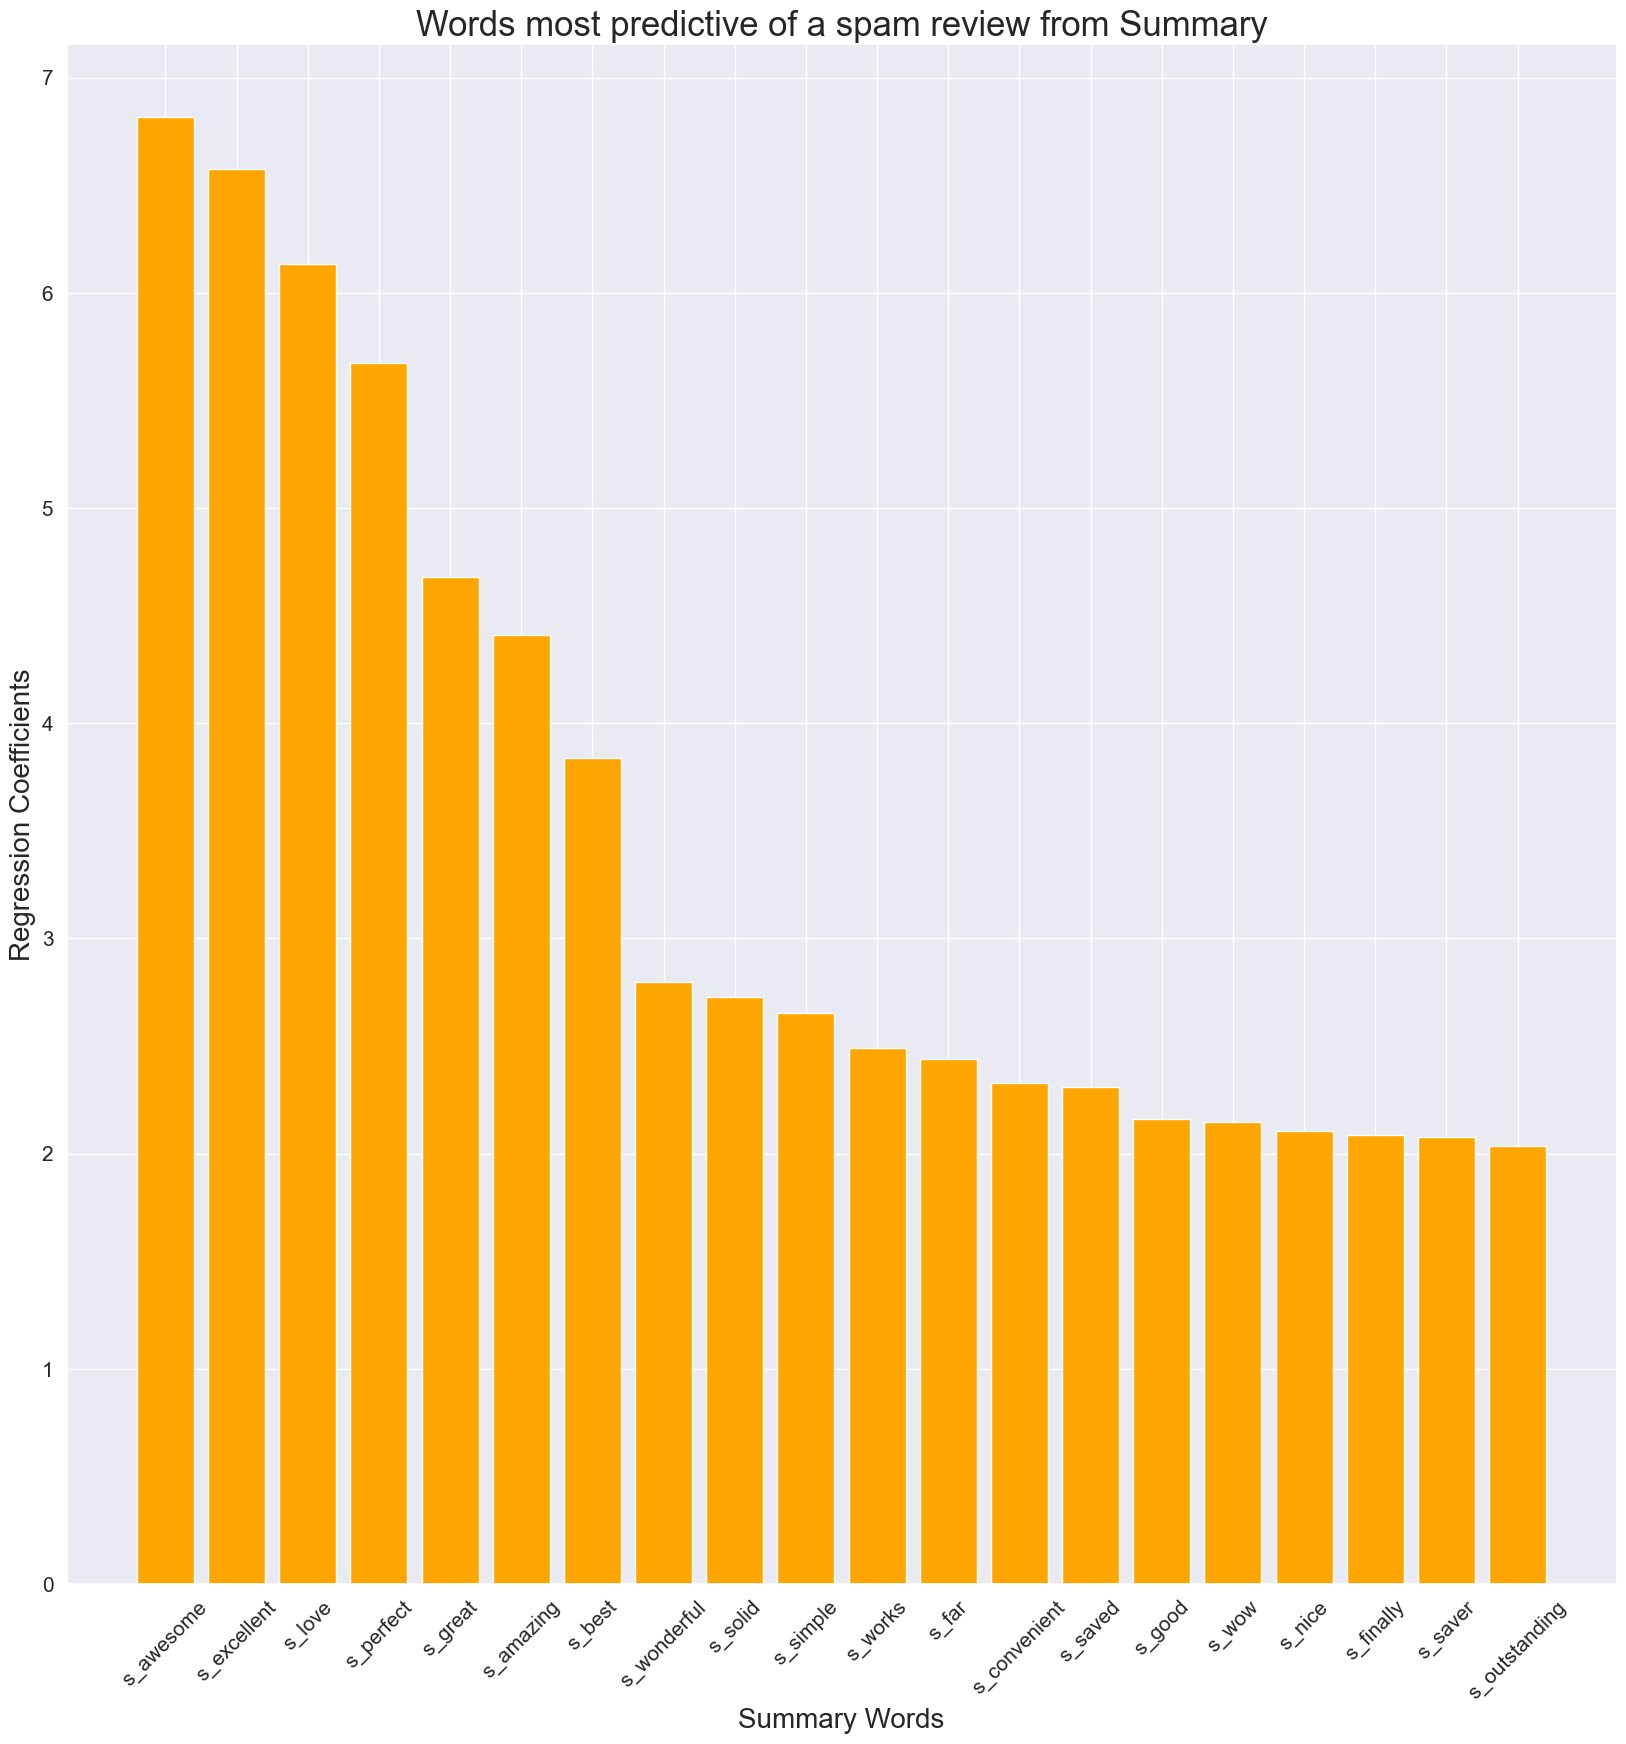

In [122]:
#20 words most predictive of a good review
plt.figure(figsize=(20,20))
plt.bar(summary_words['Features'].head(20), summary_words['Regression Coefficients'].head(20), color='orange')
plt.xlabel('Summary Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a spam review from Summary', fontsize=25)
plt.show()

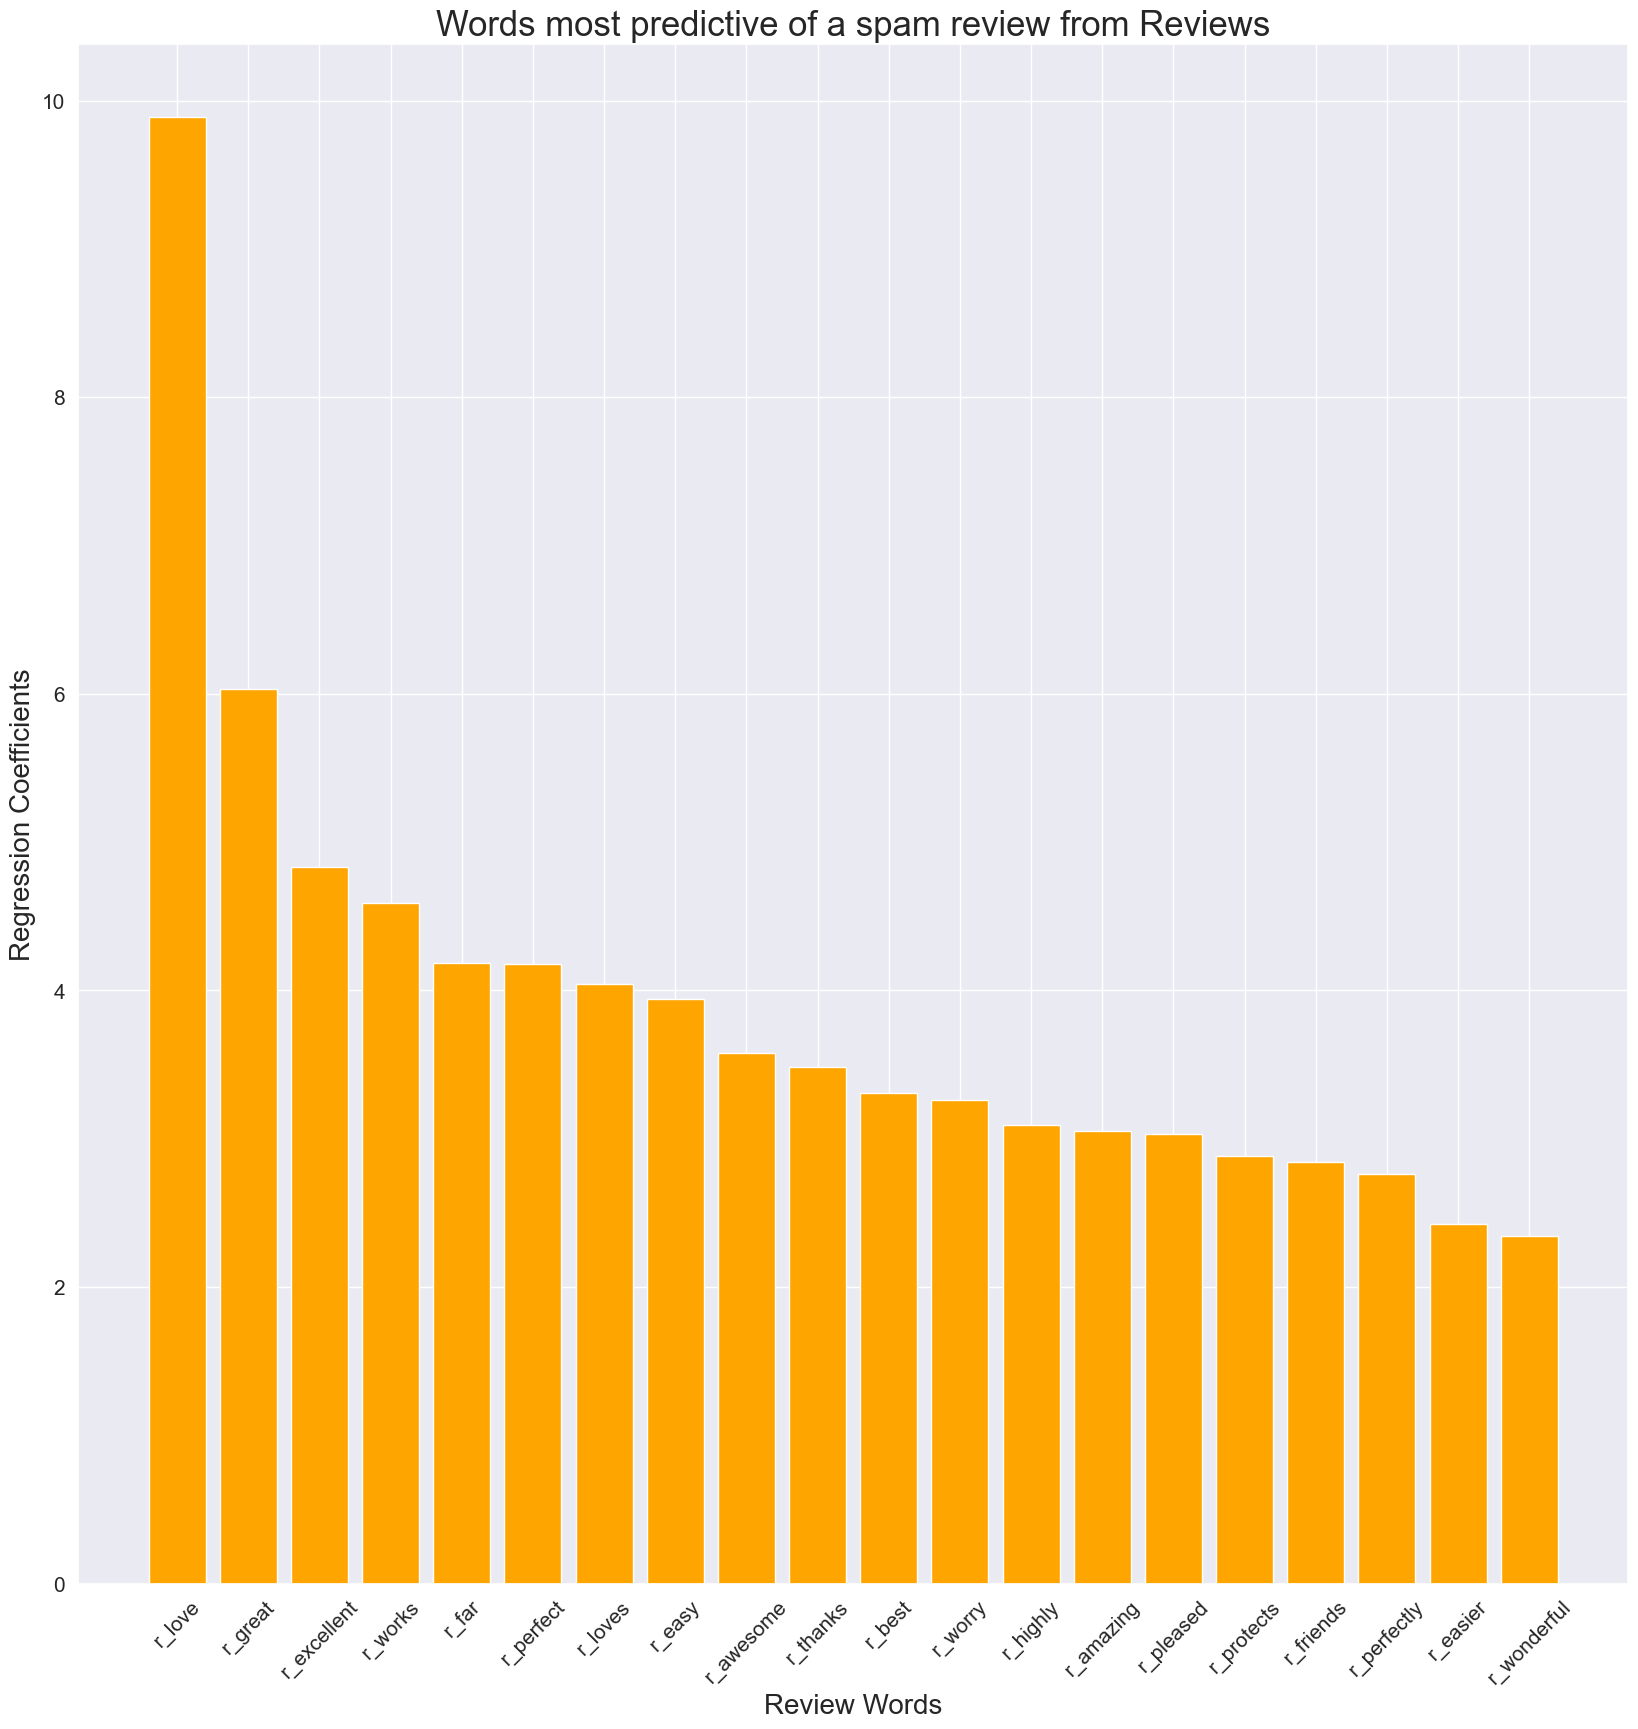

In [123]:
#20 words most predictive of a spam review
plt.figure(figsize=(20,20))
plt.bar(review_words['Features'].head(20), review_words['Regression Coefficients'].head(20), color='orange')
plt.xlabel('Review Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a spam review from Reviews', fontsize=25)
plt.show()

There is a lot of overlap in the words indicative of a spam review from the `summary` and `reviewText` columns.

Some of the overlapping words:
- great
- love
- excellent
- amazing
- perfect

It is interesting to see that these are all very positive words. This could be a method employed by the spam reviewers to always use the best and most positive words in order to catch the attention of potential customers going through the products reviews trying to decide if this ia a product worth buying or not. It seems like the spam reviewers are trying very hard to up-sell the product by showering it with constant praise and positivity.

Lets plot the words that were indicating real reviews:

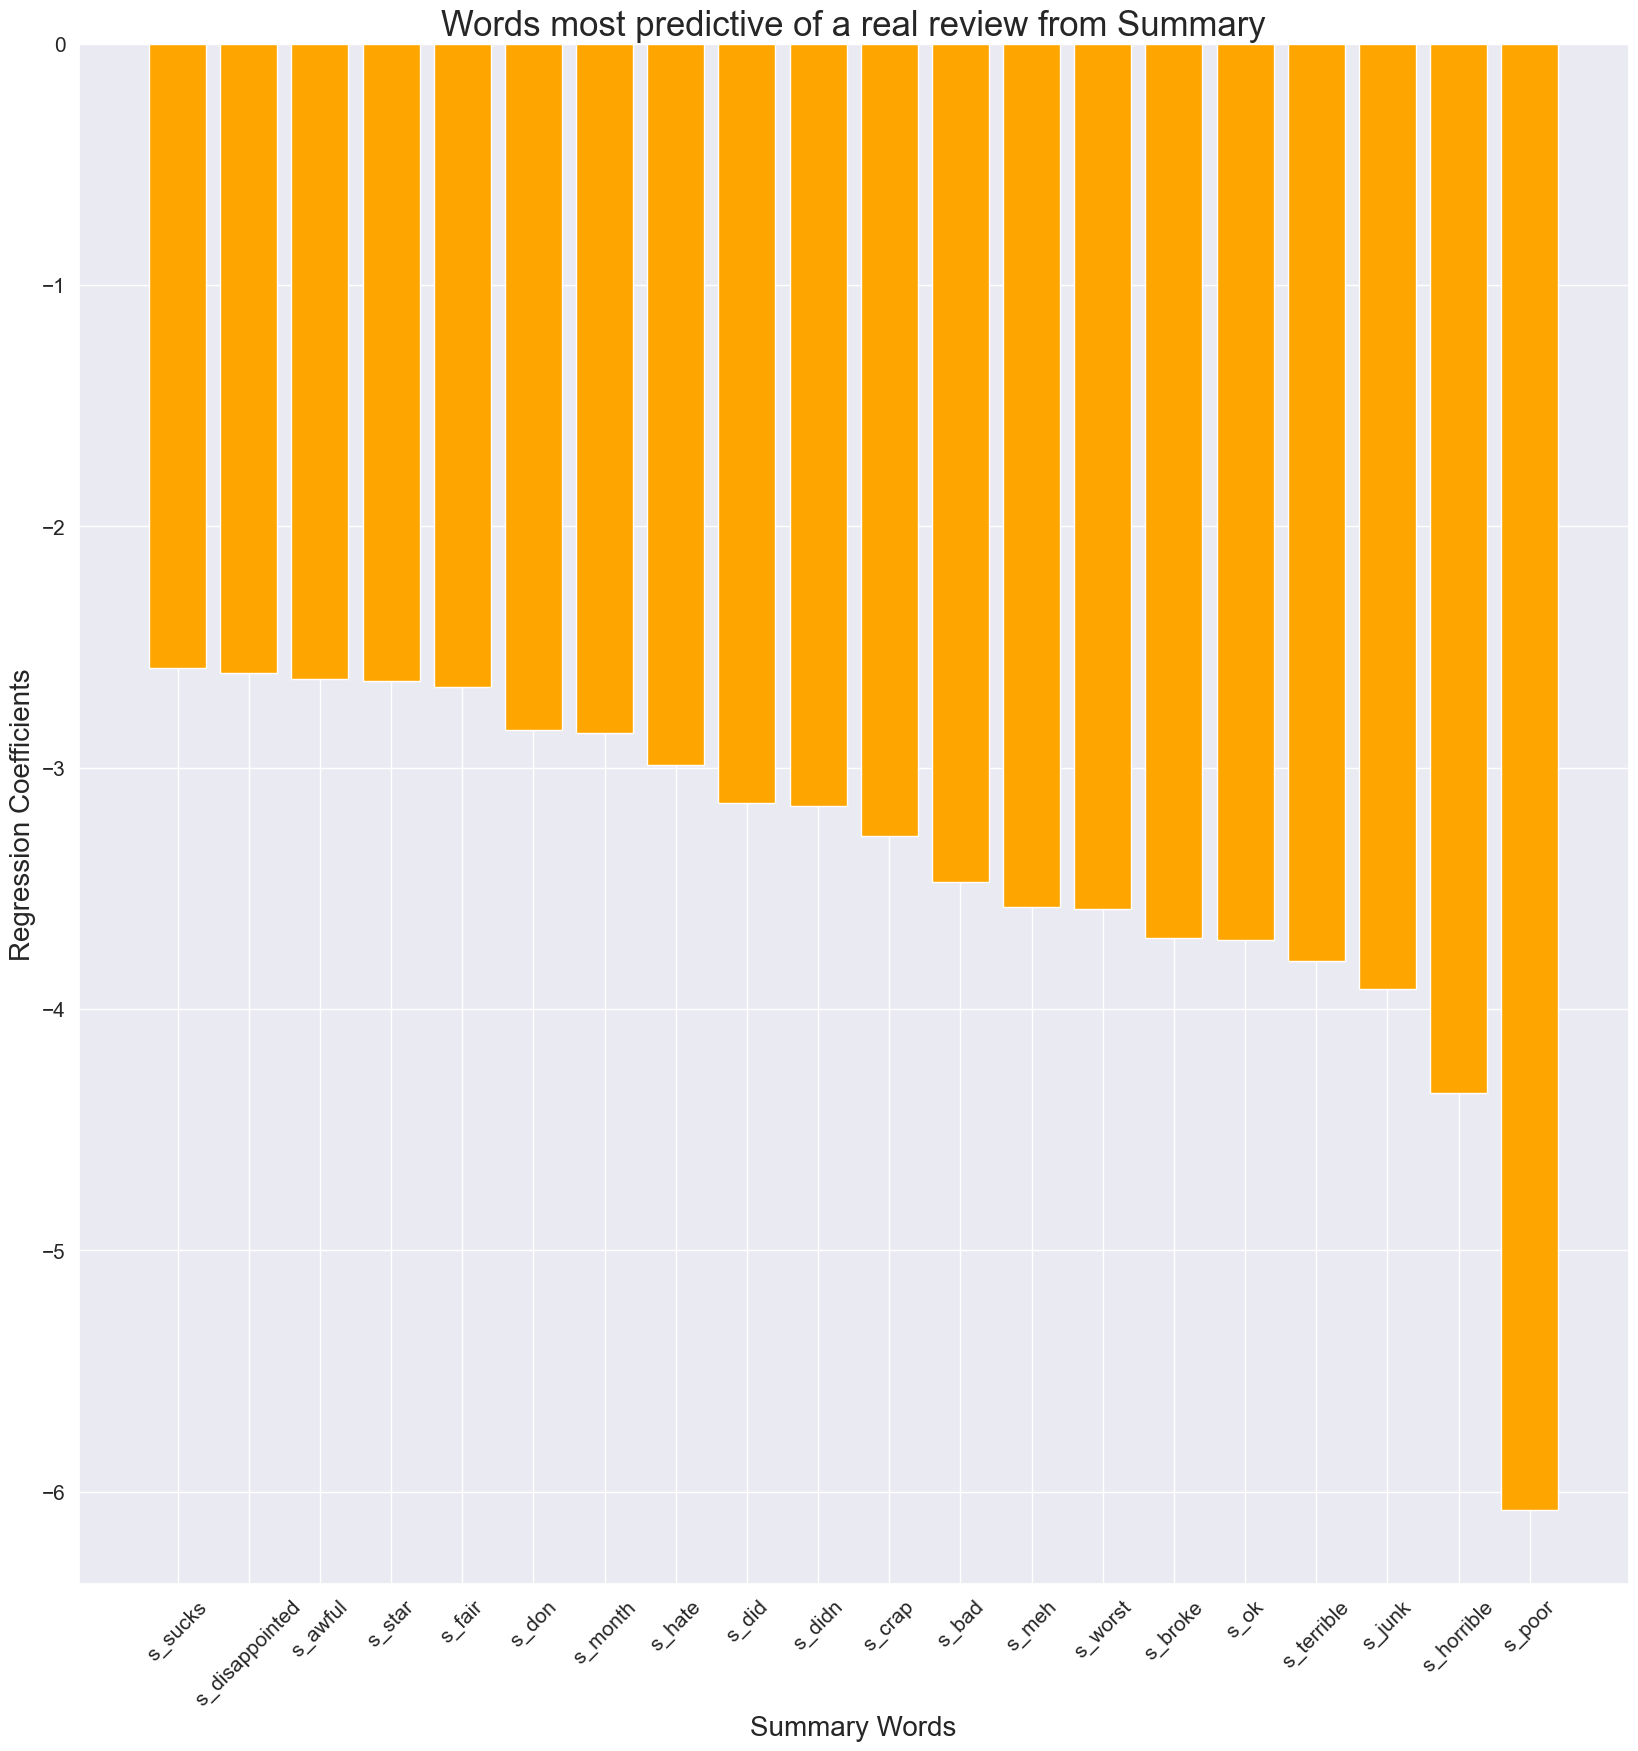

In [124]:
#20 words most predictive of a good review
plt.figure(figsize=(20,20))
plt.bar(summary_words['Features'].tail(20), summary_words['Regression Coefficients'].tail(20), color='orange')
plt.xlabel('Summary Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a real review from Summary', fontsize=25)
plt.show()

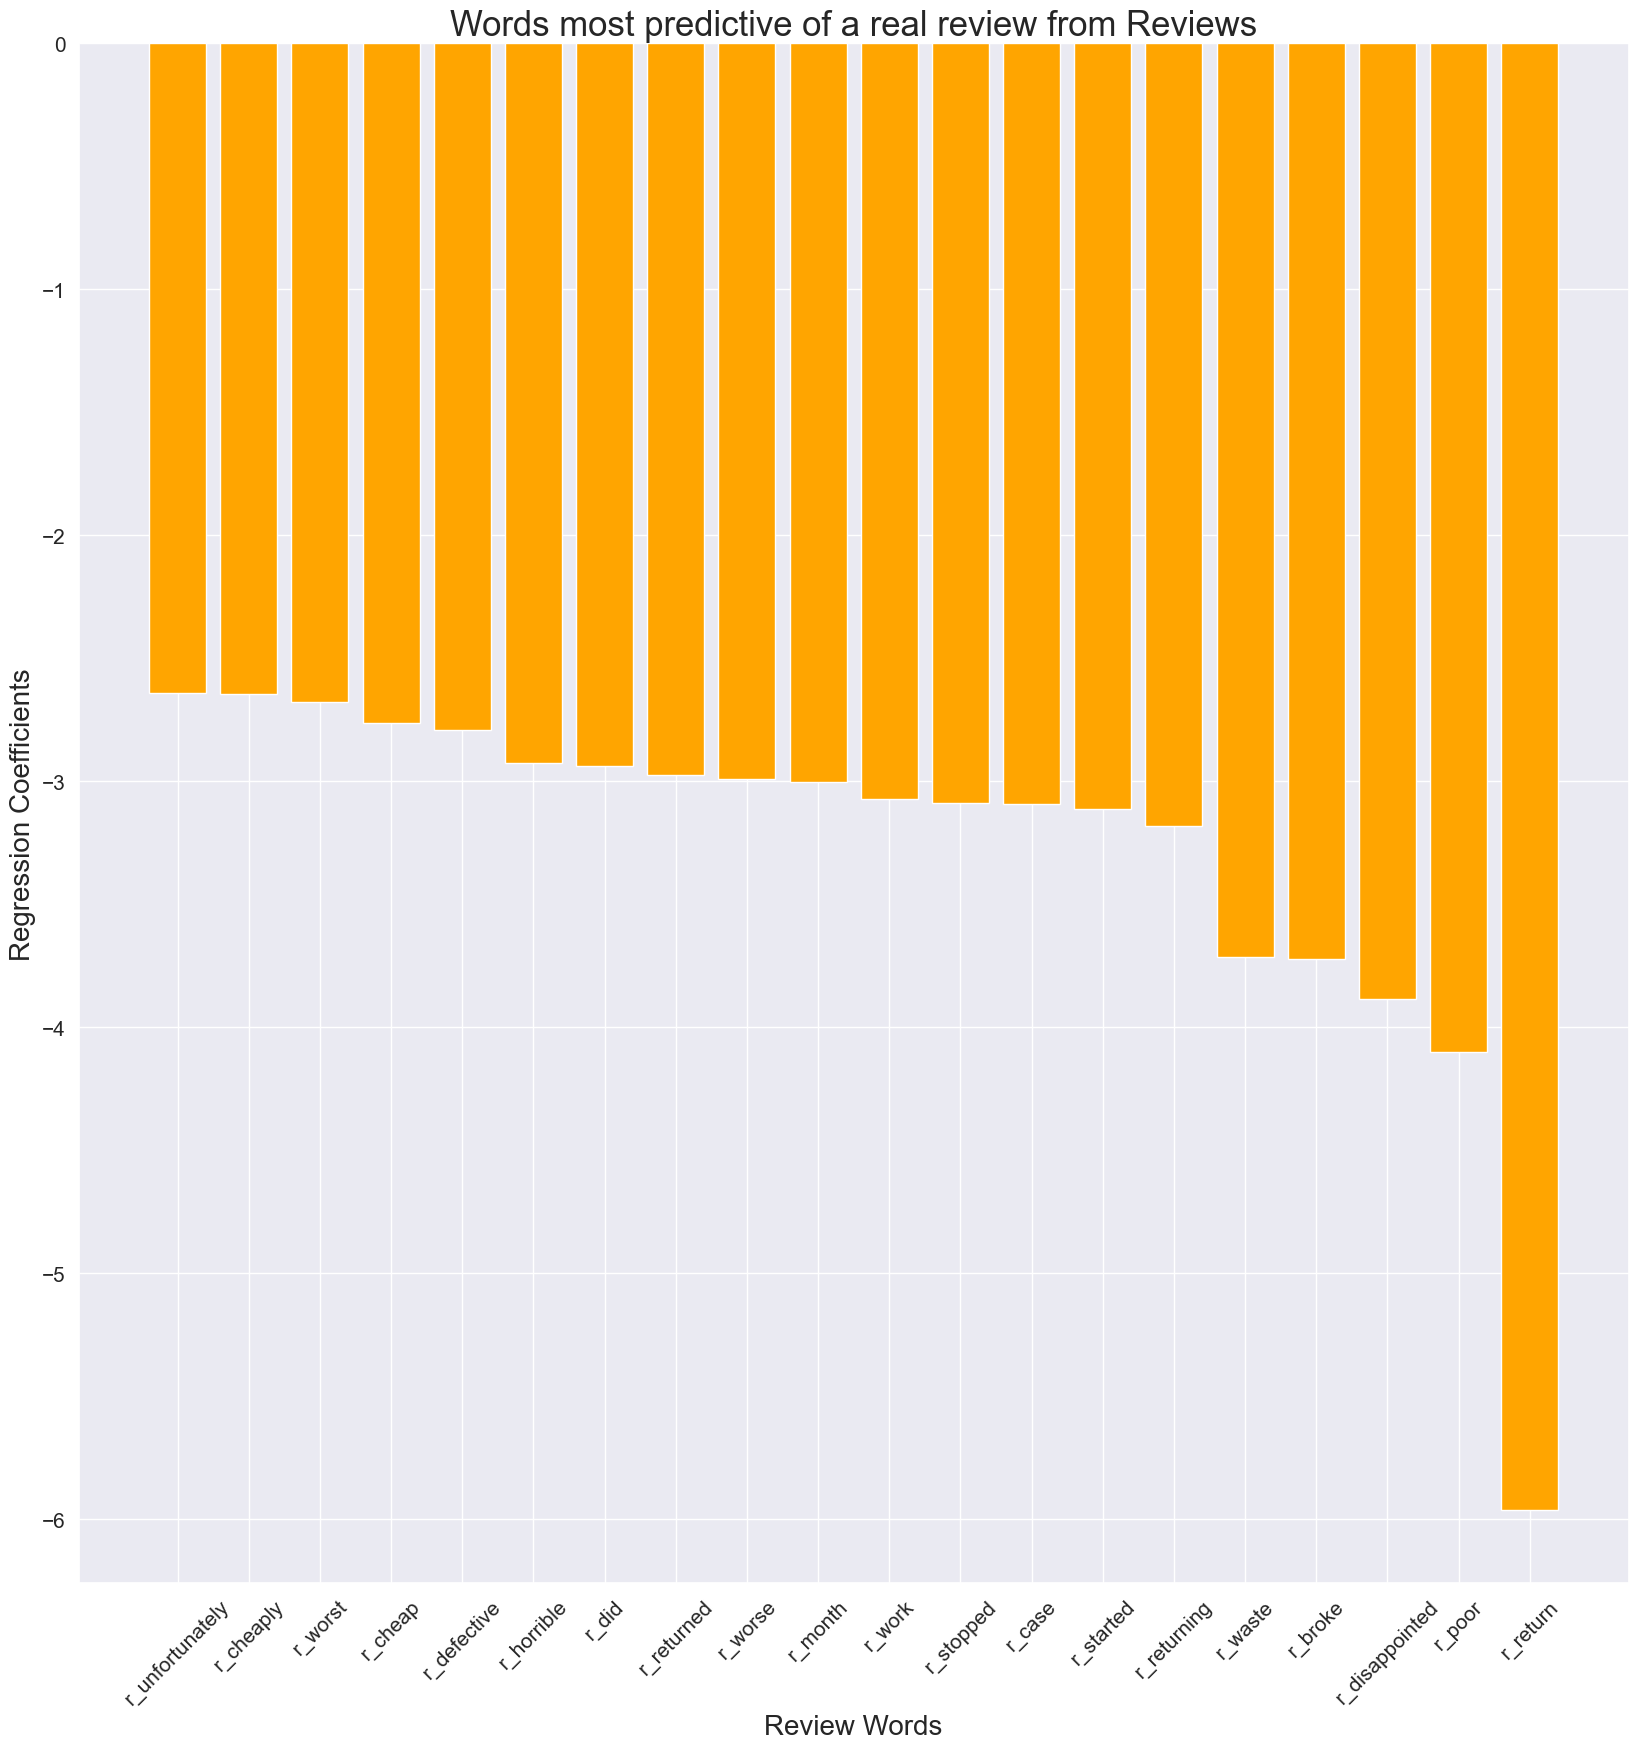

In [125]:
#20 words most predictive of a spam review
plt.figure(figsize=(20,20))
plt.bar(review_words['Features'].tail(20), review_words['Regression Coefficients'].tail(20), color='orange')
plt.xlabel('Review Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a real review from Reviews', fontsize=25)
plt.show()

Once again, there is a lot of overlap in the words indicative of a real review from the `summary` and `reviewText` columns.

Some of the overlapping words:
- terrible
- worst
- disappointed
- poor

It is interesting to see that these are all quite negative words. These reviews are most likely indicating the true nature of the product based on their real-world experience/usage of the product, warning potential customers to not purchase this product and stay away from it.

Seems like the spam reviews have been posted to push/draw attention away from the real reviews, in order to dupe a customer into purchasing a sub-par product.

Lets run a LogisticRegression on the vectorized dataset now:

### Baseline LogisticRegression on Vectorized Summary Dataset

Before fitting the model the `summary` vectorised dataframes created earlier need to be scaled.

A MinMaxScaler will be used for the scaling since majority of the data is binary.
Lets scale the data:

In [126]:
#Import the scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [127]:
#First we need to scale the data
#Majority of data is binary so the MinMaxScaler will be used
scaler = MinMaxScaler()

In [128]:
scaler.fit(summary_rem_df)

MinMaxScaler()

In [129]:
summary_rem_scaled = scaler.transform(summary_rem_df)
summary_test_scaled = scaler.transform(summary_test_df)

The data has been scaled.

Lets start modelling:

In [130]:
# 1. Instantiate model
base_logit_sum = LogisticRegression(random_state=1)

In [131]:
#2. Fit model
base_logit_sum.fit(summary_rem_scaled, y_remainder)

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [132]:
# 3. Score model
print(f'Score on remainder: {base_logit_sum.score(summary_rem_scaled, y_remainder)}')
print(f'Score on test: {base_logit_sum.score(summary_test_scaled, y_test)}')

Score on remainder: 0.8366497992112514
Score on test: 0.8323038783142149


### Baseline LogisticRegression on Vectorised Review Dataset

Before fitting the model the `review` vectorised dataframes created earlier need to be scaled.

A MinMaxScaler will be used for the scaling since majority of the data is binary.
Lets scale the data:

In [133]:
#Import the scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [134]:
#First we need to scale the data
#Majority of data is binary so the MinMaxScaler will be used
scaler = MinMaxScaler()

In [135]:
scaler.fit(review_rem_df)

MinMaxScaler()

In [136]:
review_rem_scaled = scaler.transform(review_rem_df)
review_test_scaled = scaler.transform(review_test_df)

The data has been scaled.

Lets start modelling:

In [137]:
# 1. Instantiate model
base_logit_rev = LogisticRegression(random_state=1)

In [138]:
#2. Fit model
base_logit_rev.fit(review_rem_scaled, y_remainder)

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [139]:
# 3. Score model
print(f'Score on remainder: {base_logit_rev.score(review_rem_scaled, y_remainder)}')
print(f'Score on test: {base_logit_rev.score(review_test_scaled, y_test)}')

Score on remainder: 0.8572328969404477
Score on test: 0.8492793814866171


### Baseline LogisticRegression on Vectorised Summary+Review Dataset

Before fitting the model the `summary+review` vectorised dataframes created earlier need to be scaled.

A MinMaxScaler will be used for the scaling since majority of the data is binary.
Lets scale the data:

In [140]:
#Import the scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [141]:
#First we need to scale the data
#Majority of data is binary so the MinMaxScaler will be used
scaler = MinMaxScaler()

In [142]:
scaler.fit(rev_sum_rem_df)

MinMaxScaler()

In [143]:
rev_sum_rem_scaled = scaler.transform(rev_sum_rem_df)
rev_sum_test_scaled = scaler.transform(rev_sum_test_df)

The data has been scaled.

Lets start modelling:

In [144]:
# 1. Instantiate model
base_logit_rev_sum = LogisticRegression(solver='lbfgs', random_state=1)

In [145]:
#2. Fit model
base_logit_rev_sum.fit(rev_sum_rem_scaled, y_remainder)

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [146]:
# 3. Score model
print(f'Score on remainder: {base_logit_rev_sum.score(rev_sum_rem_scaled, y_remainder)}')
print(f'Score on test: {base_logit_rev_sum.score(rev_sum_test_scaled, y_test)}')

Score on remainder: 0.8973546307467901
Score on test: 0.8859195764527922


Summary of LogisticRegression Results:
| Dataset                     | Remainder Accuracy (%) | Test Accuracy (%) |
|-----------------------------|------------------------|-------------------|
| Combined Vectorized         |          89.80         |       88.57       |
| Summary Vectorized          |          83.66         |       83.23       |
| Review Vectorized           |          85.72         |       84.93       |
| Summary + Review Vectorized |          89.73         |       88.60       |

As seen from the summary of results, the combined vectorized dataset gave the highest accuracy overall, while the summary + review vectorized dataset was just ~0.1% less accurate on the remainder set, while being equally as accurate on the test set..

Moving forward only the combined vectorized dataset will be used for modelling since it gave the highest overall accuracy.

Lets plot a confusion matrix for the results of the combined vectorized dataset:

### Confusion Matrix for the LogisticRegression on the Combined Vectorised dataset

In [147]:
#Import the confusion matrix libraries
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [148]:
# Get class predictions
y_pred = base_logit_comb.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Real Reviews", "Predicted Spam Reviews"],
    index=["True Real Reviews", "True Spam Reviews"]
)

display(cf_df)

Predicted Real Reviews  Predicted Spam Reviews
True Real Reviews                    5236                    1808
True Spam Reviews                     912                   15843

Text(0.5, 1.0, 'Original Confusion Matrix')

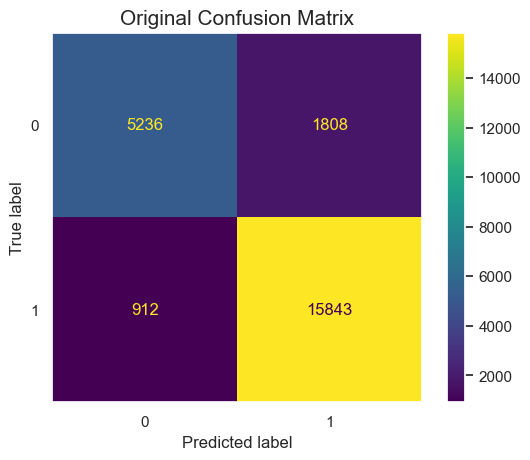

In [149]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(base_logit_comb, X_test_scaled, y_test)
plt.grid(False)
plt.title('Original Confusion Matrix', fontsize=15)

Summary of Confusion Matrix:
| Classification      | Total |
|---------------------|-------|
| True Negative (TN)  | 5236  |
| True Positive (TP)  | 15843 |
| False Negative (FN) | 912   |
| False Positive (FP) | 1808  |

Based on the initial interpretation of the confusion matrix, it seems like the model performed quite well.

The total of the True Values (TN + TP) is much higher than the total of the False Values (FN + FP) indicating high accuracy.

But with regards to review detection we would want a higher recall rate(how well the model identified the positive/negative reviews correctly vs the total positive/negative reviews in the dataset).

These will be checked via the classification report:

In [150]:
#Importing the classification report library
from sklearn.metrics import classification_report

In [151]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      7044
           1       0.90      0.95      0.92     16755

    accuracy                           0.89     23799
   macro avg       0.87      0.84      0.86     23799
weighted avg       0.88      0.89      0.88     23799



As predicted we have a good accuracy of 89%, and surprisingly enough a decent recall rate of 74% for the real reviews and 95% for the spam reviews.

The difference between the True Positive and False Positive rates might be due to a class imbalance in the dataset.

We can try to improve the recall rate by adjusting the y_proba threshold.

Lets take a look at how much the recall would improve if we adjusted the y_proba rate to 0.2 from the default value of 0.5:

In [152]:
# Importing precision and recall score libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [153]:
# Make probabilistic predictions (scores)
y_proba = base_logit_comb.predict_proba(X_test_scaled)[:,1]

In [154]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.8975695428021075
Recall score: 0.9455684870188004

Threshold of 0.2:
Precision score: 0.8260434390951856
Recall score: 0.9851387645478962


Summary of results:
1. Threshold goes down
2. We predict more samples as spam
3. We get more false positives which drives the precision down
4. We get more true positives that drive the recall up

So by reducing our y_proba threshold from 0.5 to 0.2, we are seeing a ~4% increase in the recall, but we also have a ~7% drop in the accuracy.

### Vectorisation using TF-IDF model

In [155]:
# Importing the TF-IDF library
from sklearn.feature_extraction.text import TfidfVectorizer

We have already created dataframes for the `summary` and `reviewText` columns extracted from the X_remainder and X_test sets. Those dataframes can be vectorized via the TF-IDF model. The min_df and max_features parameters will be kept the same as set in the Bag-of-Words model.

The dataframes to be vectorized are:
| Column                   | Remainder DF   | Test DF         | min_df          | max_features |
|--------------------------|----------------|-----------------|-----------------|--------------|
| summary                  | summ_words_rem | summ_words_test | 15              | 1000         |
| reviewText               |  rev_words_rem | rev_words_test  | 40              | 1000         |

Lets start with the `summary` dataframes:

### Vectorizing Summary Column

In [156]:
# 1. Instantiate 
summary_rem_tfidf = TfidfVectorizer(stop_words='english', min_df=15, max_features=1000)

# 2. Fit 
summary_rem_tfidf.fit(summ_words_rem['summary'])

# 3. Transform
summary_rem_transformed = summary_rem_tfidf.transform(summ_words_rem['summary'])
summary_test_transformed = summary_rem_tfidf.transform(summ_words_test['summary'])

In [157]:
summary_rem_transformed

<55531x890 sparse matrix of type '<class 'numpy.float64'>'
	with 115920 stored elements in Compressed Sparse Row format>

In [158]:
summary_test_transformed

<23799x890 sparse matrix of type '<class 'numpy.float64'>'
	with 49805 stored elements in Compressed Sparse Row format>

In [159]:
#Checking the total number of unique words present in the summary column
len(summary_rem_bagofwords.get_feature_names())

890

In [160]:
# Creating a dataframe from the vectorized sparse matrix
# Summary column from X_remainder set
summary_rem_df_tfidf = pd.DataFrame(summary_rem_transformed.toarray(), columns= summary_rem_tfidf.get_feature_names(), index=X_remainder.index)
summary_rem_df_tfidf

10  100  2nd   30   3d   3g  3gs   4g   4s   50  ...  wrong  yay  \
10246  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
74664  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
11343  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
71940  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
21699  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...  ...   
31233  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
11620  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
37006  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
41060  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
76895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   

       year  years  yellow  yes  zagg  zebra  zero  zte  
10246   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
74664   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
11343   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
71940   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
21699   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
...     ...    ...     ...  ...   ...    ...   ...  ...  
31233   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
11620   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
37006   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
41060   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
76895   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  

[55531 rows x 890 columns]

Sanity checks:

In [161]:
#Checking the shape of the summary dataframe
print(f'There are {summary_rem_df_tfidf.shape[0]} rows, and {summary_rem_df_tfidf.shape[1]} columns in the X_remainder summary dataframe')

There are 55531 rows, and 890 columns in the X_remainder summary dataframe


In [162]:
#Checking the number of rows is matching between the summary df and the X_remainder
summary_rem_df_tfidf.shape[0] == X_remainder.shape[0]

True

In [163]:
#Checking for any missing data
summary_rem_df_tfidf.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

In [164]:
# Creating a dataframe from the vectorized sparse matrix
#Summary column from X_test set
summary_test_df_tfidf = pd.DataFrame(summary_test_transformed.toarray(), columns= summary_rem_tfidf.get_feature_names(), index=X_test.index)
summary_test_df_tfidf

10  100  2nd   30   3d   3g  3gs   4g   4s   50  ...  wrong  yay  \
73697  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
39485  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
38104  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
26576  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
18562  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...  ...   
78017  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
2525   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
3169   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
35991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   
33848  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0   

       year  years  yellow  yes  zagg  zebra  zero  zte  
73697   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
39485   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
38104   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
26576   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
18562   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
...     ...    ...     ...  ...   ...    ...   ...  ...  
78017   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
2525    0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
3169    0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
35991   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  
33848   0.0    0.0     0.0  0.0   0.0    0.0   0.0  0.0  

[23799 rows x 890 columns]

Sanity checks:

In [165]:
#Checking the shape of the summary dataframe
print(f'There are {summary_test_df_tfidf.shape[0]} rows, and {summary_test_df_tfidf.shape[1]} columns in the X_test summary dataframe')

There are 23799 rows, and 890 columns in the X_test summary dataframe


In [166]:
#Checking the number of rows is matching between the summary df and the X_remainder
summary_test_df_tfidf.shape[0] == X_test.shape[0]

True

In [167]:
#Checking for any missing data
summary_test_df_tfidf.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

Now, a prefix of `s_` will be added to the columns for both summary dataframes. This will help with identifying the words vectorized from the summary columns versus the review column, which will be done after this:

In [168]:
#Adding prefix to remainder summary DF
summary_rem_df_tfidf = summary_rem_df_tfidf.add_prefix('s_')
summary_rem_df_tfidf

s_10  s_100  s_2nd  s_30  s_3d  s_3g  s_3gs  s_4g  s_4s  s_50  ...  \
10246   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
74664   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
11343   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
71940   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
21699   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
...     ...    ...    ...   ...   ...   ...    ...   ...   ...   ...  ...   
31233   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
11620   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
37006   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
41060   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
76895   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   

       s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
10246      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
74664      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
11343      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
71940      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
21699      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
...        ...    ...     ...      ...       ...    ...     ...      ...   
31233      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
11620      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
37006      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
41060      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
76895      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   

       s_zero  s_zte  
10246     0.0    0.0  
74664     0.0    0.0  
11343     0.0    0.0  
71940     0.0    0.0  
21699     0.0    0.0  
...       ...    ...  
31233     0.0    0.0  
11620     0.0    0.0  
37006     0.0    0.0  
41060     0.0    0.0  
76895     0.0    0.0  

[55531 rows x 890 columns]

In [169]:
#Adding prefix to test summary DF
summary_test_df_tfidf = summary_test_df_tfidf.add_prefix('s_')
summary_test_df_tfidf

s_10  s_100  s_2nd  s_30  s_3d  s_3g  s_3gs  s_4g  s_4s  s_50  ...  \
73697   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
39485   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
38104   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
26576   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
18562   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
...     ...    ...    ...   ...   ...   ...    ...   ...   ...   ...  ...   
78017   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
2525    0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
3169    0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
35991   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   
33848   0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0  ...   

       s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
73697      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
39485      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
38104      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
26576      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
18562      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
...        ...    ...     ...      ...       ...    ...     ...      ...   
78017      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
2525       0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
3169       0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
35991      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
33848      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   

       s_zero  s_zte  
73697     0.0    0.0  
39485     0.0    0.0  
38104     0.0    0.0  
26576     0.0    0.0  
18562     0.0    0.0  
...       ...    ...  
78017     0.0    0.0  
2525      0.0    0.0  
3169      0.0    0.0  
35991     0.0    0.0  
33848     0.0    0.0  

[23799 rows x 890 columns]

The summary dataframes have been updated with a column prefix of `s_` for all columns.

### Vectorizing reviewText column

In [170]:
# 1. Instantiate 
review_rem_tfidf = TfidfVectorizer(stop_words='english', min_df=40, max_features=1000)

# 2. Fit 
review_rem_tfidf.fit(rev_words_rem['reviewText'])

# 3. Transform
review_rem_transformed = review_rem_tfidf.transform(rev_words_rem['reviewText'])
review_test_transformed = review_rem_tfidf.transform(rev_words_test['reviewText'])

Sanity check for matching number of columns in the transformed data:

In [171]:
review_rem_transformed

<55531x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 944301 stored elements in Compressed Sparse Row format>

In [172]:
review_test_transformed

<23799x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 406485 stored elements in Compressed Sparse Row format>

In [173]:
#Checking the total number of unique words present in the summary column
len(review_rem_bagofwords.get_feature_names())

1000

In [174]:
# Creating a dataframe from the vectorized sparse matrix
#Review column from X_remainder set
review_rem_df_tfidf = pd.DataFrame(review_rem_transformed.toarray(), columns= review_rem_tfidf.get_feature_names(), index=X_remainder.index)
review_rem_df_tfidf

00   10  100   12   15        20        30   34   3g  3gs  ...  worse  \
10246  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
74664  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
11343  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
71940  0.0  0.0  0.0  0.0  0.0  0.000000  0.266453  0.0  0.0  0.0  ...    0.0   
21699  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
...    ...  ...  ...  ...  ...       ...       ...  ...  ...  ...  ...    ...   
31233  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
11620  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
37006  0.0  0.0  0.0  0.0  0.0  0.341621  0.000000  0.0  0.0  0.0  ...    0.0   
41060  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   
76895  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...    0.0   

       worst  worth  wouldn  write     wrong  year  years  yes  youtube  
10246    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
74664    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
11343    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
71940    0.0    0.0     0.0    0.0  0.245856   0.0    0.0  0.0      0.0  
21699    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
...      ...    ...     ...    ...       ...   ...    ...  ...      ...  
31233    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
11620    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
37006    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
41060    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  
76895    0.0    0.0     0.0    0.0  0.000000   0.0    0.0  0.0      0.0  

[55531 rows x 1000 columns]

Sanity checks:

In [175]:
#Checking the shape of the summary dataframe
print(f'There are {review_rem_df_tfidf.shape[0]} rows, and {review_rem_df_tfidf.shape[1]} columns in the X_test summary dataframe')

There are 55531 rows, and 1000 columns in the X_test summary dataframe


In [176]:
#Checking the number of rows is matching between the summary df and the X_remainder
review_rem_df_tfidf.shape[0] == X_remainder.shape[0]

True

In [177]:
#Checking for any missing data
review_rem_df_tfidf.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

In [178]:
#Summary column from X_test set
review_test_df_tfidf = pd.DataFrame(review_test_transformed.toarray(), columns= review_rem_tfidf.get_feature_names(), index=X_test.index)
review_test_df_tfidf

00   10  100   12   15        20   30        34   3g  3gs  ...  worse  \
73697  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
39485  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
38104  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
26576  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
18562  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
...    ...  ...  ...  ...  ...       ...  ...       ...  ...  ...  ...    ...   
78017  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
2525   0.0  0.0  0.0  0.0  0.0  0.204161  0.0  0.000000  0.0  0.0  ...    0.0   
3169   0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.289831  0.0  0.0  ...    0.0   
35991  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   
33848  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  ...    0.0   

       worst  worth    wouldn  write  wrong  year  years  yes  youtube  
73697    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
39485    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
38104    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
26576    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
18562    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
...      ...    ...       ...    ...    ...   ...    ...  ...      ...  
78017    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
2525     0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
3169     0.0    0.0  0.304769    0.0    0.0   0.0    0.0  0.0      0.0  
35991    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  
33848    0.0    0.0  0.000000    0.0    0.0   0.0    0.0  0.0      0.0  

[23799 rows x 1000 columns]

Sanity checks:

In [179]:
#Checking the shape of the summary dataframe
print(f'There are {review_test_df_tfidf.shape[0]} rows, and {review_test_df_tfidf.shape[1]} columns in the X_test summary dataframe')

There are 23799 rows, and 1000 columns in the X_test summary dataframe


In [180]:
#Checking the number of rows is matching between the summary df and the X_remainder
review_test_df_tfidf.shape[0] == X_test.shape[0]

True

In [181]:
#Checking for any missing data
summary_test_df_tfidf.isna().sum().sum()

0

Great, the dataframe has been created properly without any missing data

Now, a prefix of `r_` will be added to the columns for both reviewText dataframes. This will help with identifying the words vectorized from the reviewText columns versus the summary column, which was done prior to this:

In [182]:
#Adding prefix to remainder summary DF
review_rem_df_tfidf = review_rem_df_tfidf.add_prefix('r_')
review_rem_df_tfidf

r_00  r_10  r_100  r_12  r_15      r_20      r_30  r_34  r_3g  r_3gs  \
10246   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
74664   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
11343   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
71940   0.0   0.0    0.0   0.0   0.0  0.000000  0.266453   0.0   0.0    0.0   
21699   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
...     ...   ...    ...   ...   ...       ...       ...   ...   ...    ...   
31233   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
11620   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
37006   0.0   0.0    0.0   0.0   0.0  0.341621  0.000000   0.0   0.0    0.0   
41060   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
76895   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   

       ...  r_worse  r_worst  r_worth  r_wouldn  r_write   r_wrong  r_year  \
10246  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
74664  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
11343  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
71940  ...      0.0      0.0      0.0       0.0      0.0  0.245856     0.0   
21699  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
...    ...      ...      ...      ...       ...      ...       ...     ...   
31233  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
11620  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
37006  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
41060  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   
76895  ...      0.0      0.0      0.0       0.0      0.0  0.000000     0.0   

       r_years  r_yes  r_youtube  
10246      0.0    0.0        0.0  
74664      0.0    0.0        0.0  
11343      0.0    0.0        0.0  
71940      0.0    0.0        0.0  
21699      0.0    0.0        0.0  
...        ...    ...        ...  
31233      0.0    0.0        0.0  
11620      0.0    0.0        0.0  
37006      0.0    0.0        0.0  
41060      0.0    0.0        0.0  
76895      0.0    0.0        0.0  

[55531 rows x 1000 columns]

In [183]:
#Adding prefix to test summary DF
review_test_df_tfidf = review_test_df_tfidf.add_prefix('r_')
review_test_df_tfidf

r_00  r_10  r_100  r_12  r_15      r_20  r_30      r_34  r_3g  r_3gs  \
73697   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
39485   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
38104   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
26576   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
18562   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
...     ...   ...    ...   ...   ...       ...   ...       ...   ...    ...   
78017   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
2525    0.0   0.0    0.0   0.0   0.0  0.204161   0.0  0.000000   0.0    0.0   
3169    0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.289831   0.0    0.0   
35991   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
33848   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   

       ...  r_worse  r_worst  r_worth  r_wouldn  r_write  r_wrong  r_year  \
73697  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
39485  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
38104  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
26576  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
18562  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
...    ...      ...      ...      ...       ...      ...      ...     ...   
78017  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
2525   ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
3169   ...      0.0      0.0      0.0  0.304769      0.0      0.0     0.0   
35991  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   
33848  ...      0.0      0.0      0.0  0.000000      0.0      0.0     0.0   

       r_years  r_yes  r_youtube  
73697      0.0    0.0        0.0  
39485      0.0    0.0        0.0  
38104      0.0    0.0        0.0  
26576      0.0    0.0        0.0  
18562      0.0    0.0        0.0  
...        ...    ...        ...  
78017      0.0    0.0        0.0  
2525       0.0    0.0        0.0  
3169       0.0    0.0        0.0  
35991      0.0    0.0        0.0  
33848      0.0    0.0        0.0  

[23799 rows x 1000 columns]

The reviewText dataframes have been updated with a column prefix of `r_` for all columns.

Now, the summary and review dataframes from the remainder and test sets will be joined with the original `X_remainder` and `X_test` sets.

After these dataframes have been combined, the original `summary` and `reviewText` columns from the `X_remainder` and `X_test` sets will be dropped before running a LogisticRegression to determine the baseline model accuracy.

Lets combine the `summary` and `reviewText` dataframes from the remainder set first:

### Combining TF-IDF vectorized summary column with vectorized reviewText column

In [184]:
#Joining the two dataframes
rev_sum_rem_df_tfidf = pd.concat([review_rem_df_tfidf, summary_rem_df_tfidf], axis=1)
rev_sum_rem_df_tfidf

r_00  r_10  r_100  r_12  r_15      r_20      r_30  r_34  r_3g  r_3gs  \
10246   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
74664   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
11343   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
71940   0.0   0.0    0.0   0.0   0.0  0.000000  0.266453   0.0   0.0    0.0   
21699   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
...     ...   ...    ...   ...   ...       ...       ...   ...   ...    ...   
31233   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
11620   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
37006   0.0   0.0    0.0   0.0   0.0  0.341621  0.000000   0.0   0.0    0.0   
41060   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   
76895   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   0.0   0.0    0.0   

       ...  s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
10246  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
74664  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
11343  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
71940  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
21699  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
...    ...      ...    ...     ...      ...       ...    ...     ...      ...   
31233  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
11620  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
37006  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
41060  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
76895  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   

       s_zero  s_zte  
10246     0.0    0.0  
74664     0.0    0.0  
11343     0.0    0.0  
71940     0.0    0.0  
21699     0.0    0.0  
...       ...    ...  
31233     0.0    0.0  
11620     0.0    0.0  
37006     0.0    0.0  
41060     0.0    0.0  
76895     0.0    0.0  

[55531 rows x 1890 columns]

Sanity Checks:

In [185]:
len(rev_sum_rem_df_tfidf) == len(X_remainder)

True

### Combining vectorised columns with original X_remainder and X_test datasets

In [186]:
#Joining the combined dataframe with the original remainder dataset
X_remainder_vect_tfidf = pd.concat([X_remainder, rev_sum_rem_df_tfidf], axis=1)
X_remainder_vect_tfidf

reviewText  \
10246  The case isn't quite as durable as I thought b...   
74664  A nice product that is well-designed and meets...   
11343  I really like the protection that this case of...   
71940  The adapter charged my phone on the first day ...   
21699  Does anyone know if they work with the otterbo...   
...                                                  ...   
31233  Bought this for my daughters new iphone she lo...   
11620  This is a really nice one! I do love it! It is...   
37006  The battery I received is not made by Samsung,...   
41060  Way cool!!!!!  This is more of a paintbrush th...   
76895  This charging unit is the nicest I've seen. It...   

                                                 summary  help_neg  help_pos  \
10246                                          cute case         0         0   
74664                                         Four Stars         0         0   
11343                               Protective but Bulky         2         1   
71940                                        Fell Apart!         0         0   
21699                                          Adorable!         0         0   
...                                                  ...       ...       ...   
31233                                         Good Price         0         0   
11620                                              Great         0         0   
37006  Shipped battery not the same as the one pictured.         2         1   
41060                                          Way cool!         0         0   
76895                               Cadillac of chargers         1         1   

       r_00  r_10  r_100  r_12  r_15      r_20  ...  s_wrong  s_yay  s_year  \
10246   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
74664   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
11343   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
71940   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
21699   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
...     ...   ...    ...   ...   ...       ...  ...      ...    ...     ...   
31233   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
11620   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
37006   0.0   0.0    0.0   0.0   0.0  0.341621  ...      0.0    0.0     0.0   
41060   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
76895   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   

       s_years  s_yellow  s_yes  s_zagg  s_zebra  s_zero  s_zte  
10246      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
74664      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
11343      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
71940      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
21699      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
...        ...       ...    ...     ...      ...     ...    ...  
31233      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
11620      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
37006      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
41060      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
76895      0.0       0.0    0.0     0.0      0.0     0.0    0.0  

[55531 rows x 1894 columns]

Sanity check to ensure the combined dataframe joined properly, and there was no loss in data:

In [187]:
#Checking number of rows are matching
print(X_remainder.shape[0])
print(summary_rem_df_tfidf.shape[0])
print(review_rem_df_tfidf.shape[0])

55531
55531
55531


In [188]:
X_remainder.shape[0] == summary_rem_df_tfidf.shape[0] == review_rem_df_tfidf.shape[0]

True

In [189]:
X_remainder.shape[1] + summary_rem_df_tfidf.shape[1] + review_rem_df_tfidf.shape[1]

1894

In [190]:
X_remainder_vect.shape

(55531, 1892)

Now that the summary and review vectorized dataframes have been joined with the X_remainder set, the original `summary` and `reviewText` columns can be dropped:

In [191]:
X_remainder_vect_tfidf.drop(columns=['summary', 'reviewText'], inplace= True)
X_remainder_vect_tfidf

help_neg  help_pos  r_00  r_10  r_100  r_12  r_15      r_20      r_30  \
10246         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
74664         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
11343         2         1   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
71940         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.266453   
21699         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
...         ...       ...   ...   ...    ...   ...   ...       ...       ...   
31233         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
11620         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
37006         2         1   0.0   0.0    0.0   0.0   0.0  0.341621  0.000000   
41060         0         0   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   
76895         1         1   0.0   0.0    0.0   0.0   0.0  0.000000  0.000000   

       r_34  ...  s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  \
10246   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
74664   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
11343   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
71940   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
21699   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
...     ...  ...      ...    ...     ...      ...       ...    ...     ...   
31233   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
11620   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
37006   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
41060   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   
76895   0.0  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0   

       s_zebra  s_zero  s_zte  
10246      0.0     0.0    0.0  
74664      0.0     0.0    0.0  
11343      0.0     0.0    0.0  
71940      0.0     0.0    0.0  
21699      0.0     0.0    0.0  
...        ...     ...    ...  
31233      0.0     0.0    0.0  
11620      0.0     0.0    0.0  
37006      0.0     0.0    0.0  
41060      0.0     0.0    0.0  
76895      0.0     0.0    0.0  

[55531 rows x 1892 columns]

Great, the original `summary` and `reviewText` columns have been dropped.

Now lets combine the `summary` and `reviewText` dataframes from the test set first:

In [192]:
#Joining the two dataframes
rev_sum_test_df_tfidf = pd.concat([review_test_df_tfidf, summary_test_df_tfidf], axis=1)
rev_sum_test_df_tfidf

r_00  r_10  r_100  r_12  r_15      r_20  r_30      r_34  r_3g  r_3gs  \
73697   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
39485   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
38104   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
26576   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
18562   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
...     ...   ...    ...   ...   ...       ...   ...       ...   ...    ...   
78017   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
2525    0.0   0.0    0.0   0.0   0.0  0.204161   0.0  0.000000   0.0    0.0   
3169    0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.289831   0.0    0.0   
35991   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   
33848   0.0   0.0    0.0   0.0   0.0  0.000000   0.0  0.000000   0.0    0.0   

       ...  s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  s_zagg  s_zebra  \
73697  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
39485  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
38104  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
26576  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
18562  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
...    ...      ...    ...     ...      ...       ...    ...     ...      ...   
78017  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
2525   ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
3169   ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
35991  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   
33848  ...      0.0    0.0     0.0      0.0       0.0    0.0     0.0      0.0   

       s_zero  s_zte  
73697     0.0    0.0  
39485     0.0    0.0  
38104     0.0    0.0  
26576     0.0    0.0  
18562     0.0    0.0  
...       ...    ...  
78017     0.0    0.0  
2525      0.0    0.0  
3169      0.0    0.0  
35991     0.0    0.0  
33848     0.0    0.0  

[23799 rows x 1890 columns]

In [193]:
#Joining the combined dataframe with the original remainder dataset
X_test_vect_tfidf = pd.concat([X_test, rev_sum_test_df_tfidf], axis=1)
X_test_vect_tfidf

reviewText  \
73697  This charger does NOT charge the Droid Eris HT...   
39485  These are fantastic batteries. I was a little ...   
38104  Its smells really bad. I couldn't use it,  I t...   
26576  We bought 3 of these cords and not one single ...   
18562  I just ordered another one of these because I ...   
...                                                  ...   
78017  Product was great. My little sister loved it. ...   
2525   Easy to put on, easy to work the side buttons ...   
3169   I wouldn&#34;t recommend this case to anyone. ...   
35991  It works like it should right out of the box! ...   
33848  I really wasn't expecting these to work on my ...   

                                                 summary  help_neg  help_pos  \
73697                                       doesn't work         2         2   
39485                                       Works great!         0         0   
38104        Looks cute. Smelled horrible. I trashed it.         0         0   
26576                             Terrible ~ do NOT buy!         0         0   
18562                                     The best case!         0         0   
...                                                  ...       ...       ...   
78017                                              loved         0         0   
2525                     makes it more secure in my hand         0         0   
3169                          Very unhappy. Poor quality         1         1   
35991  Great! VIZIO S3820w-C0 38-Inch 2.0 Home Theate...         1         1   
33848                                        Ipod cables         0         0   

       r_00  r_10  r_100  r_12  r_15      r_20  ...  s_wrong  s_yay  s_year  \
73697   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
39485   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
38104   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
26576   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
18562   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
...     ...   ...    ...   ...   ...       ...  ...      ...    ...     ...   
78017   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
2525    0.0   0.0    0.0   0.0   0.0  0.204161  ...      0.0    0.0     0.0   
3169    0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
35991   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   
33848   0.0   0.0    0.0   0.0   0.0  0.000000  ...      0.0    0.0     0.0   

       s_years  s_yellow  s_yes  s_zagg  s_zebra  s_zero  s_zte  
73697      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
39485      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
38104      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
26576      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
18562      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
...        ...       ...    ...     ...      ...     ...    ...  
78017      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
2525       0.0       0.0    0.0     0.0      0.0     0.0    0.0  
3169       0.0       0.0    0.0     0.0      0.0     0.0    0.0  
35991      0.0       0.0    0.0     0.0      0.0     0.0    0.0  
33848      0.0       0.0    0.0     0.0      0.0     0.0    0.0  

[23799 rows x 1894 columns]

In [194]:
#Checking for any missing data
X_remainder_vect_tfidf.isna().sum().sum()

0

Sanity check to ensure the combined dataframe joined properly, and there was no loss in data:

In [195]:
#Checking number of rows are matching
print(X_test.shape[0])
print(summary_test_df_tfidf.shape[0])
print(review_test_df_tfidf.shape[0])

23799
23799
23799


In [196]:
X_test.shape[0] == summary_test_df_tfidf.shape[0] == review_test_df_tfidf.shape[0]

True

In [197]:
X_test.shape[1] + summary_test_df_tfidf.shape[1] + review_test_df_tfidf.shape[1]

1894

In [198]:
X_test_vect_tfidf.shape

(23799, 1894)

Now that the summary and review vectorized dataframes have been joined with the X_test set, the original `summary` and `reviewText` columns can be dropped:

In [199]:
X_test_vect_tfidf.drop(columns=['summary', 'reviewText'], inplace= True)
X_test_vect_tfidf

help_neg  help_pos  r_00  r_10  r_100  r_12  r_15      r_20  r_30  \
73697         2         2   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
39485         0         0   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
38104         0         0   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
26576         0         0   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
18562         0         0   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
...         ...       ...   ...   ...    ...   ...   ...       ...   ...   
78017         0         0   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
2525          0         0   0.0   0.0    0.0   0.0   0.0  0.204161   0.0   
3169          1         1   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
35991         1         1   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   
33848         0         0   0.0   0.0    0.0   0.0   0.0  0.000000   0.0   

           r_34  ...  s_wrong  s_yay  s_year  s_years  s_yellow  s_yes  \
73697  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
39485  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
38104  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
26576  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
18562  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
...         ...  ...      ...    ...     ...      ...       ...    ...   
78017  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
2525   0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
3169   0.289831  ...      0.0    0.0     0.0      0.0       0.0    0.0   
35991  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   
33848  0.000000  ...      0.0    0.0     0.0      0.0       0.0    0.0   

       s_zagg  s_zebra  s_zero  s_zte  
73697     0.0      0.0     0.0    0.0  
39485     0.0      0.0     0.0    0.0  
38104     0.0      0.0     0.0    0.0  
26576     0.0      0.0     0.0    0.0  
18562     0.0      0.0     0.0    0.0  
...       ...      ...     ...    ...  
78017     0.0      0.0     0.0    0.0  
2525      0.0      0.0     0.0    0.0  
3169      0.0      0.0     0.0    0.0  
35991     0.0      0.0     0.0    0.0  
33848     0.0      0.0     0.0    0.0  

[23799 rows x 1892 columns]

Great, the original `summary` and `reviewText` columns have been dropped.

Sanity Check:

In [200]:
X_remainder_vect_tfidf.shape[1] == X_test_vect_tfidf.shape[1]

True

The X_remainder_vect and X_test_vect sets have been compiled with the TF_IDF vectorized data from the `summary` and `reviewText` columns.


Summary of Dataframes created during TF-IDF Vectorization:
| Column                   | Remainder DF   | Test DF         | Vect. Remainder DF | Vect. Test DF   |
|--------------------------|----------------|-----------------|--------------------|-----------------|
| `summary`                | summ_words_rem | summ_words_test | summary_rem_df_tfidf     | summary_test_df_tfidf |
| `reviewText`             |  rev_words_rem | rev_words_test  | review_rem_df_tfidf      | review_test_df_tfidf  |
| `summary` + `reviewText` |        -       | -               | rev_sum_rem_df_tfidf     | rev_sum_test_df_tfidf |
| X + `summary` + `reviewText` |   X_remainder  | X_test          | X_remainder_vect_tfidf   | X_test_vect_tfidf     |

Now the second LogisticRegression model for the TF-IDF Vectorization can be run.

### LogisticRegression on Combined TF-IDF Vectorized Dataset

Before fitting the model the combined TF-IDF vectorized dataframes created earlier need to be scaled.

A MinMaxScaler will be used for the scaling since majority of the data is binary.
Lets scale the data:

In [201]:
#Import LogisticRegression library
from sklearn.linear_model import LogisticRegression

In [202]:
#Import the scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [203]:
#First we need to scale the data
#Majority of data is binary so the MinMaxScaler will be used
scaler = MinMaxScaler()

In [204]:
scaler.fit(X_remainder_vect_tfidf)

MinMaxScaler()

In [205]:
X_remainder_tfidf_scaled = scaler.transform(X_remainder_vect_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_vect_tfidf)

The data has been scaled.

Lets start modelling:

In [206]:
# 1. Instantiate model
base_logit_tfidf = LogisticRegression(random_state=1)

In [207]:
#2. Fit model
base_logit_tfidf.fit(X_remainder_tfidf_scaled, y_remainder)

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [208]:
# 3. Score model
print(f'Score on remainder: {base_logit_tfidf.score(X_remainder_tfidf_scaled, y_remainder)}')
print(f'Score on test: {base_logit_tfidf.score(X_test_tfidf_scaled, y_test)}')

Score on remainder: 0.9030271379949938
Score on test: 0.8897852850960124


This is a great result. The remainder and test set accuracies are slightly higher than the LogisticRegression results for the Bag-of-Words Vectorized model.

Summary of the results:
| LogisticRegression         | Remainder Accuracy (%) | Test Accuracy (%) |
|----------------------------|:----------------------:|:-----------------:|
| Bag-of-Words Vectorization |          89.80         |       88.57       |
| TF-IDF Vectorization       |          90.04         |       88.86       |

As seem from the summary of the results the TF-IDF Vectorization model led to a ~0.25% increase in the remainder set accuracy, and a ~0.30% increase in the test accuracy.

Using the LogisticRegression coefficients from the second model, I shall plot out the 20 words most indicative of a spam review.

These are the steps for creating the plot:
1. Create a DataFrame of the LogisticRegression coefficients
2. Create a DataFrame including only the coefficients of the columns which have the prefix `s_` or `r_`
3. Check and Plot the DataFrame Head limited to 20 for both `s_` and `r_` dataframes

Lets start by making a DataFrame for the Logistic Regression coefficients:

In [209]:
#Column names will be taken from the X_train dataset
reg_coefs_tfidf = pd.DataFrame(data= base_logit_tfidf.coef_, columns=X_remainder_vect_tfidf.columns).T

In [210]:
#Setting the index to be the column names
reg_coefs_tfidf = reg_coefs_tfidf.set_index(X_remainder_vect_tfidf.columns)

In [211]:
#Sorting the values in descending order of coefficients
reg_coefs_tfidf.sort_values(by=0, ascending=False, inplace=True)

In [212]:
#Making the index which was has the column/feature names into its own column
reg_coefs_tfidf = reg_coefs_tfidf.rename_axis('Features').reset_index().rename(columns={0:'Regression Coefficients'})

In [213]:
#Lets take a look at the new regression coefficients dataframe created
reg_coefs_tfidf.head()

Features  Regression Coefficients
0       r_love                 5.914172
1      r_great                 5.392619
2    r_perfect                 5.097986
3  r_excellent                 4.529728
4     r_highly                 4.186666

In [214]:
reg_coefs_tfidf.tail()

Features  Regression Coefficients
1887  r_disappointed                -3.318751
1888          r_poor                -3.381893
1889         r_waste                -3.600399
1890        r_return                -3.855958
1891          s_poor                -3.995005

The dataframe looks like it has loaded properly, and is in the correct descending order of Coefficients.

Now the dataframe for the `s_`(summary words) will be created:

In [215]:
summary_words_tfidf = reg_coefs_tfidf[reg_coefs_tfidf['Features'].str.contains('s_')]
summary_words_tfidf.head(20) #20 words most predictive of a spam review

Features  Regression Coefficients
8    s_excellent                 3.811596
9      s_awesome                 3.782555
11        s_love                 3.243989
16     s_perfect                 3.018910
22       s_great                 2.703877
27     s_amazing                 2.640682
28       s_saved                 2.640401
30  s_convenient                 2.495472
31   s_wonderful                 2.370634
32       s_solid                 2.352803
33       s_saver                 2.348490
35     s_finally                 2.224217
37      s_simple                 2.187005
38   s_fantastic                 2.174850
41       s_loves                 2.058640
46         s_wow                 1.972867
50        s_best                 1.907281
53      s_highly                 1.901479
55     s_exactly                 1.892609
57         s_far                 1.887943

Now the dataframe for the `r_`(review words) will be created:

In [216]:
review_words_tfidf = reg_coefs_tfidf[reg_coefs_tfidf['Features'].str.contains('r_')]
review_words_tfidf.head(20) #20 words most predictive of a spam review

Features  Regression Coefficients
0        r_love                 5.914172
1       r_great                 5.392619
2     r_perfect                 5.097986
3   r_excellent                 4.529728
4      r_highly                 4.186666
5       r_loves                 3.913296
6   r_perfectly                 3.841873
7     r_awesome                 3.813032
10       r_best                 3.774741
12    r_amazing                 3.193543
13    r_exactly                 3.101879
14    r_pleased                 3.079181
15      r_worry                 3.063629
17       r_easy                 3.005115
18      r_works                 2.922478
19  r_satisfied                 2.901445
20        r_far                 2.782697
21     r_thanks                 2.720965
23      r_saved                 2.696408
24  r_wonderful                 2.687156

These are the 20 words most predictive of a spam review.

A plot for both will be made showing the word on the x-axis and the regression coefficients on the y-axis:

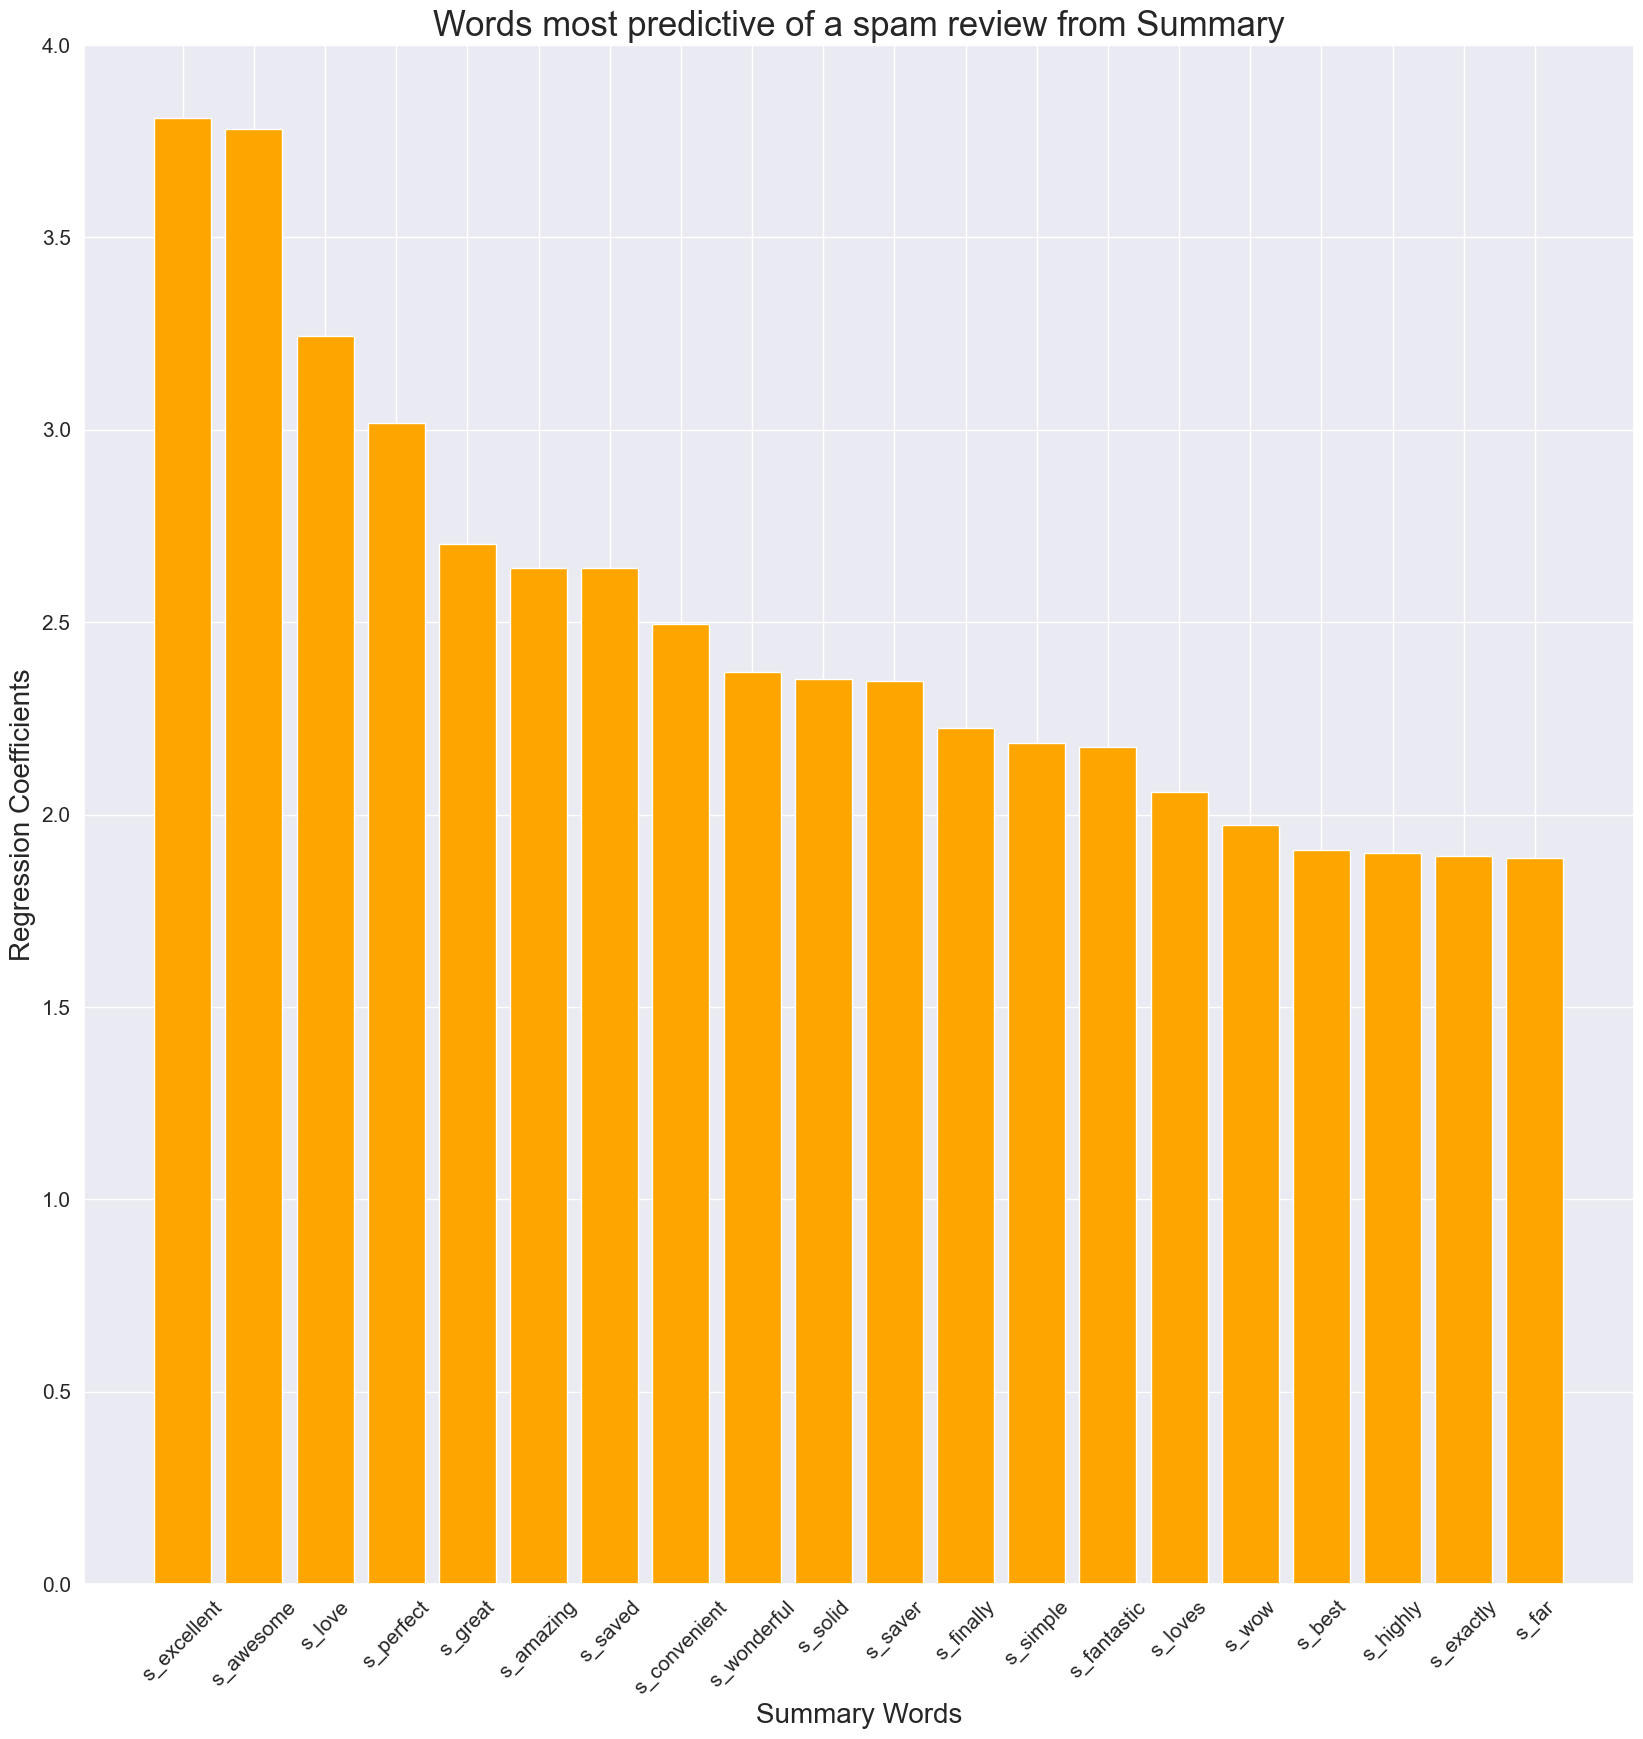

In [217]:
#20 words most predictive of a good review
plt.figure(figsize=(20,20))
plt.bar(summary_words_tfidf['Features'].head(20), summary_words_tfidf['Regression Coefficients'].head(20), color='orange')
plt.xlabel('Summary Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a spam review from Summary', fontsize=25)
plt.show()

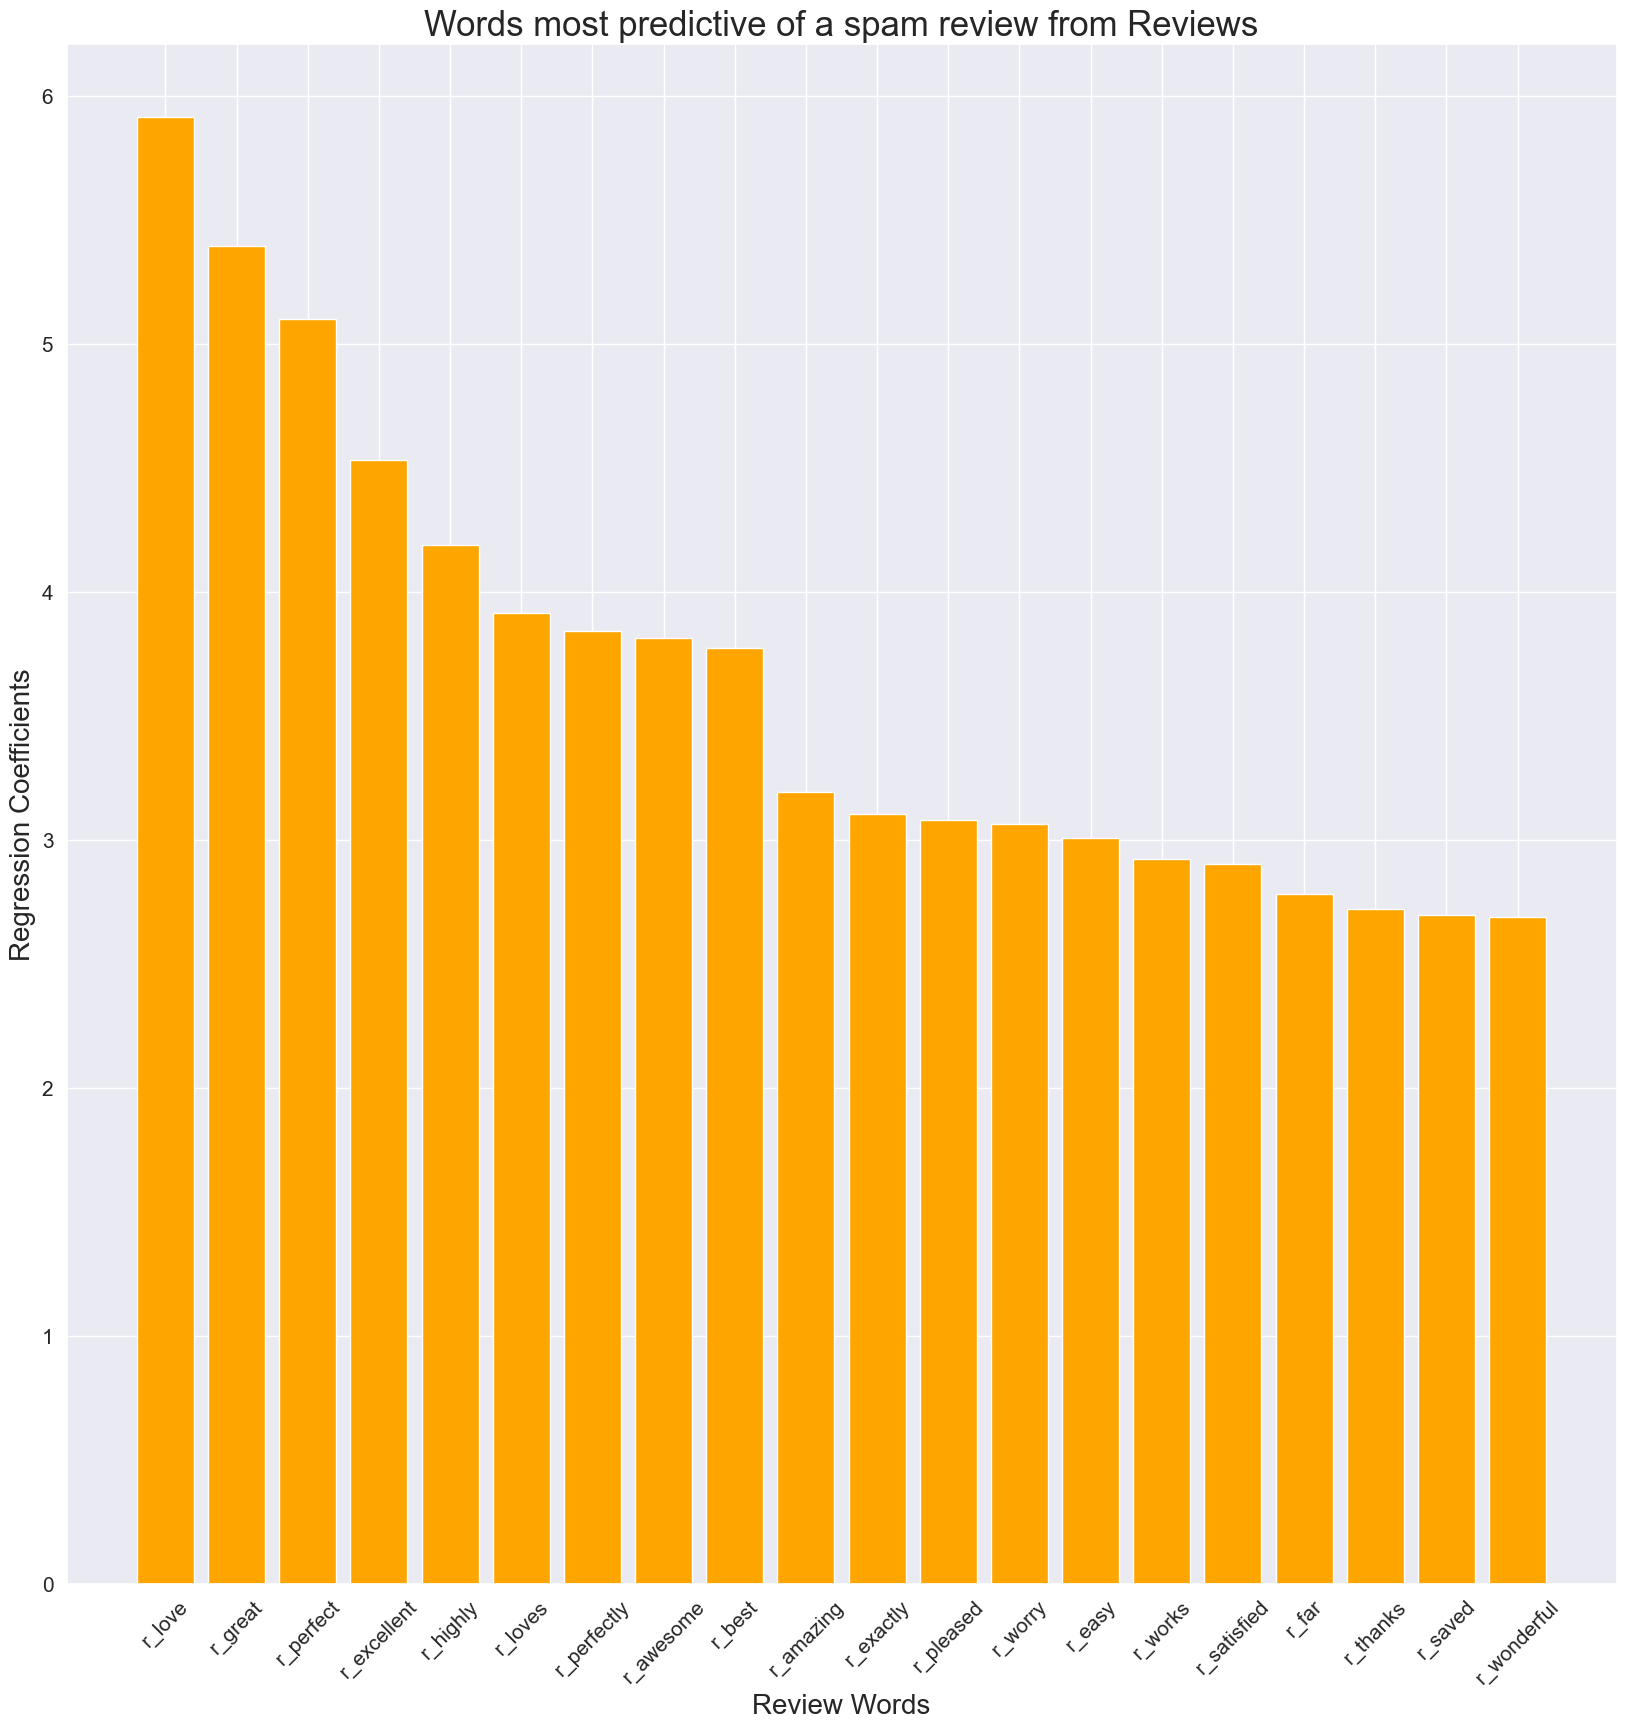

In [218]:
#20 words most predictive of a spam review
plt.figure(figsize=(20,20))
plt.bar(review_words_tfidf['Features'].head(20), review_words_tfidf['Regression Coefficients'].head(20), color='orange')
plt.xlabel('Review Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a spam review from Reviews', fontsize=25)

#Saving the plot for Capstone Presentation and Report
plt.savefig('Words most predictive of a spam review from Reviews.jpeg', bbox_inches='tight')

plt.show()

There is a lot of overlap in the words indicative of a spam review from the `summary` and `reviewText` columns.

Some of the overlapping words:
- great
- love
- amazing
- perfect

It is interesting to see that these are all very positive words. This could be a method employed by the spam reviewers to always use the best and most positive words in order to catch the attention of potential customers going through the products reviews trying to decide if this ia a product worth buying or not. It seems like the spam reviewers are trying very hard to up-sell the product by showering it with constant praise and positivity.

Lets plot the words that were indicating real reviews:

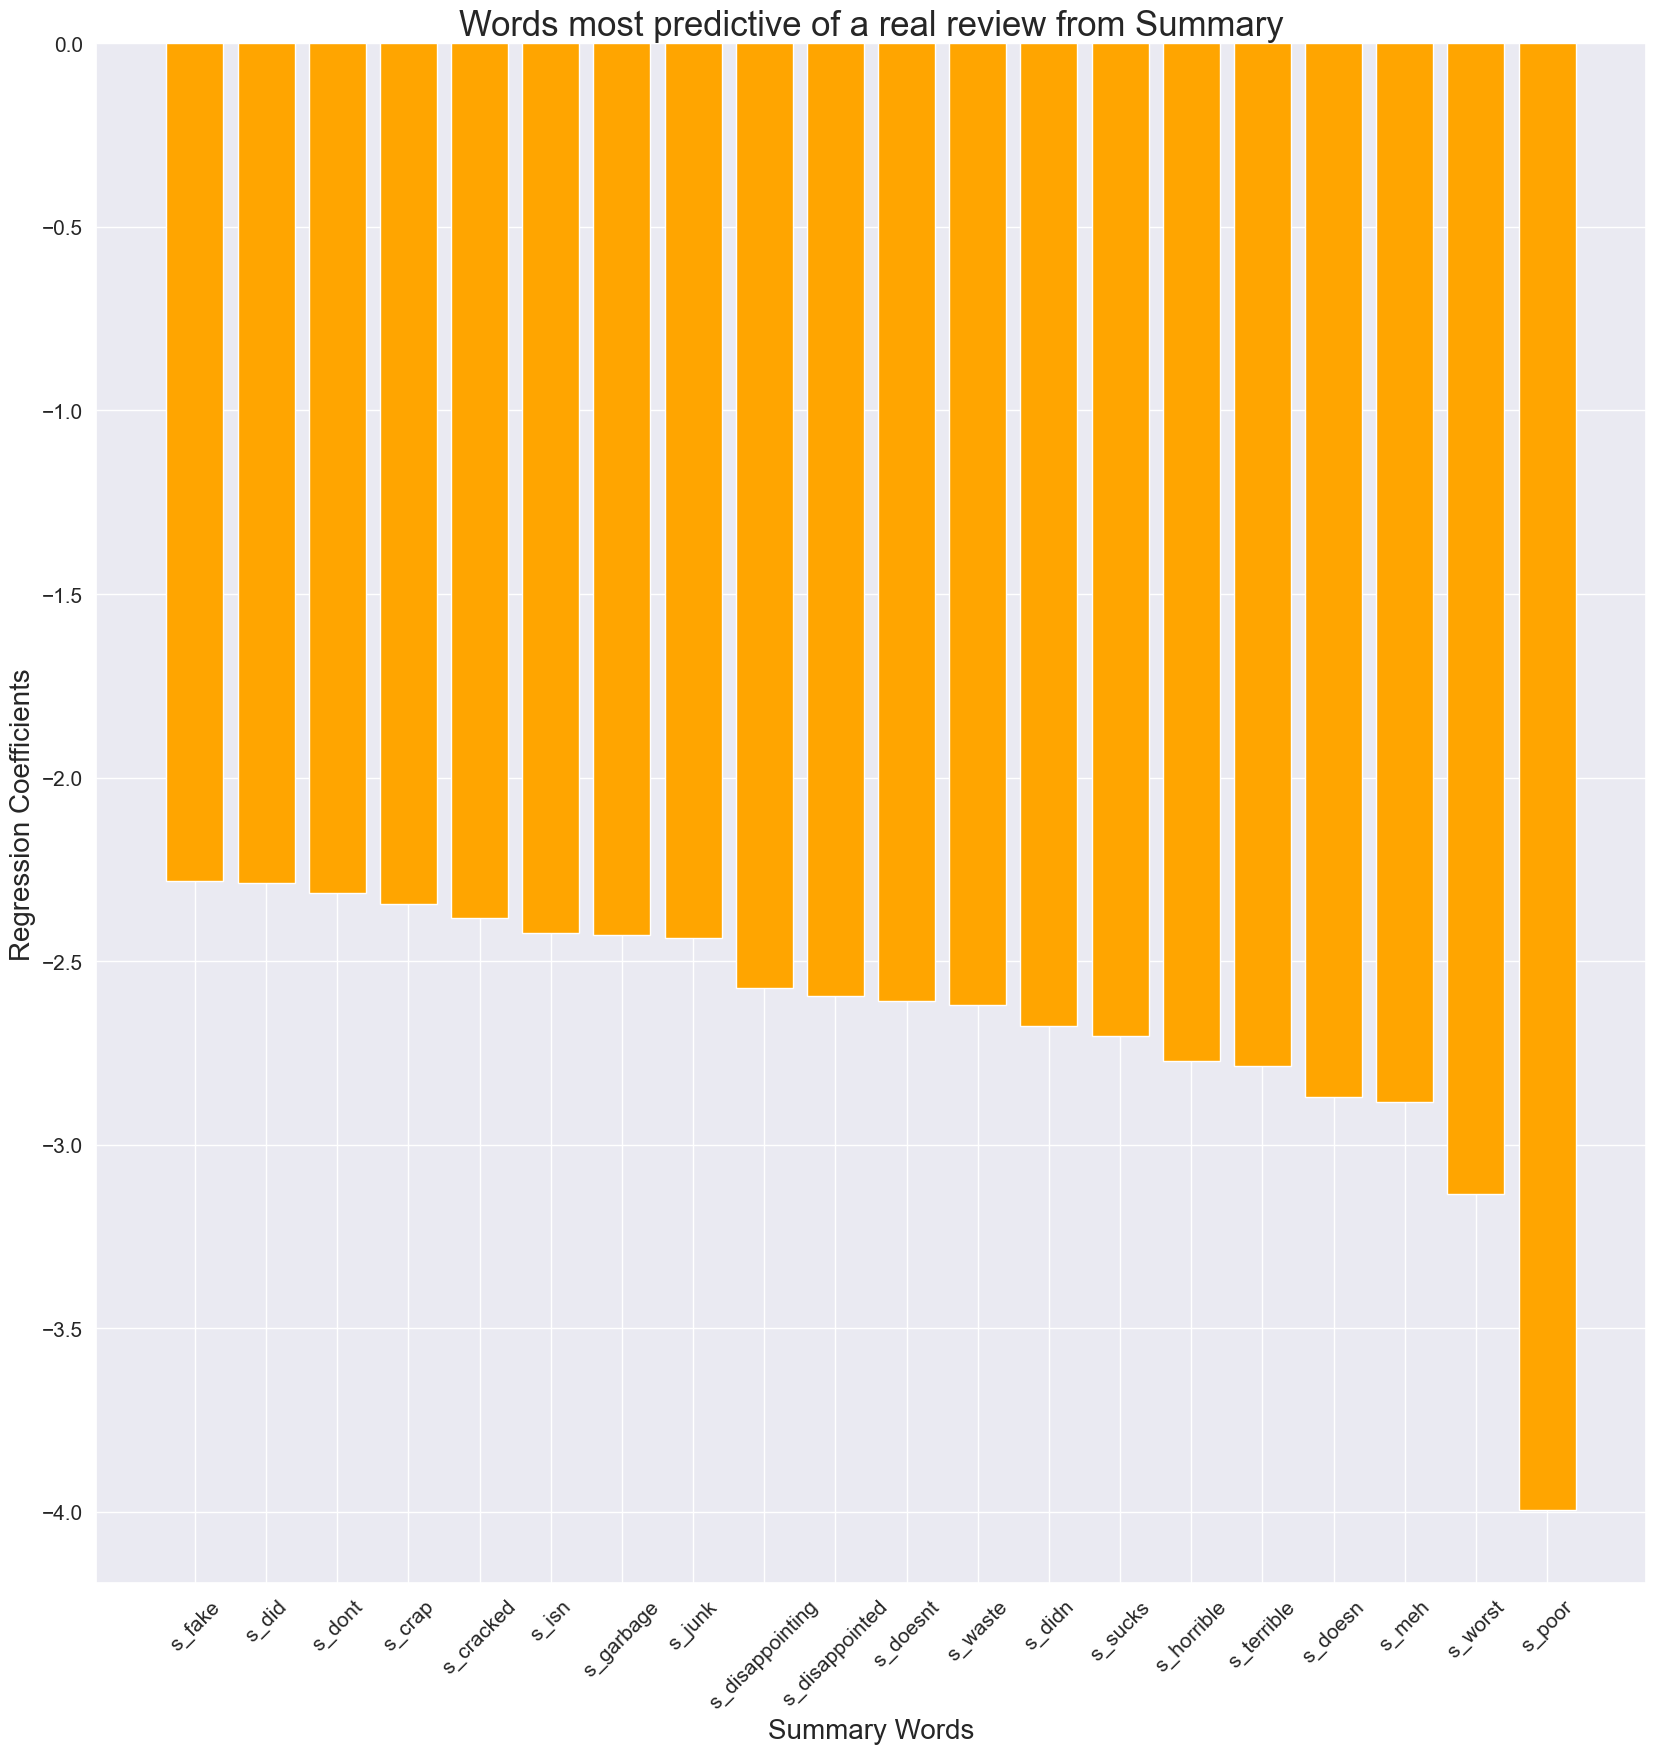

In [219]:
#20 words most predictive of a good review
plt.figure(figsize=(20,20))
plt.bar(summary_words_tfidf['Features'].tail(20), summary_words_tfidf['Regression Coefficients'].tail(20), color='orange')
plt.xlabel('Summary Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a real review from Summary', fontsize=25)
plt.show()

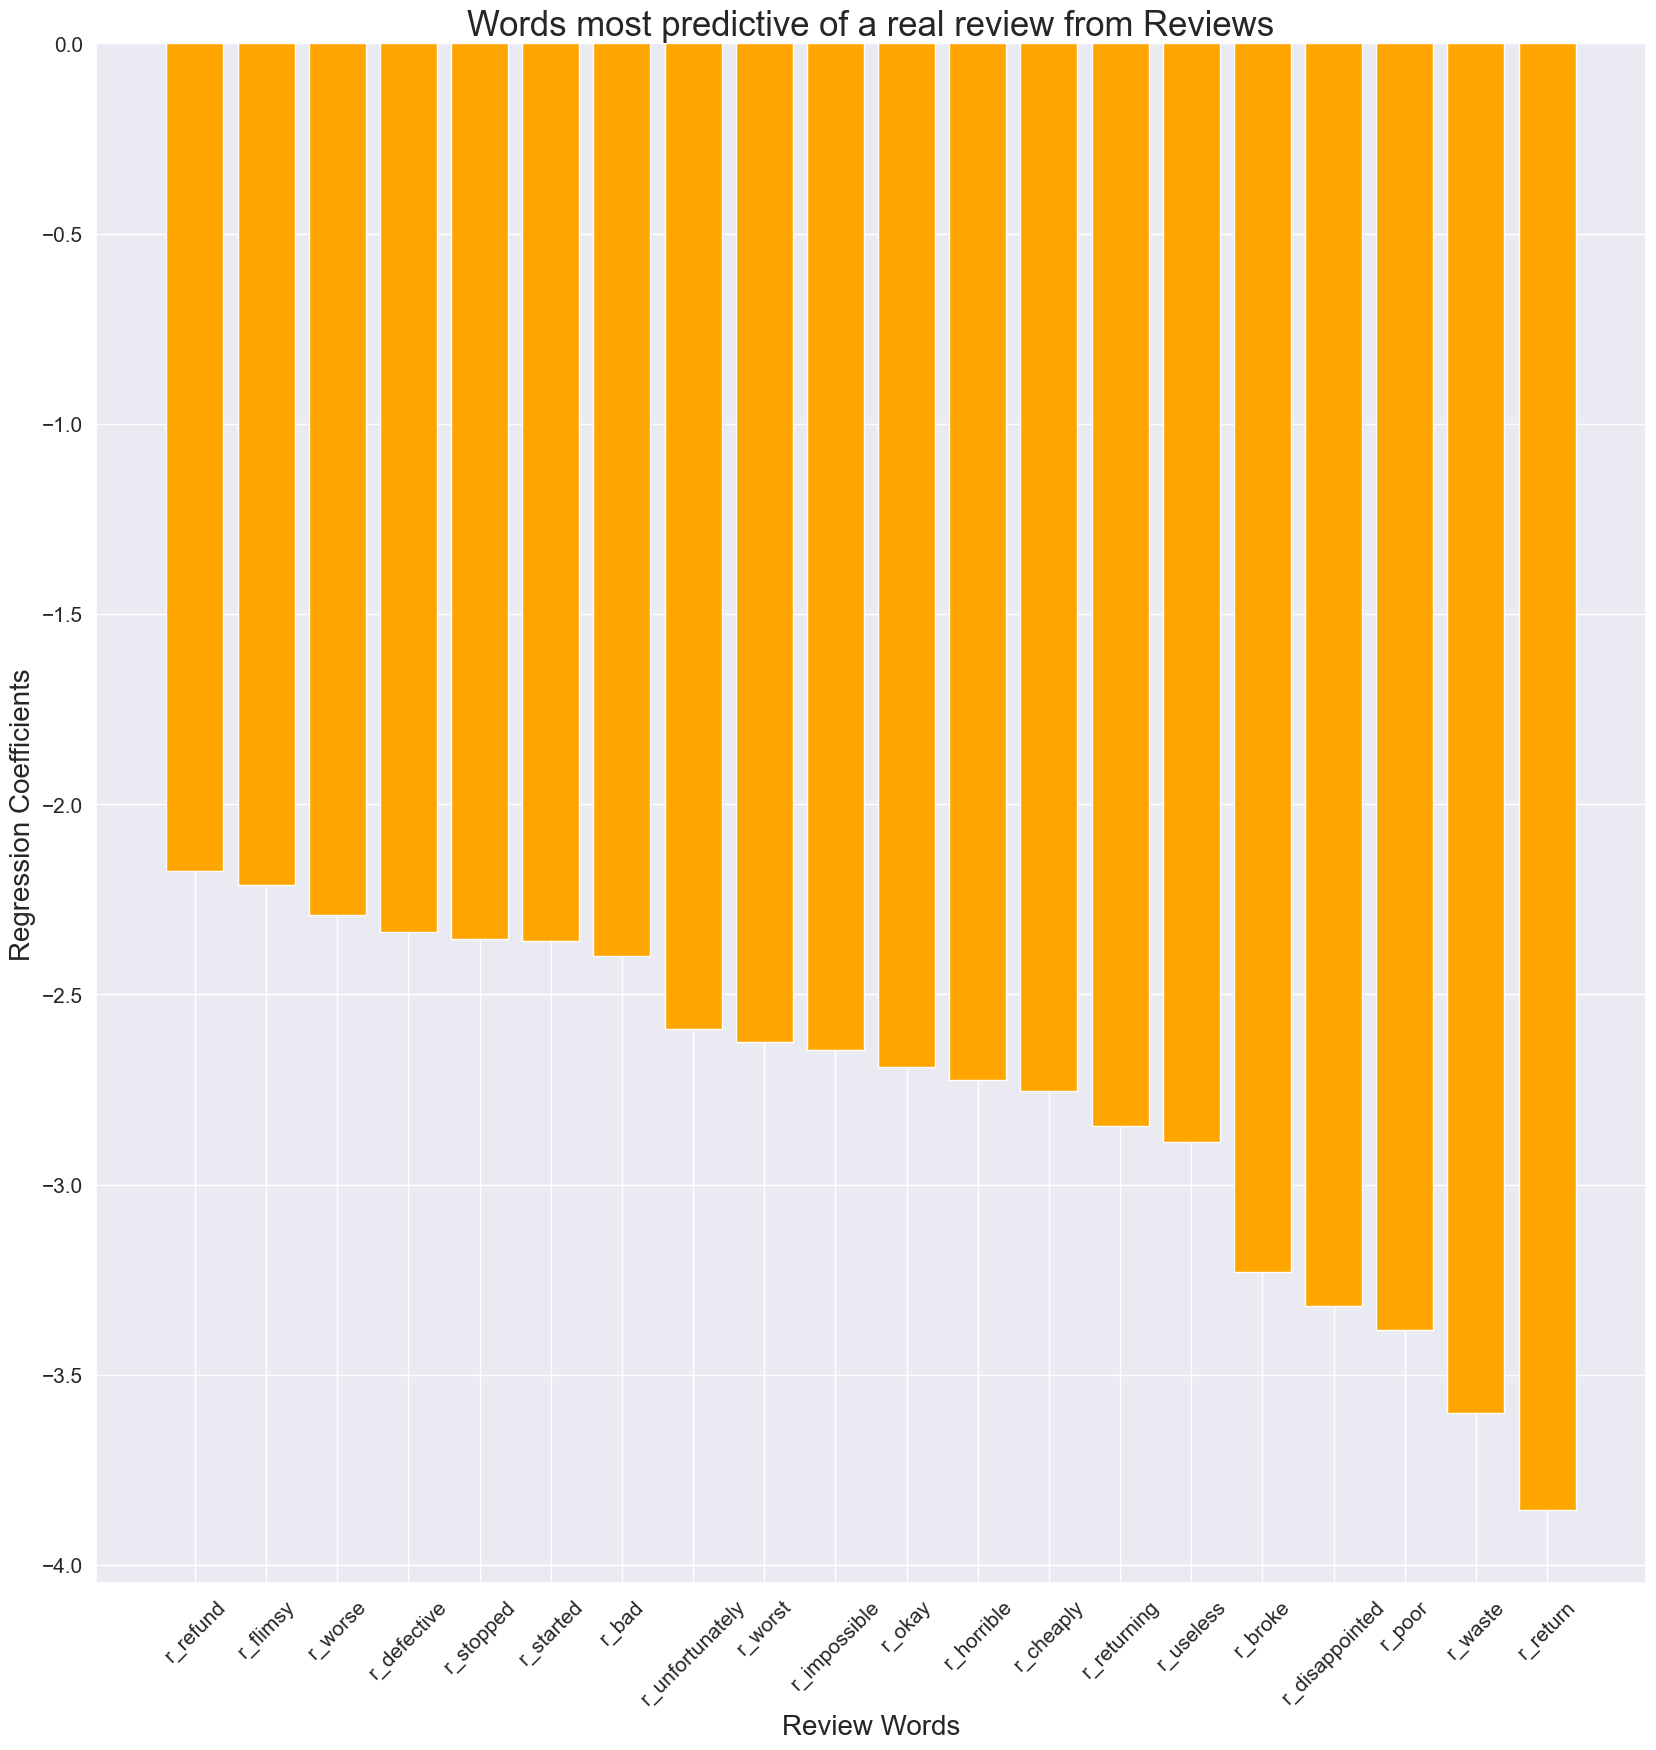

In [220]:
#20 words most predictive of a spam review
plt.figure(figsize=(20,20))
plt.bar(review_words_tfidf['Features'].tail(20), review_words_tfidf['Regression Coefficients'].tail(20), color='orange')
plt.xlabel('Review Words', fontsize=20)
plt.xticks(fontsize=15, rotation = 45)
plt.ylabel('Regression Coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Words most predictive of a real review from Reviews', fontsize=25)

#Saving the plot for Capstone Presentation and Report
plt.savefig('Words most predictive of a real review from Reviews.jpeg', bbox_inches='tight')

plt.show()

Once again, there is a lot of overlap in the words indicative of a real review from the `summary` and `reviewText` columns.

Some of the overlapping words:
- horrible
- poor
- worst
- waste

It is interesting to see that these are all quite negative words. These reviews are most likely indicating the true nature of the product based on their real-world experience/usage of the product, warning potential customers to not purchase this product and stay away from it.

Seems like the spam reviews have been posted to push/draw attention away from the real reviews, in order to dupe a customer into purchasing a sub-par product.

Lets plot the confusion matrix for the vectorized dataset now:

### Confusion Matrix for the LogisticRegression on the TF-IDF Combined Vectorized dataset

In [221]:
#Import the confusion matrix libraries
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [222]:
# Get class predictions
y_pred = base_logit_tfidf.predict(X_test_tfidf_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Real Reviews", "Predicted Spam Reviews"],
    index=["True Real Reviews", "True Spam Reviews"]
)

display(cf_df)

Predicted Real Reviews  Predicted Spam Reviews
True Real Reviews                    5399                    1645
True Spam Reviews                     978                   15777

Text(0.5, 1.0, 'TF-IDF LogReg Confusion Matrix')

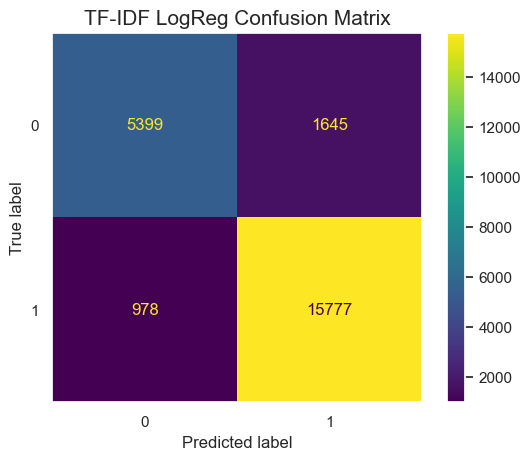

In [223]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(base_logit_tfidf, X_test_tfidf_scaled, y_test)
plt.grid(False)
plt.title('TF-IDF LogReg Confusion Matrix', fontsize=15)

Summary of Confusion Matrix:
| Classification      | Total |
|---------------------|-------|
| True Negative (TN)  | 5399  |
| True Positive (TP)  | 15777 |
| False Negative (FN) | 978   |
| False Positive (FP) | 1645  |

Based on the initial interpretation of the confusion matrix, it seems like the model performed quite well.

The total of the True Values (TN + TP) is much higher than the total of the False Values (FN + FP) indicating high accuracy.

But with regards to review detection we would want a higher recall rate(how well the model identified the positive/negative reviews correctly vs the total positive/negative reviews in the dataset).

These will be check via the classification report:

In [224]:
#Importing the classification report library
from sklearn.metrics import classification_report

In [225]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.85      0.77      0.80      7044
           1       0.91      0.94      0.92     16755

    accuracy                           0.89     23799
   macro avg       0.88      0.85      0.86     23799
weighted avg       0.89      0.89      0.89     23799



As predicted we have a good accuracy of 89%, and surprisingly enough a decent recall rate of 77% for the real reviews and 94% for the spam reviews.

The difference between the True Positive and False Positive rates might be due to a class imbalance in the dataset.

We can try to improve the recall rate by adjusting the y_proba threshold.

Lets take a look at how much the recall would improve if we adjusted the y_proba rate to 0.2 from the default value of 0.5:

In [226]:
# Importing precision and recall score libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [227]:
# Make probabilistic predictions (scores)
y_proba = base_logit_tfidf.predict_proba(X_test_tfidf_scaled)[:,1]

In [228]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.9055791527953163
Recall score: 0.9416293643688451

Threshold of 0.2:
Precision score: 0.8384689578151175
Recall score: 0.9857952849895554


Summary of results:
1. Threshold goes down
2. We predict more samples as spam
3. We get more false positives which drives the precision down
4. We get more true positives that drive the recall up

So by reducing our y_proba threshold from 0.5 to 0.2, we are seeing a ~4.5% increase in the recall, but we also have a ~7% drop in the accuracy.

For the next model, I shall try reducing the dimentionality of the dataset using PCA.

### PCA Model

The PCA model analysis will be conducted on the scaled remainder dataset.

The first run of the PCA model will not have the n_components hyperparameter defined, it will be determined via a plot of the Number of PCs vs Cumilative Sum of Explained Variance.

Lets start with the initial PCA model run:

In [229]:
#Import the PCA Library
from sklearn.decomposition import PCA

In order to decide which vectorisation gives the least number of principal components, I shall make two PCA models fitted to the Bag-of-Words Vectorised data and the TF-IDF Vectorised data.

Lets start with the inital modelling to determine the optimal number of PCs:

In [230]:
#For the first run we will not define the n_components hyperparameter
# Instantiate the model
BoW_PCA = PCA() 
TFIDF_PCA = PCA()

In [247]:
# Fit the PCA object to the data
BoW_PCA.fit(X_remainder_scaled)
TFIDF_PCA.fit(X_remainder_tfidf_scaled)

PCA()

In [248]:
# Transform the original data. This applies the 'change of basis' that transforms the data to be based on the principal components
X_rem_BoW_PCA = BoW_PCA.transform(X_remainder_scaled)
X_test_BoW_PCA = BoW_PCA.transform(X_test_scaled)

X_rem_TF_PCA = BoW_PCA.transform(X_remainder_tfidf_scaled)
X_test_TF_PCA = BoW_PCA.transform(X_test_tfidf_scaled)

In [249]:
#Checking the shape of the PCA Remainder data
print(X_rem_BoW_PCA.shape)
print(X_rem_TF_PCA.shape)

(55531, 1892)
(55531, 1892)


Lets make a pair plot of only the first 5 columns prior to being transformed using PCA to see their correlations:

In [250]:
#First a new dataframe will need to be made containing only the first 10 columns from the current X_train dataset
X_remainder_sample = X_remainder_vect.iloc[:, :10].copy()

In [251]:
X_remainder_sample

help_neg  help_pos  r_00  r_10  r_100  r_12  r_15  r_20  r_30  r_34
10246         0         0     0     0      0     0     0     0     0     0
74664         0         0     0     0      0     0     0     0     0     0
11343         2         1     0     0      0     0     0     0     0     0
71940         0         0     0     0      0     0     0     0     1     0
21699         0         0     0     0      0     0     0     0     0     0
...         ...       ...   ...   ...    ...   ...   ...   ...   ...   ...
31233         0         0     0     0      0     0     0     0     0     0
11620         0         0     0     0      0     0     0     0     0     0
37006         2         1     0     0      0     0     0     2     0     0
41060         0         0     0     0      0     0     0     0     0     0
76895         1         1     0     0      0     0     0     0     0     0

[55531 rows x 10 columns]

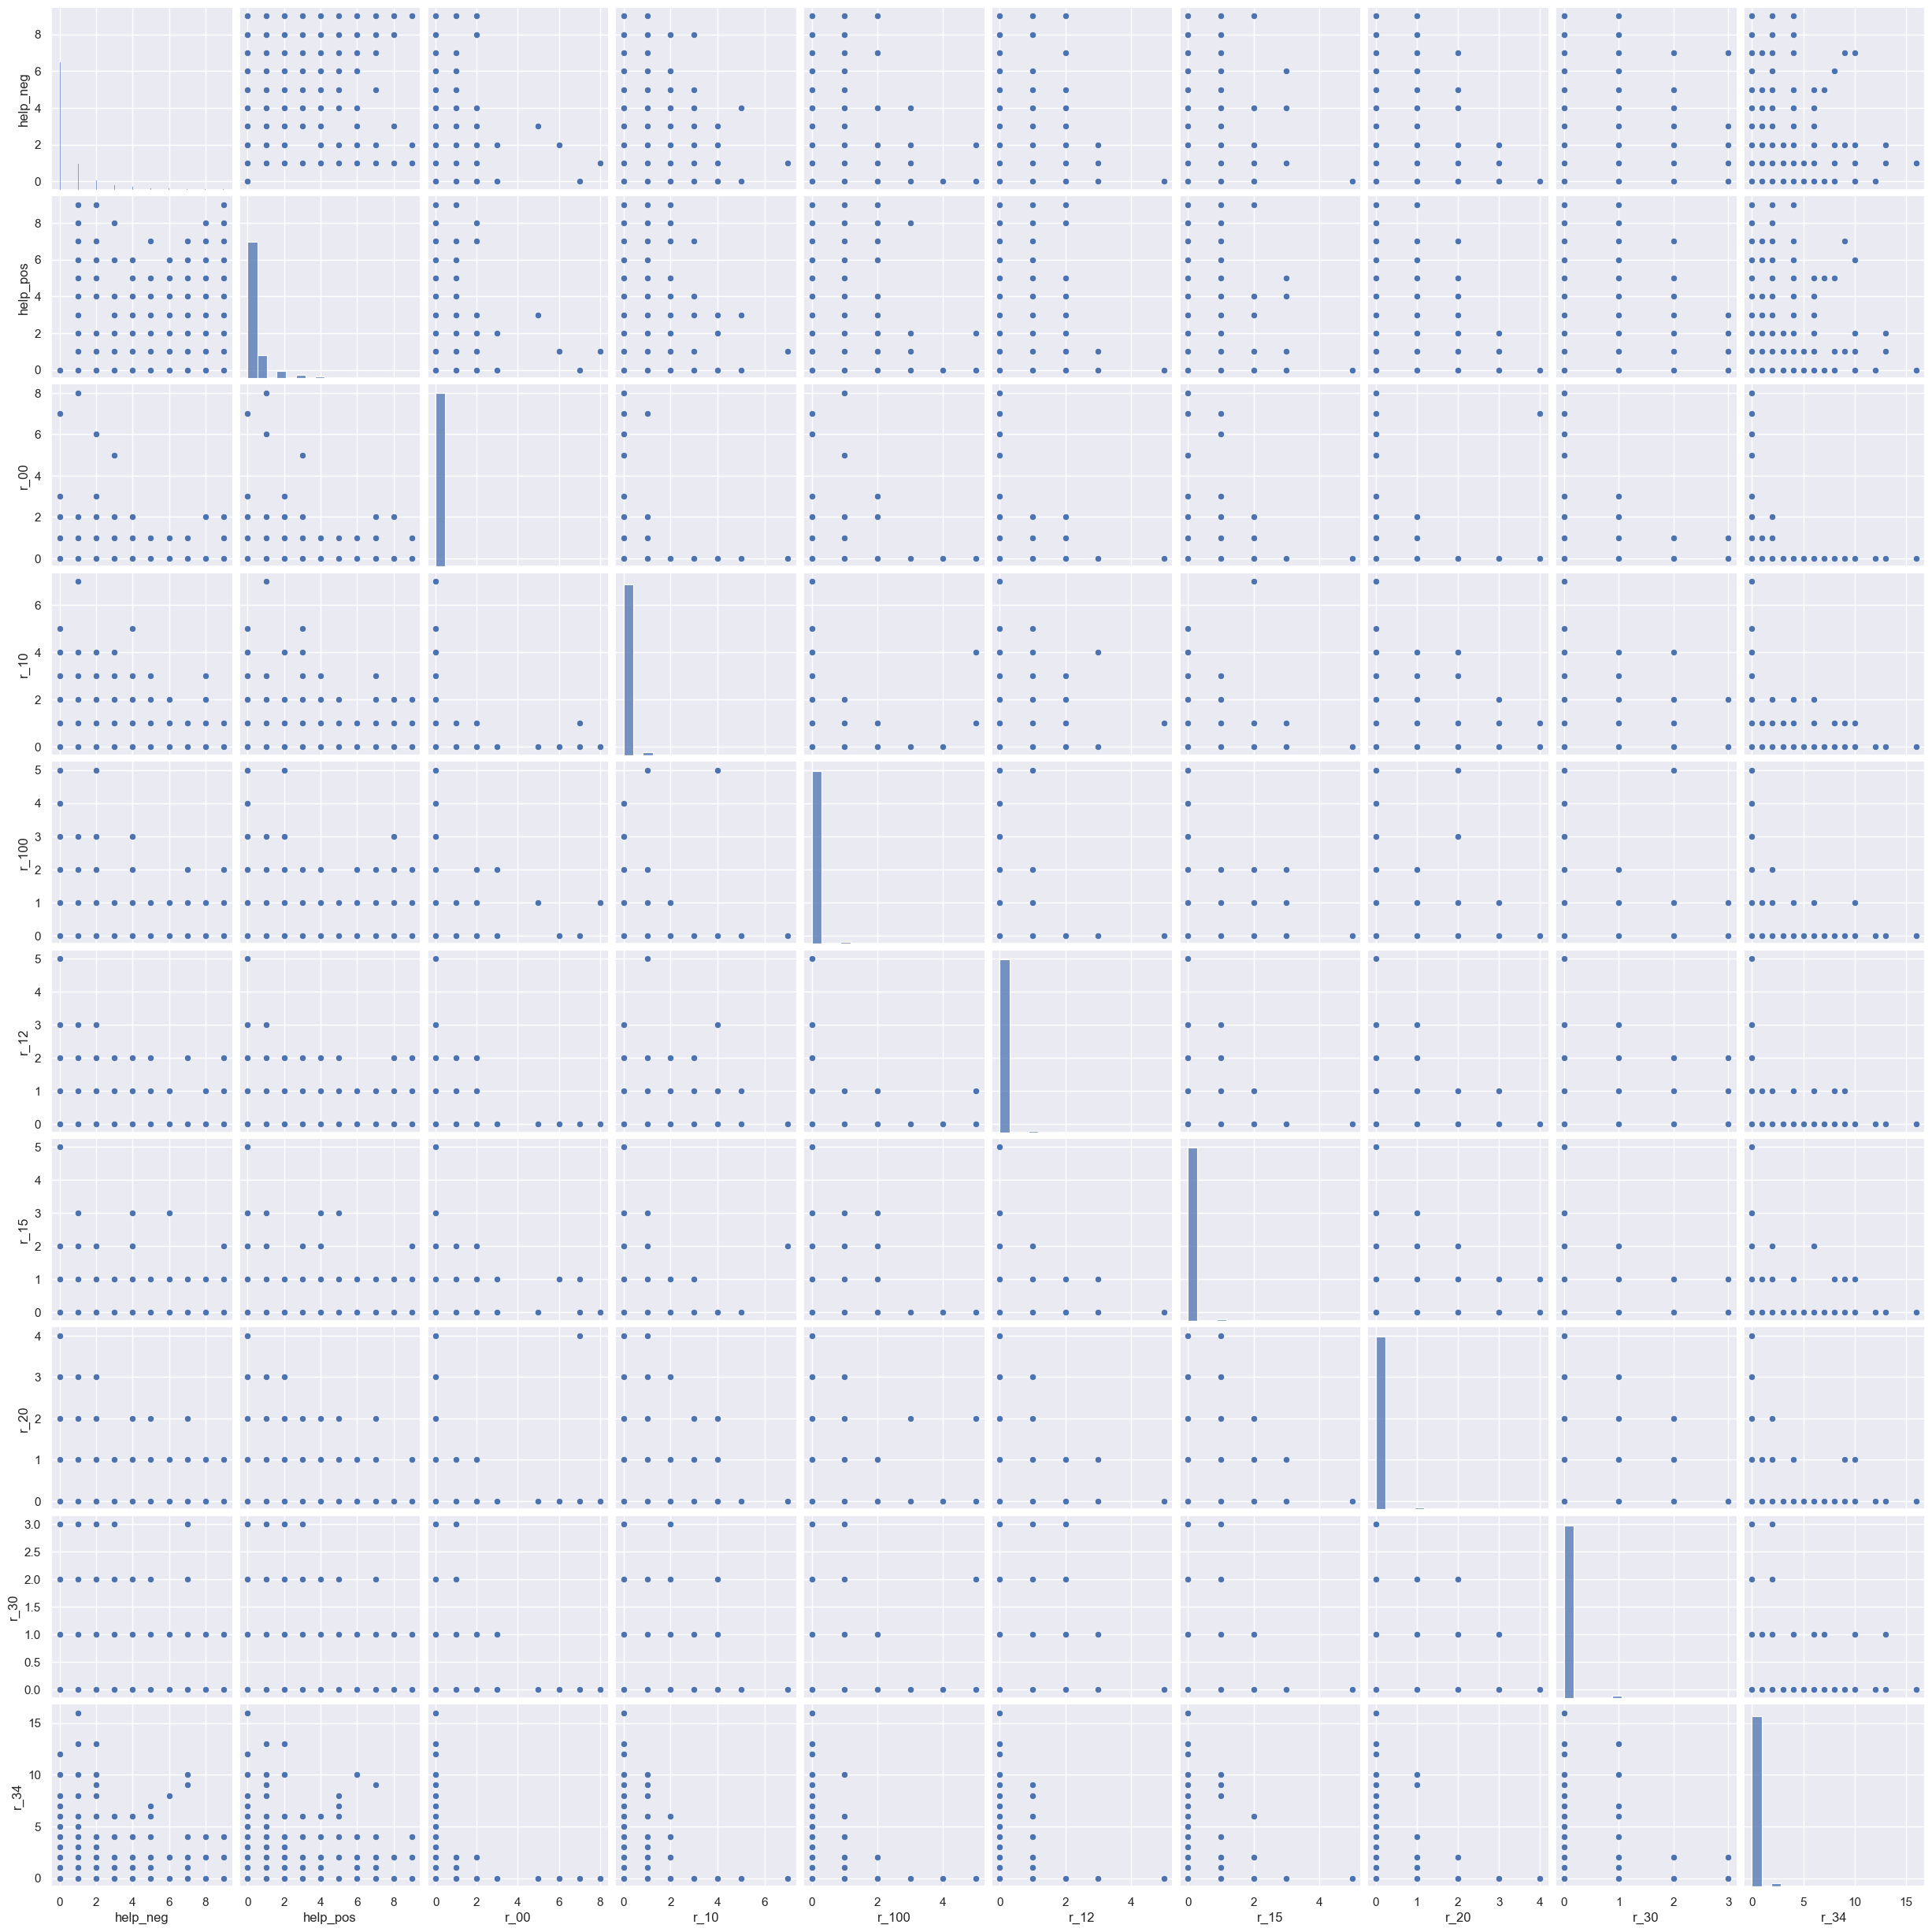

In [252]:
# plotting correlation between each feature
sns.pairplot(data=X_remainder_sample)

Due to the binary nature of the columns, there is not much correlation interpretability from the pair plots.

Lets make a pair plot of only the first 10 columns after being transformed using PCA to see their correlations:

In [253]:
#First a new dataframe will need to be made containing only the first 10 columns from the PCA X_remainder dataset

X_rem_BoW_PCA_sample = pd.DataFrame(X_rem_BoW_PCA, columns= range(1, np.shape(X_rem_BoW_PCA)[1]+1))
X_rem_TF_PCA_sample = pd.DataFrame(X_rem_TF_PCA, columns= range(1, np.shape(X_rem_TF_PCA)[1]+1))

In [254]:
X_rem_BoW_PCA_sample = X_rem_BoW_PCA_sample.iloc[:, :5].copy()
X_rem_TF_PCA_sample = X_rem_TF_PCA_sample.iloc[:, :5].copy()

In [255]:
X_rem_BoW_PCA_sample

1         2         3         4         5
0     -0.112795 -0.006907  0.009698  0.046177 -0.191536
1     -0.121869 -0.087202 -0.030794  0.051428  0.032075
2      0.118739 -0.117354  0.011828  0.030256 -0.051729
3     -0.065164 -0.019046 -0.037841  0.081838  0.078077
4     -0.093289 -0.057347 -0.031563  0.076674  0.042536
...         ...       ...       ...       ...       ...
55526 -0.116622 -0.039252 -0.040783 -0.012503  0.037319
55527 -0.119481  0.009332 -0.046750 -0.215037  0.020125
55528  0.187932 -0.038501 -0.024461  0.033140  0.083567
55529 -0.126554 -0.086007 -0.022585  0.031847  0.016717
55530  0.199597  0.115058 -0.033102  0.108255  0.113006

[55531 rows x 5 columns]

In [256]:
X_rem_TF_PCA_sample

1         2         3         4         5
0     -0.085622  0.070784  0.029802  0.061963 -0.315203
1     -0.098543 -0.050511 -0.038229  0.063933  0.052811
2      0.171977 -0.028811  0.012177  0.055080 -0.063043
3     -0.016877  0.041803 -0.043416  0.103997  0.113354
4     -0.051458  0.001954 -0.033958  0.104801  0.054820
...         ...       ...       ...       ...       ...
55526 -0.089054  0.022496 -0.051654 -0.028930  0.055020
55527 -0.091292  0.233378 -0.090185 -0.721390  0.022820
55528  0.194179 -0.052296 -0.031295  0.056392  0.109437
55529 -0.107038 -0.050448 -0.021456  0.033718  0.017677
55530  0.160793  0.053115 -0.035526  0.087878  0.106329

[55531 rows x 5 columns]

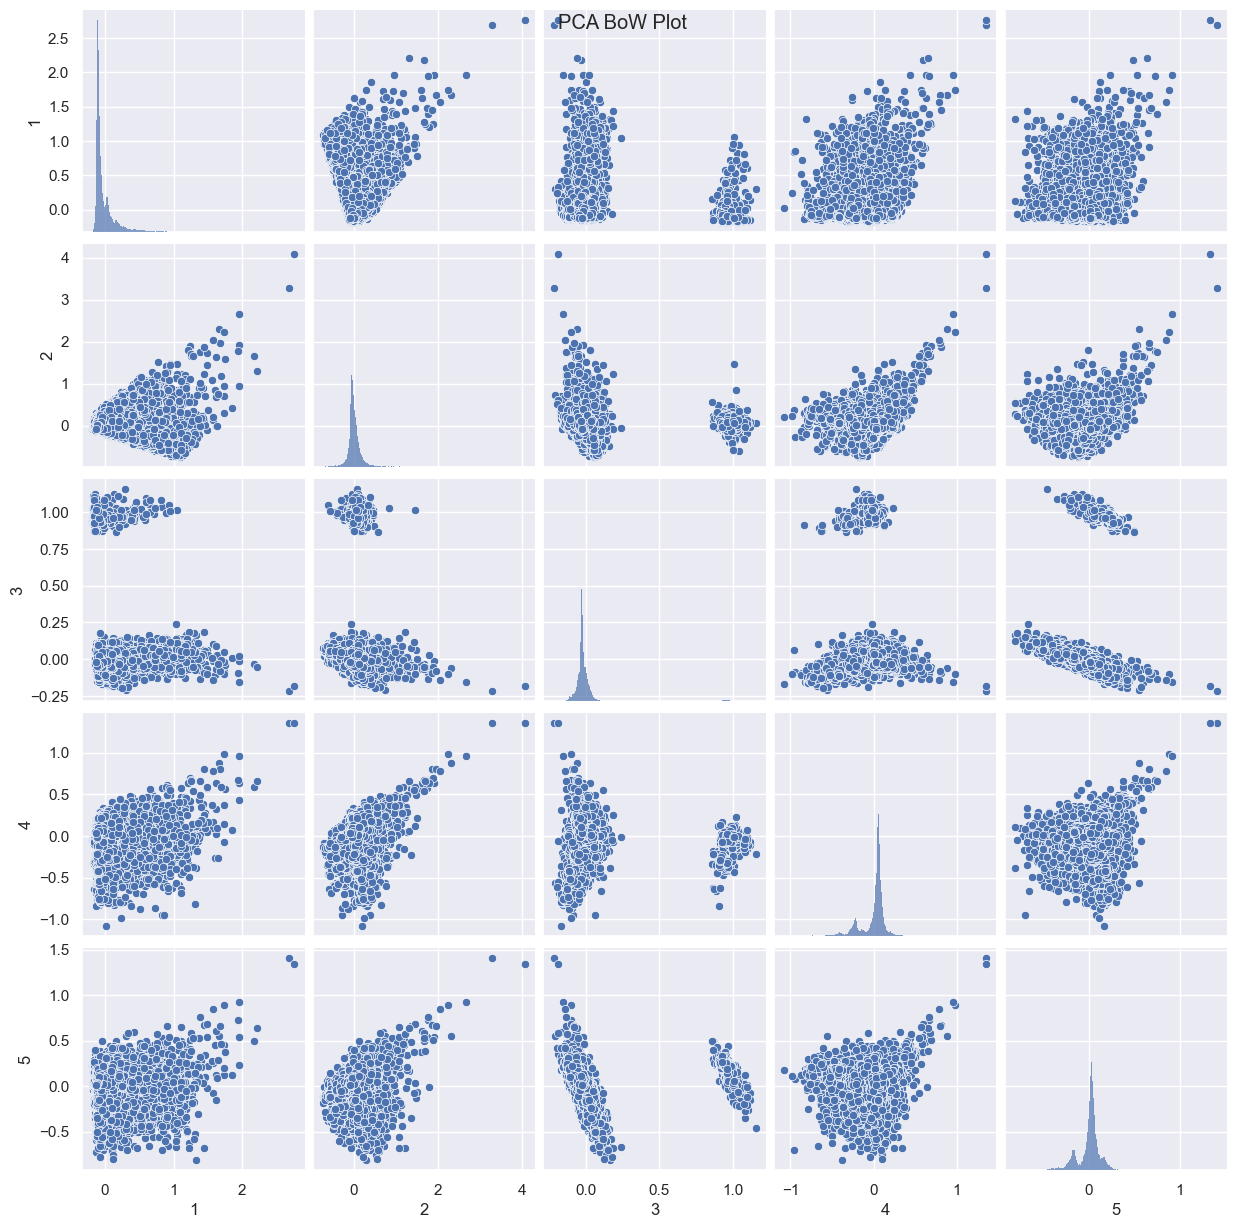

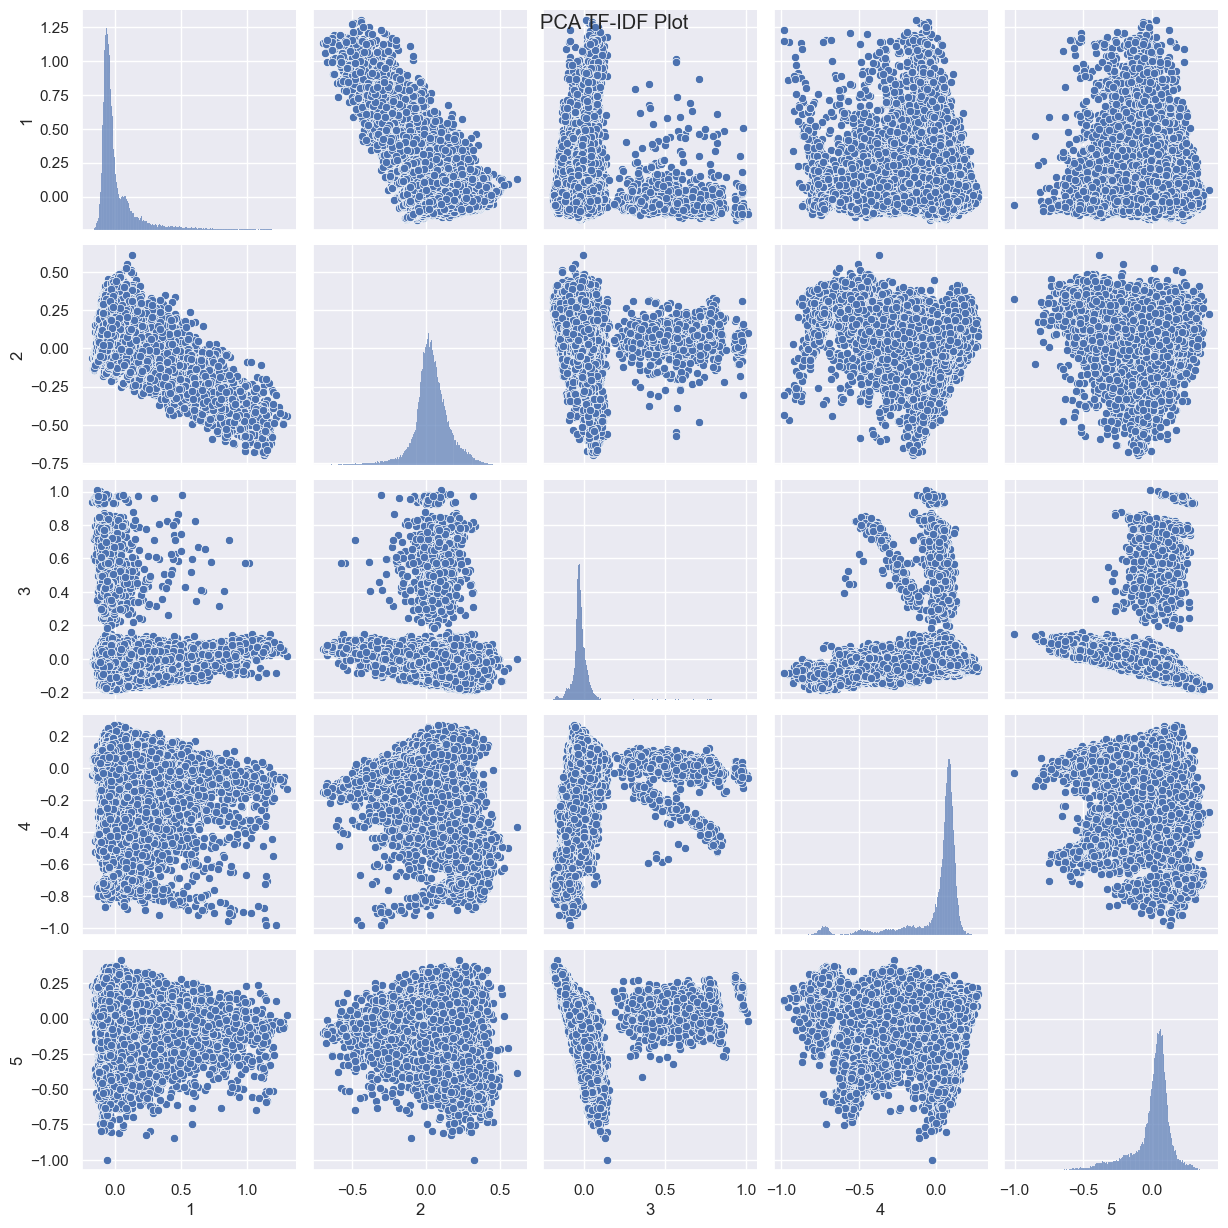

In [257]:
# plotting correlation between each feature
PCA_BoW = sns.pairplot(data=X_rem_BoW_PCA_sample)
PCA_BoW.fig.suptitle('PCA BoW Plot')
plt.show()

PCA_TF = sns.pairplot(data=X_rem_TF_PCA_sample)
PCA_TF.fig.suptitle('PCA TF-IDF Plot')
plt.show()

Notes for PCA BoW Plot:
* PCA Data columns 1, 3, and 5 have a right skew
* PCA Data column 3 looks normally distributed
* PCA Data columns 2, 4, and 5 look normally distributed with some outliers
* Column 4, seems to have a normal distribution with a slight right skew
* For the rest of the columns there seems to be no clear indication of the correlation

Notes for PCA TF-IDF Plot:
* PCA Data columns 1, 3, and 5 have a right skew
* PCA Data column 3 looks normally distributed
* PCA Data columns 2, 4, and 5 look normally distributed with some outliers
* Column 4, seems to have a normal distribution with a slight right skew
* Column 5, seems to have a normal distribution with a slight left skew
* For the rest of the columns there seems to be no clear indication of the correlation

Lets check the two key attributes from the fitted PCS:
1. explained_variance_ : Array containing the amount of variance explained by each component.
2. explained_variance_ratio : Array containing the percentage of variance explained by each component.

In [258]:
# Checking the variances for the Bag-of-Words PCA Model
for i in range(5):
    print(f"Variance captured by the BoW PC{i}: {BoW_PCA.explained_variance_[i]: 0.3f}")

for i in range(5):
    print(f"Proportion of variance captured by the BoW PC{i}: {BoW_PCA.explained_variance_ratio_[i]: 0.3f}")

Variance captured by the BoW PC0:  0.036
Variance captured by the BoW PC1:  0.022
Variance captured by the BoW PC2:  0.022
Variance captured by the BoW PC3:  0.020
Variance captured by the BoW PC4:  0.016
Proportion of variance captured by the BoW PC0:  0.018
Proportion of variance captured by the BoW PC1:  0.011
Proportion of variance captured by the BoW PC2:  0.011
Proportion of variance captured by the BoW PC3:  0.010
Proportion of variance captured by the BoW PC4:  0.008


In [259]:
# Checking the variances for the TF-IDF PCA Model
for i in range(5):
    print(f"Variance captured by the TF-IDF PC{i}: {TFIDF_PCA.explained_variance_[i]: 0.3f}")

for i in range(5):
    print(f"Proportion of variance captured by the TF-IDF PC{i}: {TFIDF_PCA.explained_variance_ratio_[i]: 0.3f}")

Variance captured by the TF-IDF PC0:  0.048
Variance captured by the TF-IDF PC1:  0.036
Variance captured by the TF-IDF PC2:  0.033
Variance captured by the TF-IDF PC3:  0.032
Variance captured by the TF-IDF PC4:  0.030
Proportion of variance captured by the TF-IDF PC0:  0.018
Proportion of variance captured by the TF-IDF PC1:  0.014
Proportion of variance captured by the TF-IDF PC2:  0.013
Proportion of variance captured by the TF-IDF PC3:  0.012
Proportion of variance captured by the TF-IDF PC4:  0.011


As seen from the results of the variance capture, the principal components from the TF-IDF model attribute for more of the variation in the dataset. In both models, BoW and TF-IDF, PC0 had the highest variance capture of 0.036 and 0.048 respectively. The TF-IDF PC0 had a 0.012 higher variance capture which is quite significant since this is only a sample of the first 5 PC's out of the potential ~1900. Both also rates PC4 with having the lowest variance capture, but the variance capture for the PC4 in the TF-IDF was 0.015 higher than the BoWs.

For the explained variance ratio, it looks like PC0 attributes to the most variance capture in the BoW model, but this is the same value as for the TF-IDF model, 0.018. What is interesting to see here is that there is a sharp drop in the ratios from PC0 to PC4 in the BoW model, a 0.016 total drop, while for the TF-IDF model they are quite evenly distributed, with the difference between PC0, and PC4 only being 0.07, almost half of the difference when compared to the BoW model. This indicates that the TF-IDF model has a better balanced dataset with regards to the variance capture among all the PC's, which would lead to a better result.

Lets now find the optimal number of PC's for each model. Based on the variance captures between the models above, due to the more balanced nature of the TF-IDF model, it should have a higher dimension reduction in comparison to the BoW model.

### Optimal number of Principal Components

For finding the optimal number of Principal Components, we will use the method of pre-setting our proportion of variance explained to 90%

In [260]:
# Pull out the explained variance ratio for the BoW PCA Model
BoW_expl_var = BoW_PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
BoW_var_sum = np.cumsum(BoW_expl_var)

BoW_var_sum

array([0.01786212, 0.0287613 , 0.0392987 , ..., 0.99998944, 0.99999765,
       1.        ])

In [261]:
# Pull out the explained variance ratio for the TF-IDF PCA Model
TF_expl_var = TFIDF_PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
TF_var_sum = np.cumsum(TF_expl_var)

TF_var_sum

array([0.01833269, 0.03199165, 0.04463194, ..., 0.99996781, 0.99998434,
       1.        ])

Based on the quick glance at the cumilative sum array for the explained variances, we seem to hit the 100% variance explained mark quite early on. This indicates that we can definately reduce the dimensionality in the dataset and get a decently accurate model

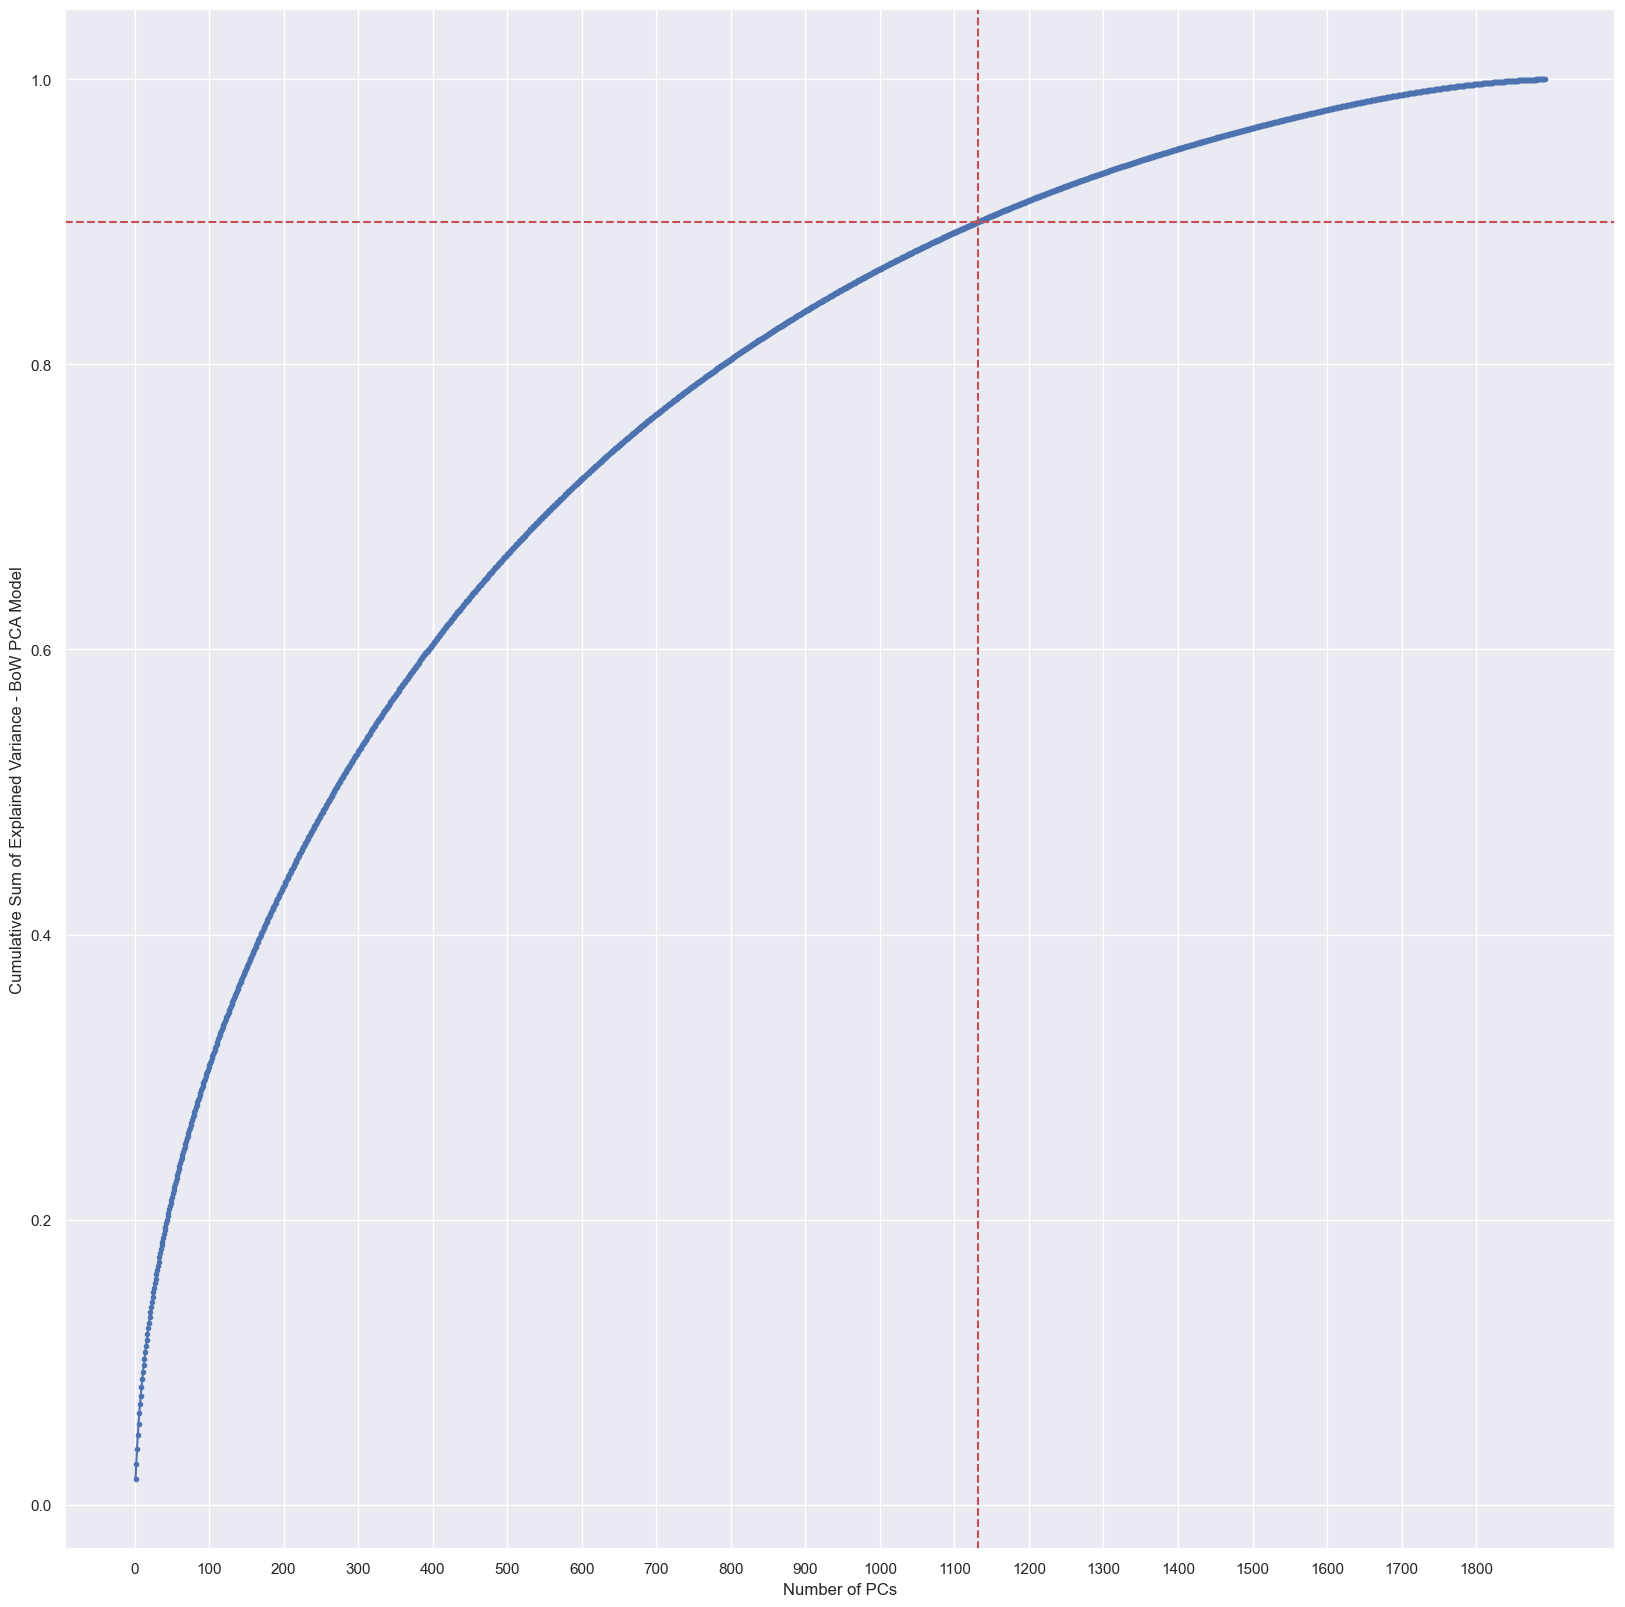

In [313]:
# Plot out the cumulative sum graph for the BoW PCA Model
plt.figure(figsize=(20,20))
plt.plot(range(1,1893), BoW_var_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.axvline(1131, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance - BoW PCA Model')
plt.xticks(range(0,1900,100))
plt.show()

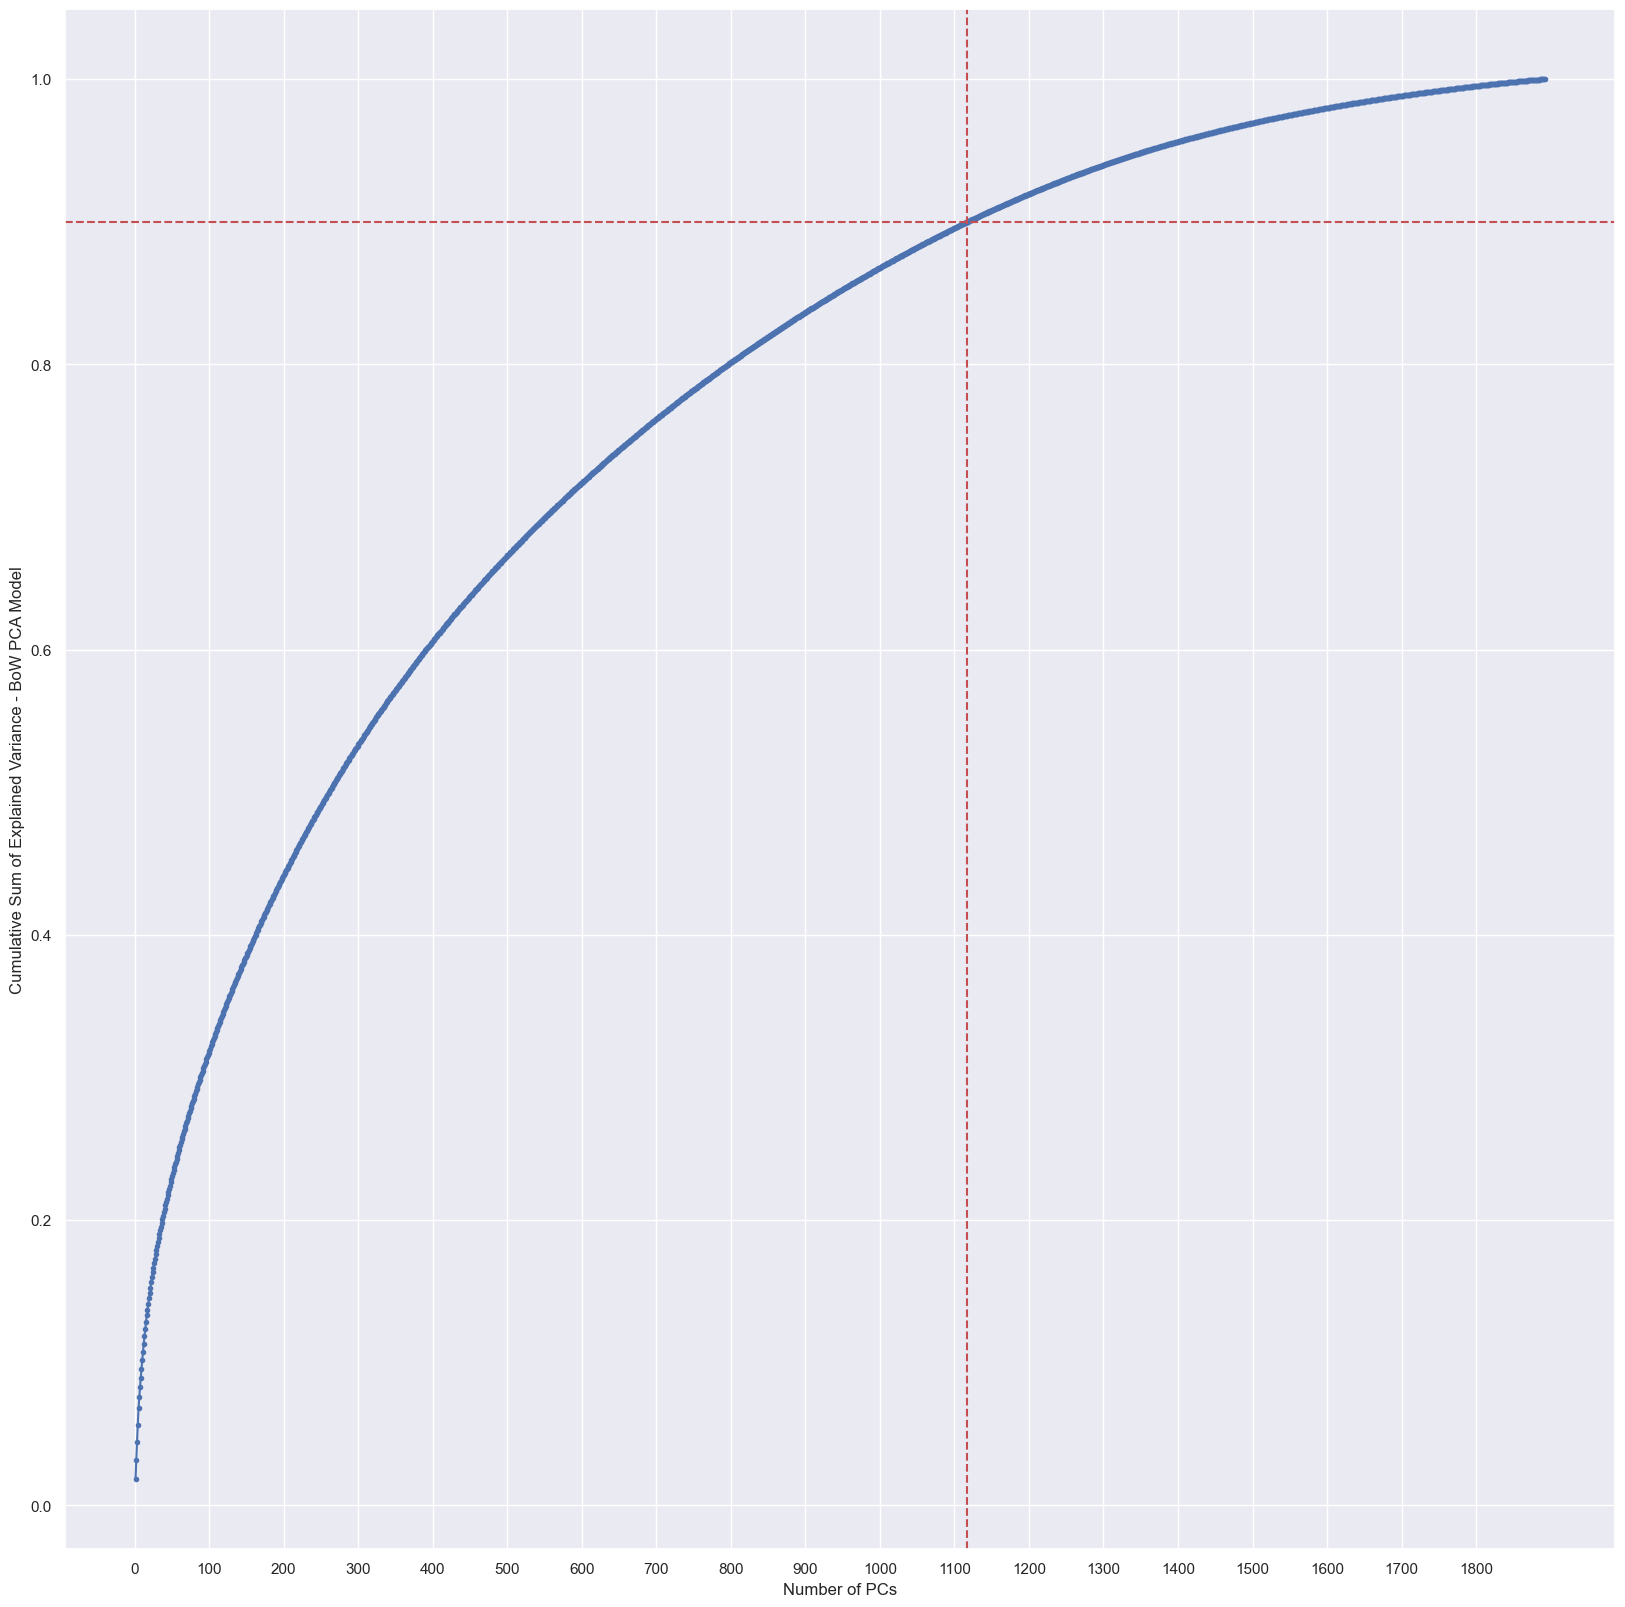

In [314]:
# Plot out the cumulative sum graph for the TF-IDF PCA Model
plt.figure(figsize=(20,20))
plt.plot(range(1,1893), TF_var_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.axvline(1117, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance - BoW PCA Model')
plt.xticks(range(0,1900,100))
plt.show()

It is almost impossible to interpret what would be the optimal number of PC's from the plot above.

We can use the following formula to get the number instead:

In [266]:
print(f'Optimal number of components based on the BoW Vectorized Data is {np.argmax(BoW_var_sum > 0.9)}')
print(f'Optimal number of components based on the TF-IDF Vectorized Data is {np.argmax(TF_var_sum > 0.9)}')

Optimal number of components based on the BoW Vectorized Data is 1131
Optimal number of components based on the TF-IDF Vectorized Data is 1117


As predicted earlier the TF-IDF model had a greater dimensionality reduction than the BoW model. The the BoW vs. TF-IDF vectorization resulted in a dimension reduction of 1131, and 1117, from 1892. This is a dimension reduction of 761-775 columns.
So for the baseline PCA model, the n_components hyperparameter for the PCA model will be set to 1117 based on the result from the TF-IDF Vectorized Data, and this will be the dataset used to fit the baseline PCA model.

In [267]:
# Instantiate the model
base_PCA = PCA(n_components=1117)

# Fit the PCA object to the data
base_PCA.fit(X_remainder_tfidf_scaled)

# Transform the original data. This applies the 'change of basis' that transforms the data to be based on the principal components
X_remainder_PCA = base_PCA.transform(X_remainder_tfidf_scaled)
X_test_PCA = base_PCA.transform(X_test_tfidf_scaled)

In [268]:
#Lets compare the shapes of the PCA Transformed vs. Original Remainder dataset
print(f'Original: {X_remainder_tfidf_scaled.shape}')
print(f'PCA Transformed: {X_remainder_PCA.shape}')

Original: (55531, 1892)
PCA Transformed: (55531, 1117)


The PCA transformation has reduced the column dimensionality by 787 columns. The columns have been reduced from 1892 to 1117.

As a sanity check to ensure that 1117 is the optimal number of PCs, we will use the shortcut for this method. For the shortcut we do not need to first determine the optimal PCs via the plot/explained variance check, we simply need to set the n_components to 0.9(90% of the variance):

In [269]:
# Lets say we want to keep 90% of the variance
base_PCA = PCA(n_components = 0.9)
base_PCA.fit(X_remainder_tfidf_scaled)

# Transform train and test
X_remainder_PCA = base_PCA.transform(X_remainder_tfidf_scaled)
X_test_PCA = base_PCA.transform(X_test_tfidf_scaled)

In [270]:
#Lets check the shape of the PCA Transformed via the shortcut vs. Original Training dataset
print(f'Original: {X_remainder_tfidf_scaled.shape}')
print(f'PCA Transformed: {X_remainder_PCA.shape}')

Original: (55531, 1892)
PCA Transformed: (55531, 1118)


Great, we essentially got the same number for the optimal PCs, 1117 from the long form vs 1118 from the shortcut.

Now we will fit the LogisticRegression model and compare it with the results from the baseline LogisticRegression done earlier:

In [271]:
#Instantiate the model with PCA datasets
base_logit_PCA = LogisticRegression()

In [272]:
# Fitting to PCA data
base_logit_PCA.fit(X_remainder_PCA, y_remainder)

LogisticRegression()

In [273]:
# Scoring on PCA train and test sets
print(f'Train Score: {base_logit_PCA.score(X_remainder_PCA, y_remainder)}')
print(f'Test Score: {base_logit_PCA.score(X_test_PCA, y_test)}')

Train Score: 0.896508256649439
Test Score: 0.8864237993192992


In [274]:
# Baseline LogisticRegression results
print(f'Score on remainder: {base_logit_comb.score(X_remainder_scaled, y_remainder)}')
print(f'Score on test: {base_logit_comb.score(X_test_scaled, y_test)}')

Score on remainder: 0.8980569411679963
Score on test: 0.8857094835917475


Observations:
- PCA model had a slightly, ~0.1%, lower accuracy on the remainder data
- PCA model had a slightly, ~0.1%, lower accuracy on the test data

Since there is no significant improvement in the results of the PCA model. I shall not be using dimension reducers when I move onto advanced modelling for running a ML Pipeline with GridSearch for finding the best model with optimal hyperparameters.

### Clustering using K-means

In order to form a clear image of the review classification, I shall make a PCA Cluster plot using the K-means method.

First a database will be created for the X_remainder_PCA transformed results:

In [275]:
PCA_df = pd.DataFrame(data=X_remainder_PCA, columns=[f'PC{i + 1}' for i in range(X_remainder_PCA.shape[1])], index=X_remainder_vect.index)
PCA_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
10246  0.029832  0.333636 -0.137714  0.295708 -0.192588  0.002349 -0.065156   
74664 -0.097318 -0.016169 -0.062541 -0.165240 -0.102117 -0.104233 -0.041277   
11343 -0.084668 -0.032607  0.103982  0.136132 -0.032384 -0.028281  0.024424   
71940 -0.092110 -0.045465 -0.000356 -0.091808 -0.080794  0.047200 -0.031180   
21699 -0.093593  0.008876 -0.016099 -0.074944 -0.078694 -0.011238  0.032507   

            PC8       PC9      PC10  ...    PC1109    PC1110    PC1111  \
10246 -0.038574 -0.154907 -0.063736  ...  0.006731  0.000408  0.004164   
74664 -0.058511 -0.055810  0.056287  ... -0.006903 -0.004459 -0.000487   
11343 -0.011250  0.003468  0.039047  ...  0.012722 -0.009738 -0.001702   
71940 -0.083921  0.017511 -0.062990  ... -0.016209 -0.049398 -0.040702   
21699 -0.042031 -0.017009 -0.029027  ...  0.003718  0.000750  0.001433   

         PC1112    PC1113    PC1114    PC1115    PC1116    PC1117    PC1118  
10246  0.005116  0.002586 -0.003625 -0.005763 -0.003726 -0.003245 -0.012065  
74664  0.001374 -0.010864  0.012750  0.006401  0.019080  0.003045  0.007916  
11343 -0.014308 -0.015682  0.004459 -0.003532  0.008365  0.011099 -0.003569  
71940  0.006846  0.012438 -0.018319  0.034010  0.007447 -0.005898  0.063850  
21699  0.015398 -0.005763  0.022881  0.007204  0.016006 -0.020654  0.008349  

[5 rows x 1118 columns]

In [276]:
# Importing K-means and Silhouette Score libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

I shall be setting the number of clusters to 2, and not be using the elbow method to find the optimal number of clusters because for this model and data we are only looking for 2 clusters/classifications of spam or real reviews.

In [277]:
# Instantiate the model
# Setting the number of cluster to 2 since we only have classifications of Real or Spam reviews
kmeans = KMeans(n_clusters=2)

# Fit the model
kmeans.fit(PCA_df)

labels = kmeans.predict(PCA_df)

#Scoring the model
inertia = kmeans.inertia_
silh_score =silhouette_score(PCA_df, labels)

In [278]:
inertia, silh_score

(129461.81015816343, 0.024886333724887393)

Based on a inertia score of 129461, it is clear that the model was unable to find a clear cluster center for the data. Had the model been able to find a better cluster center, the inertia score would have been much smaller because the closer the inertia score is to 0, the better the model was at finding the cluster center.

A silhouette score of ~0.025 also indicates that the model was not able to find clear distinctions between the clusters, and that the points being analyzed are quite close together, and not in distinct clusters. Had the model been able to find a clearer cluster distinction or cluster center, the silhouette score would be closer to 1, which is the ideal score.

In order to create a pairplot of the PCA clustering, a dataframe of the PCA features (PCA_df), and the classification (y_remainder) needs to be created.

Lets create the PCA Cluster plot dataframe:

In [279]:
PCA_plot_df = pd.concat([PCA_df[['PC1', 'PC2', 'PC3', 'PC4']], y_remainder], axis=1)
PCA_plot_df

PC1       PC2       PC3       PC4  class
10246  0.029832  0.333636 -0.137714  0.295708      1
74664 -0.097318 -0.016169 -0.062541 -0.165240      1
11343 -0.084668 -0.032607  0.103982  0.136132      1
71940 -0.092110 -0.045465 -0.000356 -0.091808      0
21699 -0.093593  0.008876 -0.016099 -0.074944      1
...         ...       ...       ...       ...    ...
31233 -0.096491 -0.114206 -0.418496  0.048624      1
11620  0.841816  0.004113  0.074192 -0.161302      1
37006 -0.117744 -0.222476  0.164176 -0.005200      0
41060 -0.067115  0.034703 -0.018228 -0.106042      1
76895 -0.095316 -0.127292  0.093772 -0.021446      1

[55531 rows x 5 columns]

In [280]:
# Checking the shape of the newly created dataframe
PCA_plot_df.shape

(55531, 5)

In [281]:
# Checking for any missing data
PCA_plot_df.isna().sum().sum()

0

Great, the PCA cluster plot dataframe was created properly without any issues or missing data.

For the clustering pair plot, all  1118 columns cannot be plot, so only the first 4 PCA Features (columns PC1 - PC4) will be plot.

Lets make a cluster pair plot now:

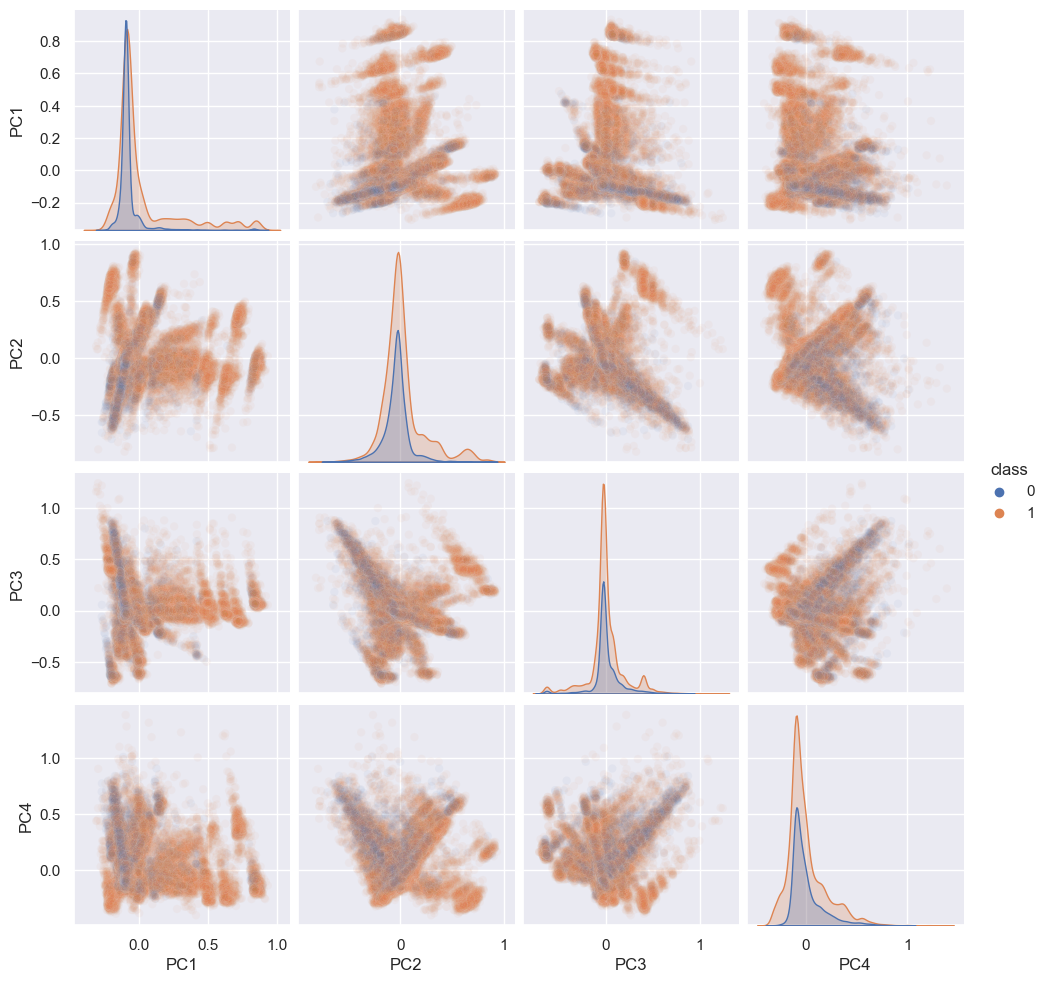

In [282]:
sns.pairplot(PCA_plot_df, plot_kws = {"alpha": 0.05}, hue = 'class')

#Saving the plot for Capstone Presentation and Report
plt.savefig('K-means PCA Cluster Plot', bbox_inches='tight')

plt.show()

Observations:
1. PC1 and PC3 are right skewed
2. PC2 is mostly normally distributed with a slight right skew
3. PC4 seems mostly normally distributed with a slight left skew
4. There is no clear distinction between the classes as found by the scatter plot above

Now, I shall do some manual hyperparameter optimization for some models:

### Manual Optimization

The following models will be run, and certain hyperparameters for each model will be manually optimized.
The models that will be run for optimization are:
1. LogisticRegression
2. SVM (Support Vector Machines)
3. Random Forrest (Decision Trees)
4. XGBoost

For all of these models, I shall be using the Scaled TF-IDF Vectorized data since it had a higher accuracy for the baseline LogisticRegression in comparison with the Bag-of-Words Vectorized data.

General Procedure for HyperParameter optimization:
1. Identify the hyperparameter to be manually optimized
2. Create a range for the hyperparameter
3. Create empty lists for storing the accuracy results for each hyperparameter range value
4. Create for loop to Instantiate and fit the model to the X_remainder_vect_tfidf, y_remainder datasets, and append the empty accuracy lists
5. Create a dataframe of the accuracy results and plot to identify the optimal value for the hyperparameter
6. Re-run and score the model using the optimal value found for the hyperparameter

Lets start with optimizing the c_value for the LogisticRegression model:

### LogisticRegression Optimisation

In [283]:
# Let's try this range of C values
c_values = [.00001, .0001, .001, 0.01, .1, 1, 10, 100, 1000, 10000]

# Create empty lists for storing the accuracy results of each C value
remainder_accuracies = []
test_accuracies = []

# Iterate over the C values
for value in c_values:
    print(f"Working on c={value}...", end="\r")
    
    # Instantiate a log reg and fit to the remainder set
    logreg = LogisticRegression(C=value, random_state=1).fit(X_remainder_tfidf_scaled, y_remainder)
    
    # Score on the remainder set and append this accuracy to its respective list
    remainder_accuracies.append(logreg.score(X_remainder_tfidf_scaled, y_remainder))
    
    # Score on the test set and append this accuracy to its respective list
    test_accuracies.append(logreg.score(X_test_tfidf_scaled, y_test))

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [284]:
# Check the accuracies
pd.DataFrame({'C value': c_values, 'remainder accuracy': remainder_accuracies, 'test accuracy': test_accuracies})

C value  remainder accuracy  test accuracy
0      0.00001            0.704003       0.704021
1      0.00010            0.704003       0.704021
2      0.00100            0.704003       0.704021
3      0.01000            0.838036       0.835077
4      0.10000            0.892204       0.885079
5      1.00000            0.903027       0.889785
6     10.00000            0.904324       0.886970
7    100.00000            0.904432       0.886928
8   1000.00000            0.904738       0.886844
9  10000.00000            0.904594       0.886802

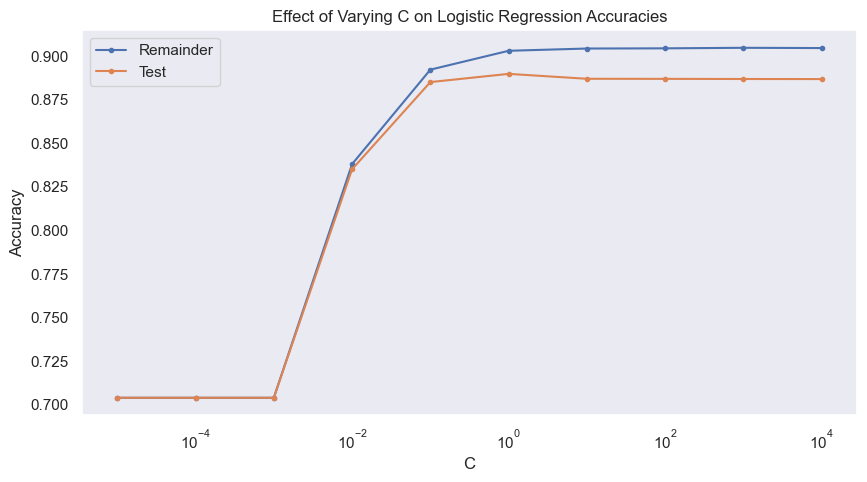

In [285]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, remainder_accuracies, label='Remainder', marker='.')
plt.plot(c_values, test_accuracies, label='Test', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Based on the plot above, a C_value of 1 seems to be giving the best result, where the remainder and test accuracies are relatively close. It can also be seen that a C_value greater than 1 causes the the Test accuracy to start dropping. This is not ideal since we want the model to give a high accuracy on the test data which is unseen by the model, as this is the best indicator of the effectivness of the model used.

Lets re-run the LogisticRegression with a C_value of 1 and check the accuracies:

In [286]:
# Instantiate a log reg and fit to the remainder set
logreg = LogisticRegression(C=1, random_state=1).fit(X_remainder_tfidf_scaled, y_remainder)
    
# Score on the model
print(f'LogisticRegression accuracy on the remainder set with a C_value of 1 is {round(logreg.score(X_remainder_tfidf_scaled, y_remainder)*100, 2)}%')
print(f'LogisticRegression accuracy on the test set with a C_value of 1 is {round(logreg.score(X_test_tfidf_scaled, y_test)*100, 2)}%')

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression accuracy on the remainder set with a C_value of 1 is 90.3%
LogisticRegression accuracy on the test set with a C_value of 1 is 88.98%


With a C_value of 1 we got a 90% accuracy on the remainder set, and an ~89% accuracy on the test. These are great results, there is possibly some room for improvement by optimizing other hyperparameters, and finding the optimal combination of hyperparameters. These further optimizations will be done via a ML Pipeline with a GridSearch.

Lets continue with the C_value optimization for a SVM model:

### SVM Optimisation

The C_value optimisation will follow the exact same procedure as the LogisticRegression optimisation above.

First the SVM library needs to be imported:

In [287]:
from sklearn.svm import LinearSVC

In [288]:
# Let's try this range of C values
c_values = [.00001, .0001, .001, 0.01, .1, 1, 10, 100, 1000, 10000]

# Create empty lists for storing the accuracy results of each C value
remainder_accuracies = []
test_accuracies = []

# Iterate over the C values
for value in c_values:
    print(f"Working on c={value}...", end="\r")
    
    # Instantiate a Linear SVC and fit to the remainder set
    lin_svm = LinearSVC(C=value, random_state=1).fit(X_remainder_tfidf_scaled, y_remainder)
    
    # Score on the remainder set and append this accuracy to its respective list
    remainder_accuracies.append(lin_svm.score(X_remainder_tfidf_scaled, y_remainder))
    
    # Score on the test set and append this accuracy to its respective list
    test_accuracies.append(lin_svm.score(X_test_tfidf_scaled, y_test))

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [289]:
# Check the accuracies
pd.DataFrame({'C value': c_values, 'remainder accuracy': remainder_accuracies, 'test accuracy': test_accuracies})

C value  remainder accuracy  test accuracy
0      0.00001            0.704003       0.704021
1      0.00010            0.704003       0.704021
2      0.00100            0.832220       0.828984
3      0.01000            0.892637       0.884911
4      0.10000            0.902109       0.889365
5      1.00000            0.903856       0.886970
6     10.00000            0.903603       0.886928
7    100.00000            0.898957       0.883567
8   1000.00000            0.862851       0.851548
9  10000.00000            0.829393       0.818816

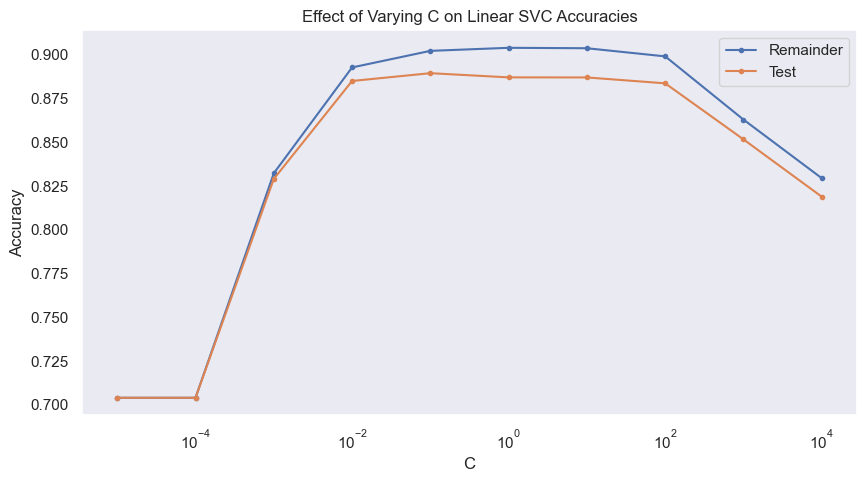

In [290]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, remainder_accuracies, label='Remainder', marker='.')
plt.plot(c_values, test_accuracies, label='Test', marker='.')
plt.legend()
plt.title('Effect of Varying C on Linear SVC Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Based on the plot above, a C_value of 0.1 seems to be giving the best result, where the remainder and test accuracies are relatively close. It can also be seen that a C_value greater than 1 causes the the Test accuracy to start dropping. This is not ideal since we want the model to give a high accuracy on the test data which is unseen by the model, as this is the best indicator of the effectiveness of the model used.

It is quite interesting to see the accuracies for both datasets drop quite a bit with a C_value of 10000, there is an almost ~7.5% drop in the accuracy from ~90% to ~82.5% on the remainder data, and a ~6% drop in the accuracy from ~88% to ~82% on the remainder data.

Lets re-run the Linear SVC with a C_value of 0.1 and check the accuracies:

In [291]:
# Instantiate a linear SVC and fit to the remainder set
lin_svm = LinearSVC(C= 0.1, random_state=1).fit(X_remainder_tfidf_scaled, y_remainder)

# Score on the model
print(f'Linear SVC accuracy on the remainder set with a C_value of 0.1 is {round(lin_svm.score(X_remainder_tfidf_scaled, y_remainder)*100, 2)}%')
print(f'Linear SVC accuracy on the test set with a C_value of 0.1 is {round(lin_svm.score(X_test_tfidf_scaled, y_test)*100, 2)}%')

Linear SVC accuracy on the remainder set with a C_value of 0.1 is 90.21%
Linear SVC accuracy on the test set with a C_value of 0.1 is 88.94%


We get a ~90% accuracy on the remainder, and ~89% accuracy on the test sets which is really good. These results are essentially matching the final accuracies from the LogisticRegression above, but with a higher C_value of 1 instead of 0.1. This difference in the C_values indicates that the regularization in the SVM model is stronger/higher than the LogisticRegression. In simple terms the lower C_value is indicating that the remainder/training data the model is being fit to might not be exactly representative of real-world data, and that any parameters being inflated should not be done so. So, the SVM model is trusting the remainder/training data less than the LogisticRegression model.

Lets continue with the optimization of the number of estimators for the Random Forest model:

### Random Forest Optimization

The number of estimators parameter optimization will follow a similar approach as the LogisticRegression optimization above.

First the Random Forrest library needs to be imported:

In [292]:
from sklearn.ensemble import RandomForestClassifier

In [293]:
# Let's try this range of estimators
n_estimators = range(1, 32, 2)

# Create empty lists for storing the accuracy results of each C value
remainder_accuracies = []
test_accuracies = []

# Iterate through the number of estimators range
for n in n_estimators:
    print(f"Working on n={n}...", end="\r")

    # Instantiate RandomForest and fit to the remainder set
    RF_model = RandomForestClassifier(n_estimators=n, max_depth=None, random_state=1)
    RF_model.fit(X_remainder_tfidf_scaled, y_remainder)
    
    # Score on the remainder set and append this accuracy to its respective list
    remainder_accuracies.append(RF_model.score(X_remainder_tfidf_scaled, y_remainder))

    # Score on the test set and append this accuracy to its respective list
    test_accuracies.append(RF_model.score(X_test_tfidf_scaled, y_test))

In [294]:
# Check the accuracies
pd.DataFrame({'n estimators': n_estimators, 'remainder accuracy': remainder_accuracies, 'test accuracy': test_accuracies})

n estimators  remainder accuracy  test accuracy
0              1            0.913670       0.773268
1              3            0.963030       0.816253
2              5            0.979849       0.832934
3              7            0.986836       0.841632
4              9            0.991392       0.846212
5             11            0.993805       0.850498
6             13            0.995336       0.853103
7             15            0.996633       0.855372
8             17            0.997245       0.856633
9             19            0.997875       0.857683
10            21            0.998559       0.858565
11            23            0.998775       0.859952
12            25            0.998847       0.860666
13            27            0.999010       0.862641
14            29            0.999190       0.860877
15            31            0.999352       0.861717

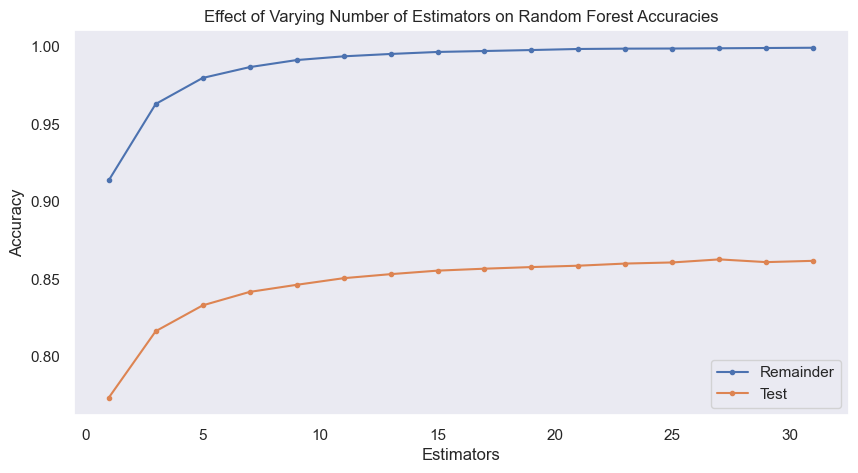

In [295]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(n_estimators, remainder_accuracies, label='Remainder', marker='.')
plt.plot(n_estimators, test_accuracies, label='Test', marker='.')
plt.legend()
plt.title('Effect of Varying Number of Estimators on Random Forest Accuracies')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The model is overfitting past an estimators value of 10. Now, I shall try to find the optimal max_depth for the model. The number of estimators will be set to 8 for this run, and the range for the max depth will set to be between 2-50, with an increment of 2.

The max_depth parameter optimization will follow a similar approach as the LogisticRegression optimization above.

In [296]:
from tqdm.notebook import tqdm_notebook
import time

In [297]:
# Let's try this range of estimators
max_depth_range = range(2, 50, 2)

# Create empty lists for storing the accuracy results of each C value
remainder_accuracies = []
test_accuracies = []

# Iterate through the number of estimators range
for i in tqdm_notebook(range(1)):
    time.sleep(0.5)
    for d in max_depth_range:
        print(f"Working on max_depth={d}...", end="\r")

        # Instantiate RandomForest and fit to the remainder set
        RF_model = RandomForestClassifier(n_estimators=8, max_depth=d, random_state=1)
        RF_model.fit(X_remainder_tfidf_scaled, y_remainder)
        
        # Score on the remainder set and append this accuracy to its respective list
        remainder_accuracies.append(RF_model.score(X_remainder_tfidf_scaled, y_remainder))

        # Score on the test set and append this accuracy to its respective list
        test_accuracies.append(RF_model.score(X_test_tfidf_scaled, y_test))
    pass

  0%|          | 0/1 [00:00<?, ?it/s]

In [298]:
# Check the accuracies
pd.DataFrame({'max depth': max_depth_range, 'remainder accuracy': remainder_accuracies, 'test accuracy': test_accuracies})

max depth  remainder accuracy  test accuracy
0           2            0.704039       0.703979
1           4            0.706002       0.705240
2           6            0.716429       0.713769
3           8            0.726603       0.722551
4          10            0.740073       0.732846
5          12            0.762133       0.754191
6          14            0.770056       0.758813
7          16            0.789127       0.773394
8          18            0.800706       0.782218
9          20            0.812321       0.790201
10         22            0.820155       0.796336
11         24            0.828150       0.798605
12         26            0.838793       0.802933
13         28            0.850786       0.810496
14         30            0.855000       0.813396
15         32            0.863734       0.816757
16         34            0.869442       0.819992
17         36            0.875709       0.822808
18         38            0.884461       0.826883
19         40            0.891502       0.826757
20         42            0.897499       0.828732
21         44            0.900488       0.829741
22         46            0.906665       0.831421
23         48            0.912301       0.835413

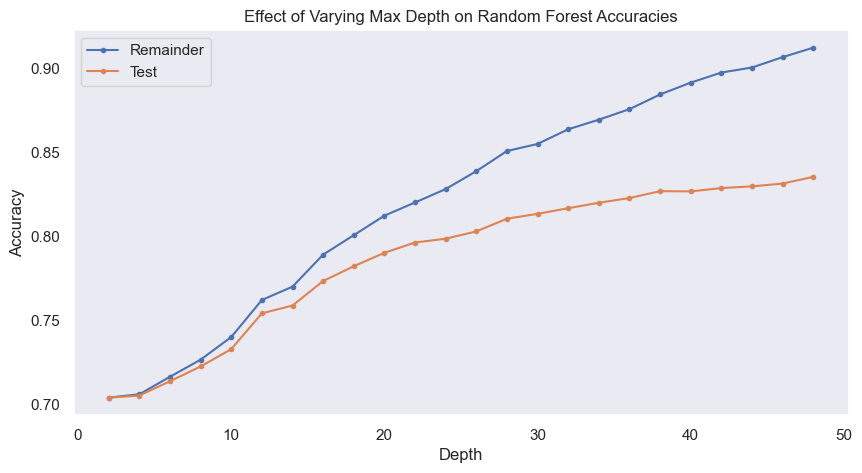

In [299]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(max_depth_range, remainder_accuracies, label='Remainder', marker='.')
plt.plot(max_depth_range, test_accuracies, label='Test', marker='.')
plt.legend()
plt.title('Effect of Varying Max Depth on Random Forest Accuracies')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Seems like the accuracy on the test set starts to taper off around a max_depth of 40, but luckily it is not yet in over-fitting territory.

For this reason, I shall re-run the Random Forest model with a n_estimators value of 8, with a max_depth of 40, and check the accuracies:

In [300]:
# Instantiate RandomForest and fit to the remainder set
RF_model = RandomForestClassifier(n_estimators=8, max_depth=40, random_state=1)
RF_model.fit(X_remainder_tfidf_scaled, y_remainder)

# Score on the model
print(f'Random Forest accuracy on the remainder set is {round(RF_model.score(X_remainder_tfidf_scaled, y_remainder)*100, 2)}%')
print(f'Random Forest accuracy on the test set is {round(RF_model.score(X_test_tfidf_scaled, y_test)*100, 2)}%')

Random Forest accuracy on the remainder set is 89.15%
Random Forest accuracy on the test set is 82.68%


We get a ~89% accuracy on the remainder, and ~83% accuracy on the test sets which is really good. These remainder accuracy result is essentially matching the accuracy of the LogisticRegression and SVM above, but there is a ~6% difference in the test set accuracies between the three models.

Lets continue with the optimization of the number of estimators for the XGBoost model:

### XGBoost Optimization

The number of estimators parameter optimization will follow a similar approach as the LogisticRegression optimization above.

First the XGBoost library needs to be imported:

In [301]:
from xgboost import XGBClassifier

/Users/userone/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [302]:
# Let's try this range of estimators
n_estimators = range(1, 52, 5)

# Create empty lists for storing the accuracy results of each C value
remainder_accuracies = []
test_accuracies = []

# Iterate through the number of estimators range
for n in n_estimators:
    #for n in tqdm(range(n)):
    print(f"Working on n={n}...", end="\r")
    
    # Instantiate RandomForest and fit to the remainder set
    XGB_model = XGBClassifier(n_estimators=n, max_depth=None, random_state=1)
    XGB_model.fit(X_remainder_tfidf_scaled, y_remainder)

    # Score on the remainder set and append this accuracy to its respective list
    remainder_accuracies.append(XGB_model.score(X_remainder_tfidf_scaled, y_remainder))

    # Score on the test set and append this accuracy to its respective list
    test_accuracies.append(XGB_model.score(X_test_tfidf_scaled, y_test))
    #pass

In [303]:
# Check the accuracies
pd.DataFrame({'n estimators': n_estimators, 'remainder accuracy': remainder_accuracies, 'test accuracy': test_accuracies})

n estimators  remainder accuracy  test accuracy
0              1            0.731483       0.730955
1              6            0.779312       0.770579
2             11            0.807927       0.797176
3             16            0.827448       0.815875
4             21            0.845708       0.829909
5             26            0.856116       0.838859
6             31            0.864058       0.843733
7             36            0.868992       0.848607
8             41            0.873314       0.852599
9             46            0.878752       0.855456
10            51            0.882174       0.857851

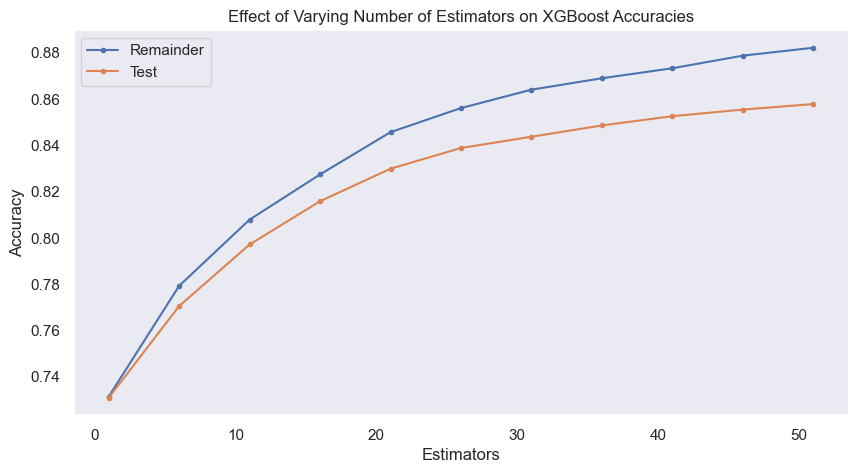

In [304]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(n_estimators, remainder_accuracies, label='Remainder', marker='.')
plt.plot(n_estimators, test_accuracies, label='Test', marker='.')
plt.legend()
plt.title('Effect of Varying Number of Estimators on XGBoost Accuracies')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The model has the best accuracy result with 46 estimators. It is interesting to see that the Test accuracy starts to taper off around 48/49 estimators, indicating that this is most likely the optimal number of estimators for this model. But, it can be seen that the accuracy on the remainder set was still rising, this could be indicative of some over-fitting starting to occur, since the test accuracy is starting to taper off.

Now, I shall try to find the optimal max_depth for the model. The number of estimators will be set to 46 for this run, and the range for the max depth will set to be between 2-10, with an increment of 2.

The max_depth parameter optimization will follow a similar approach as the LogisticRegression optimization above.

In [305]:
# Let's try this range of estimators
max_depth_range = range(2, 10, 2)

# Create empty lists for storing the accuracy results of each C value
remainder_accuracies = []
test_accuracies = []

# Iterate through the number of estimators range
for d in max_depth_range:
    print(f"Working on max_depth={d}...", end="\r")

    # Instantiate RandomForest and fit to the remainder set
    XGB_model = XGBClassifier(n_estimators=46, max_depth=d, random_state=1)
    XGB_model.fit(X_remainder_tfidf_scaled, y_remainder)
    
    # Score on the remainder set and append this accuracy to its respective list
    remainder_accuracies.append(XGB_model.score(X_remainder_tfidf_scaled, y_remainder))

    # Score on the test set and append this accuracy to its respective list
    test_accuracies.append(XGB_model.score(X_test_tfidf_scaled, y_test))

In [306]:
# Check the accuracies
pd.DataFrame({'max depth': max_depth_range, 'remainder accuracy': remainder_accuracies, 'test accuracy': test_accuracies})

max depth  remainder accuracy  test accuracy
0          2            0.815725       0.812723
1          4            0.857521       0.844279
2          6            0.878752       0.855456
3          8            0.895158       0.861801

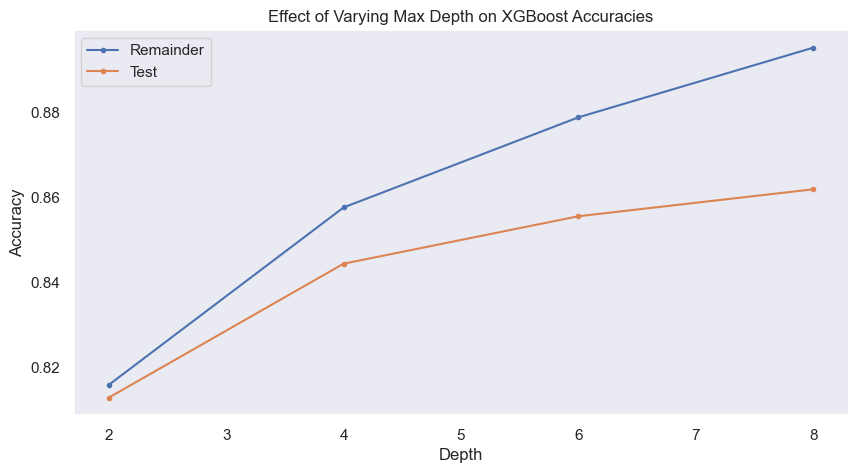

In [307]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(max_depth_range, remainder_accuracies, label='Remainder', marker='.')
plt.plot(max_depth_range, test_accuracies, label='Test', marker='.')
plt.legend()
plt.title('Effect of Varying Max Depth on XGBoost Accuracies')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Seems like the accuracy on the test set starts to taper off around a max_depth of 6, but luckily it is not yet in over-fitting territory.

For this reason, I shall re-run the XGBoost model with a n_estimators value of 49, with a max_depth of 6, and check the accuracies:

In [308]:
# Instantiate RandomForest and fit to the remainder set
XGB_model = XGBClassifier(n_estimators=49, max_depth=6, random_state=1)
XGB_model.fit(X_remainder_tfidf_scaled, y_remainder)

# Score on the model
print(f'XGBoost accuracy on the remainder set is {round(XGB_model.score(X_remainder_tfidf_scaled, y_remainder)*100, 2)}%')
print(f'XGBoost accuracy on the test set is {round(XGB_model.score(X_test_tfidf_scaled, y_test)*100, 2)}%')

XGBoost accuracy on the remainder set is 88.06%
XGBoost accuracy on the test set is 85.67%


We get a ~88% accuracy on the remainder, and ~86% accuracy on the test sets which is really good. These remainder accuracy result is essentially matching (1% less) the accuracy of the LogisticRegression, SVM, and Random Forest above, but there is a ~2% difference in the test set accuracies compared with the LogisticRegression and SVM models, but is ~4% higher than the Random Forest model.

Observations:
- Remainder set accuracies for all the model above is essentially the same:
    * LogisticRegression - ~90%
    * SVM - ~89%
    * Random Forest - ~89%
    * XGBoost - ~88%
- Test set accuracies have some variance between the models:
    * LogisticRegression - ~89%
    * SVM - ~89%
    * Random Forest - ~83%
    * XGBoost - ~86%

Summary of optimal values for model hyperparameters:
* LogisticRegression: C_value = 1
* SVM: C_value = 0.1
* Random Forest: n_estimators = 8 / max_depth = 40
* XGBoost: n_estimators = 49 / max_depth = 6

Now, that I have some potential optimal values for certain model hyperparameters, I shall, in a separate notebook, conduct some Advanced Modelling to further fine-tune and find the best model with the most optimal hyperparameters.

With some manual optimization conducted above, I will be able to reduce the ranges of these hyperparameters during the pipeline and gridsearch stage. A reduction in the ranges will help with the computation times, since models such as Random Forest, and XGBoost are quite time consuming and computationally heavy, especially when run on a laptop/local machine which is not cloud computing.

These will be the ranges for the model hyperparameters:
* LogisticRegression: C_value = [.1, 1, 10]
* SVM: C_value = [.01, .1, 1]
* Random Forest: n_estimators = range(8, 13) / max_depth = range(40, 46, 2)
* XGBoost: n_estimators = range(50, 53, 2) / max_depth = range(8, 11, 2)

### Saving the Vectorized X_remainder/test, and y_remainder/test datasets as CSVs

This is done so that they can be used in the next notebook for running advanced modelling using ML Pipelines

In [309]:
# Saving the datasets into a CSV file
X_remainder_vect_tfidf.to_csv('Data/X_remainder_vect_tfidf.csv', index = False)
X_test_vect_tfidf.to_csv('Data/X_test_vect_tfidf.csv', index = False)
y_remainder.to_csv('Data/y_remainder.csv', index = False)
y_test.to_csv('Data/y_test.csv', index = False)

As a sanity check to ensure that the datasets above were saved properly without and issues, I shall load them back into this notebook and compare them with the original datasets:

In [310]:
# Lets load the saved CSVs for the sanity check
X_remainder_check = pd.read_csv('Data/X_remainder_vect_tfidf.csv')
X_test_check = pd.read_csv('Data/X_test_vect_tfidf.csv')
y_remainder_check = pd.read_csv('Data/y_remainder.csv')
y_test_check = pd.read_csv('Data/y_test.csv')

In [311]:
# Checking to see that the shapes are matching
print(X_remainder_vect_tfidf.shape == X_remainder_check.shape)
print(X_test_vect_tfidf.shape == X_test_check.shape)
print(y_remainder.shape[0] == y_remainder_check.shape[0]) # y_remainder is a series so only checking for matching number of rows
print(y_test.shape[0] == y_test_check.shape[0]) # y_test is a series so only checking for matching number of rows

True
True
True
True


In [312]:
# Checking to see if there is any missing data
print(X_remainder_check.isna().sum().sum())
print(X_test_check.isna().sum().sum())
print(y_remainder_check.isna().sum().sum())
print(y_test_check.isna().sum().sum())

0
0
0
0


Brilliant, the datasets were saved properly, with the shapes still matching the originals and no missing data.

Now I shall move onto Notebook 3 for some Advanced Modelling